<a href="https://colab.research.google.com/github/raulbenitez/DEEPCARDIO/blob/master/nextFrame/nextFrame200_performanceAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn
from skimage.filters import threshold_otsu

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
seq = keras.models.load_model('drive/My Drive/tfm/learn/NextFrame/200epochModel.h5')
seq

In [ ]:
# UTIL FUNCTIONS

def generate_movies(n_samples=1200, n_frames=15, speed=1):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t*speed
                y_shift = ystart + directiony * t*speed
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies


def row_n_imageshow(imgs, titles=None):
  n = len(imgs)
  fig = plt.figure(figsize=(5*n, 5))

  for i, img in enumerate(imgs):
    ax = fig.add_subplot(1, n, i+1)
    if titles and len(titles) > i and titles[i]:
      ax.text(**titles[i])
    plt.imshow(img)


def performance_evaluation(noisy_track, shifted_track, pred_track, title='', plot=True, n_decimals=4, binarize_threshold=0.5):
  disc_pred_track = (pred_track > binarize_threshold).astype(float)
  resDF = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1']).astype(float)

  for i in range(min(len(pred_track), len(noisy_track))):
    disc_shifted_frame = (shifted_track[i,::,::,0]>binarize_threshold)
    pixel_performance = np.logical_not(np.logical_xor(disc_pred_track[i,::,::,0], disc_shifted_frame)).astype(float)
    accuracy = round(pixel_performance.sum()/pixel_performance.size, n_decimals)
    # index -> reality, columns -> prediction
    confusionDF = pd.DataFrame(confusion_matrix(disc_shifted_frame.astype(float).flatten(), disc_pred_track[i,::,::,0].flatten()), index=[0,1], columns=[0,1])
    precision = round(confusionDF.loc[1, 1] / (confusionDF.loc[1, 1] + confusionDF.loc[0, 1]), n_decimals)
    recall = round(confusionDF.loc[1, 1] / (confusionDF.loc[1, 1] + confusionDF.loc[1, 0]), n_decimals)
    f1 = round(2 * (precision*recall)/(precision+recall), n_decimals)
    resDF.loc[i, :] = [accuracy, precision, recall, f1]

    if plot:
      txts = [{'x': 1, 'y': 3, 's':f'{title}Predictions !', 'fontsize':20, 'color':'w'},
            {'x': 1, 'y': 3, 's':f'Binary Pred ({round(binarize_threshold,2)}) !', 'fontsize':20, 'color':'w'},
            {'x': 1, 'y': 3, 's':'Ground truth (shifted)', 'fontsize':20},
            {'x': 1, 'y': 3, 's':'Original frame', 'fontsize':20},
            {'x': 1, 'y': 3, 's':f'Accuracy {accuracy}, f1: {f1}\nprecision: {precision}, recall: {recall}', 'fontsize':10}]
      row_n_imageshow([pred_track[i, ::, ::, 0],
                      disc_pred_track[i, ::, ::, 0], 
                      (shifted_track[i,::,::,0]>binarize_threshold).astype(float),
                      noisy_track[i,::,::,0],
                      pixel_performance], titles=txts)
    
  return resDF

In [ ]:
i = 0
resDF = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'])
resDF.loc[i,:] = [0, 1, 2, 4]
resDF

accuracy precision recall f1
0        0         1      2  4

accuracy precision recall      f1
0   0.9681    0.8442  0.625  0.7182

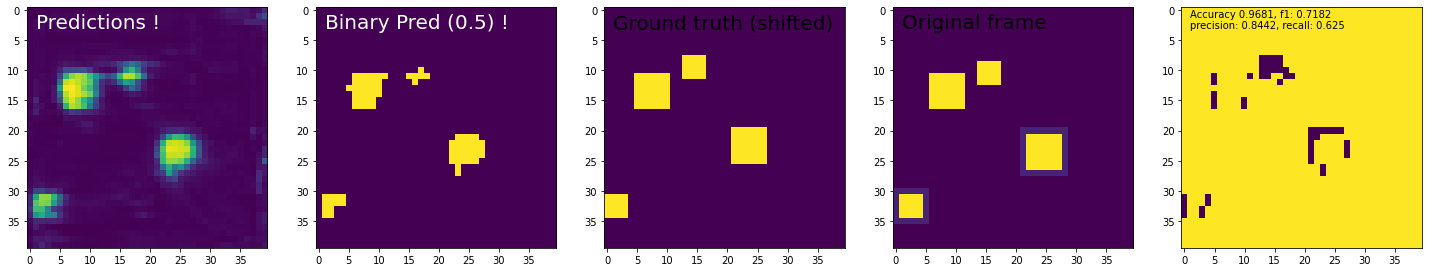

In [ ]:
noisy15, shifted15 = generate_movies(n_samples=1, n_frames=15)
pred15 = seq.predict(noisy15)
performance_evaluation(noisy15[0,-1:], shifted15[0,-1:], pred15[0,-1:], binarize_threshold=0.5)

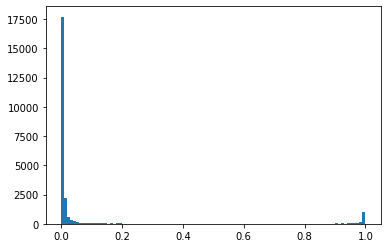

In [ ]:
plt.hist(pred15.flatten(), bins=100)
plt.show()

In [ ]:
threshold_otsu(pred15)

0.47072053

In [ ]:
noisy, shifted = generate_movies(n_samples=1, n_frames=15)
pred = seq.predict(noisy)
df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=False, binarize_threshold=0.5)

## 1 - 15 frames for prediction, mean of 5 executions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


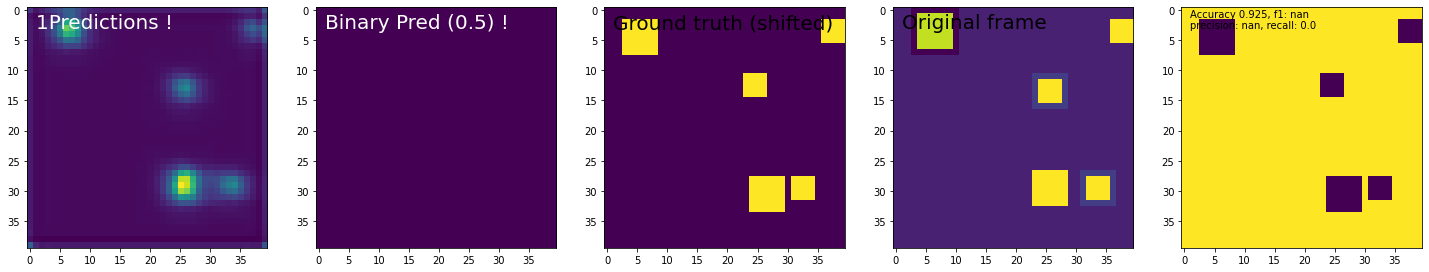

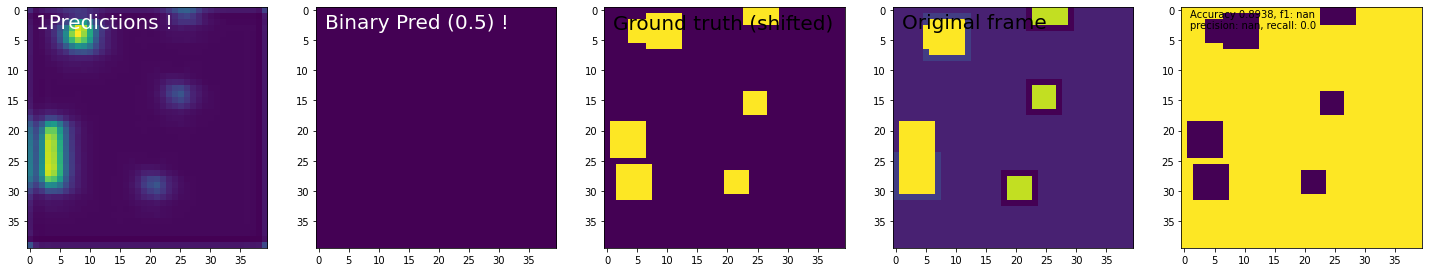

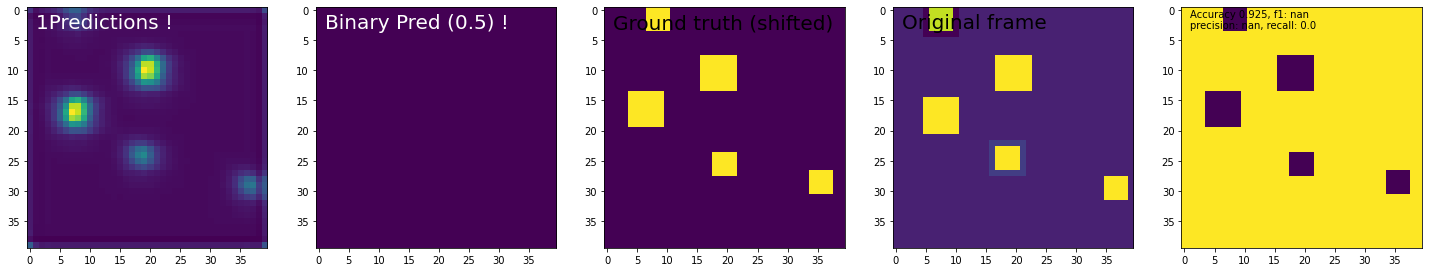

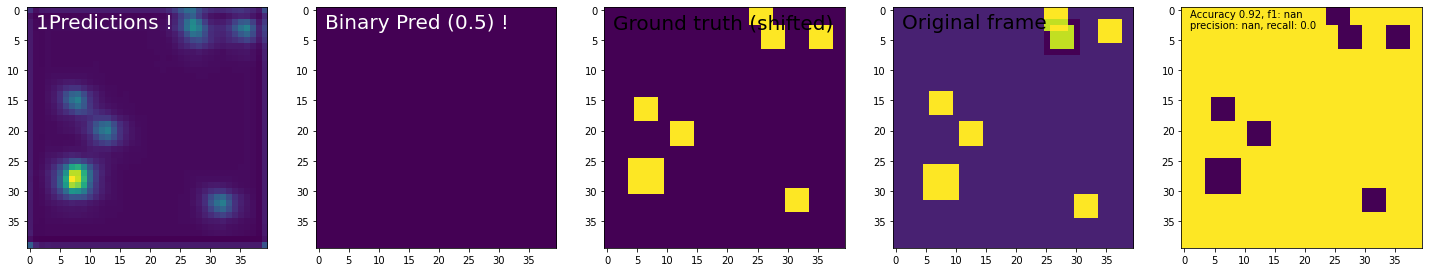

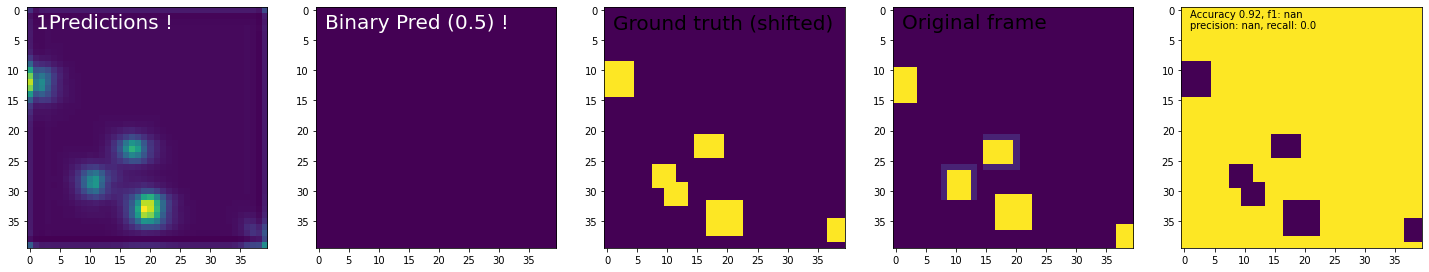

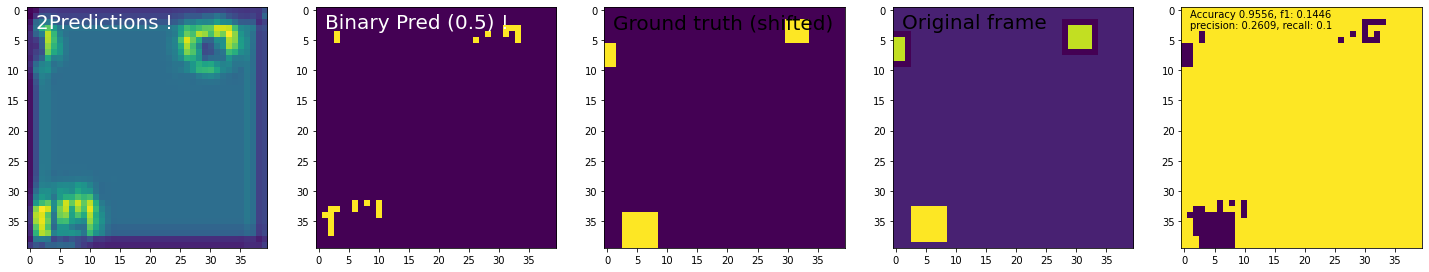

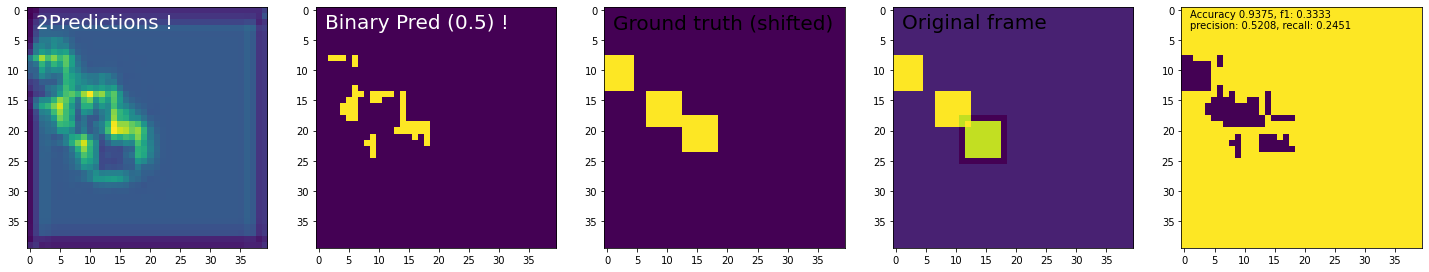

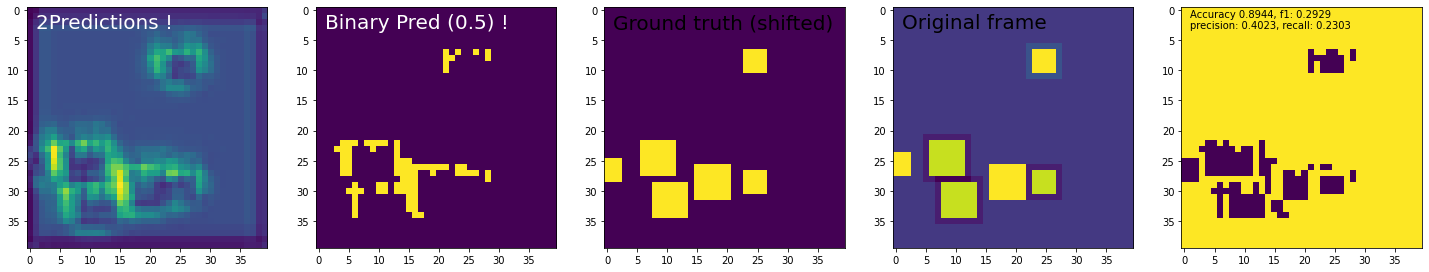

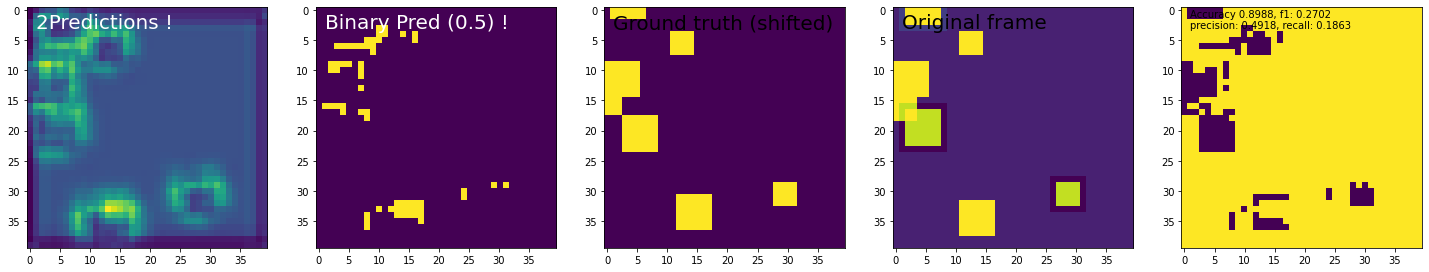

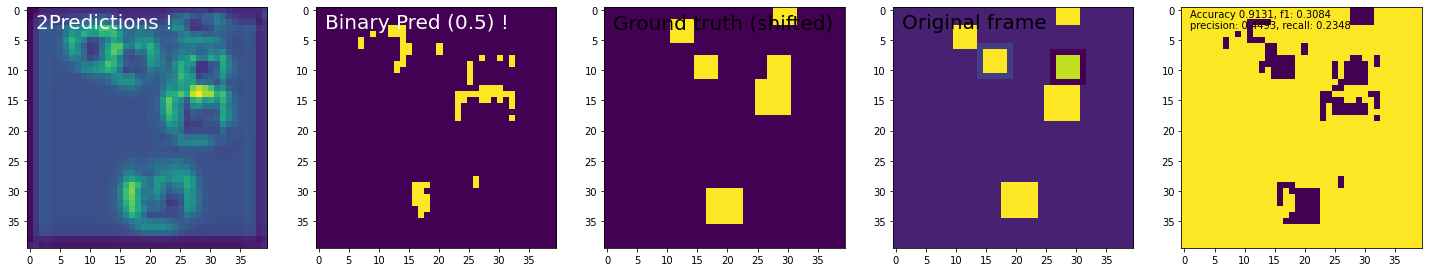

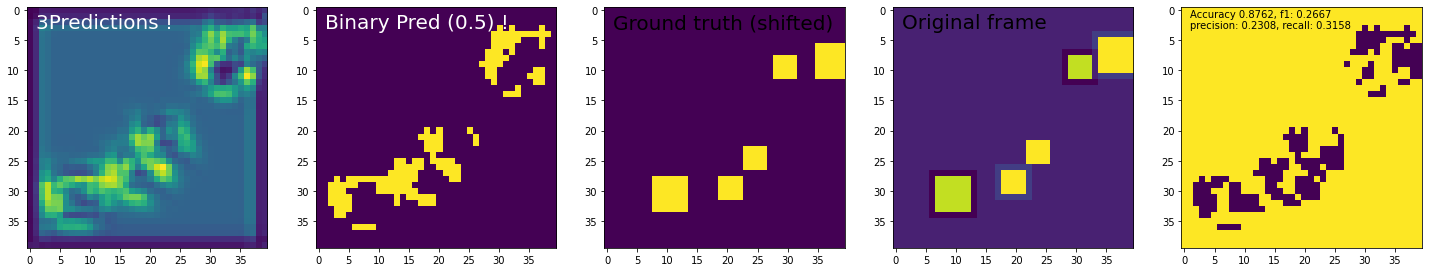

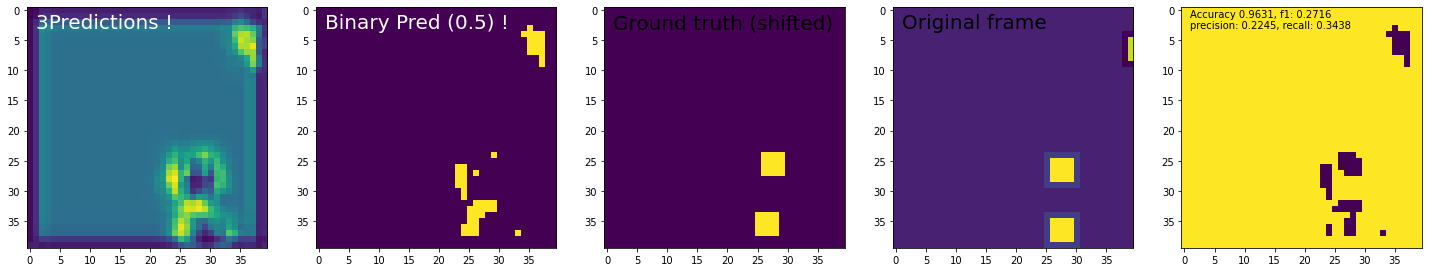

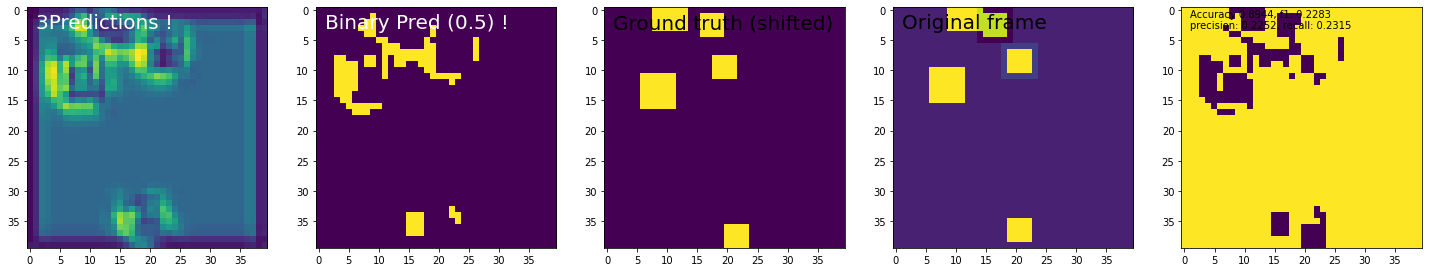

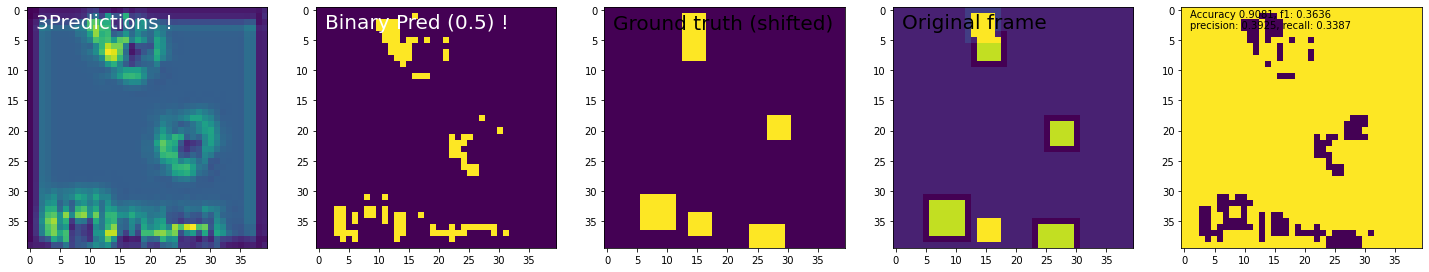

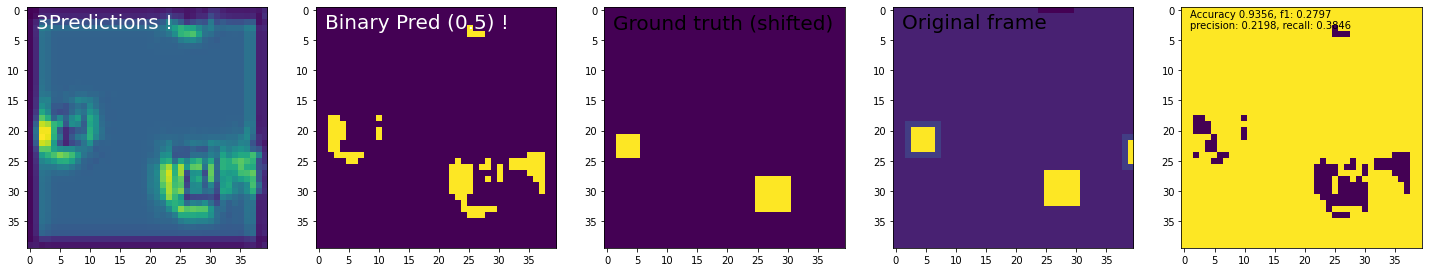

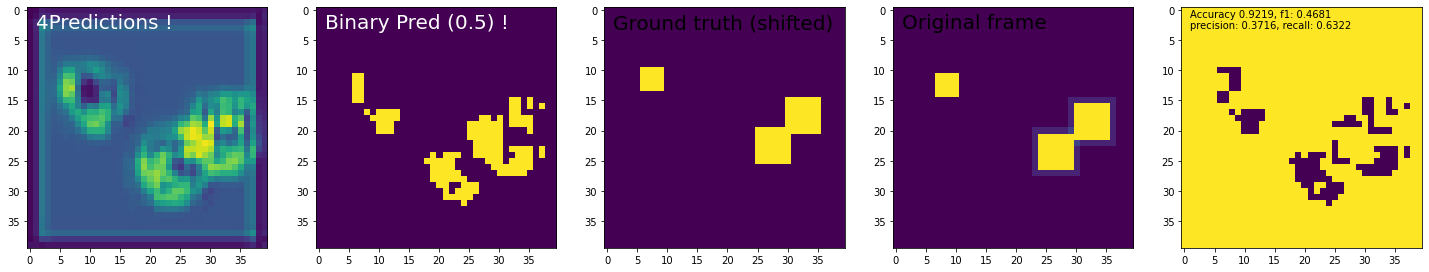

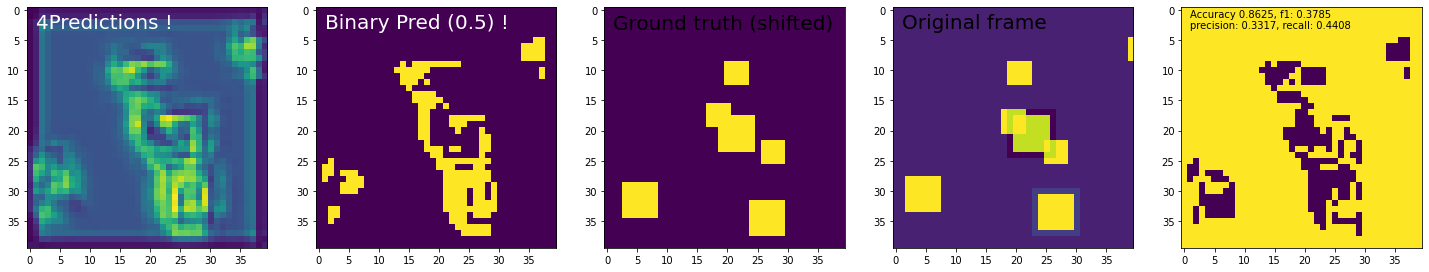

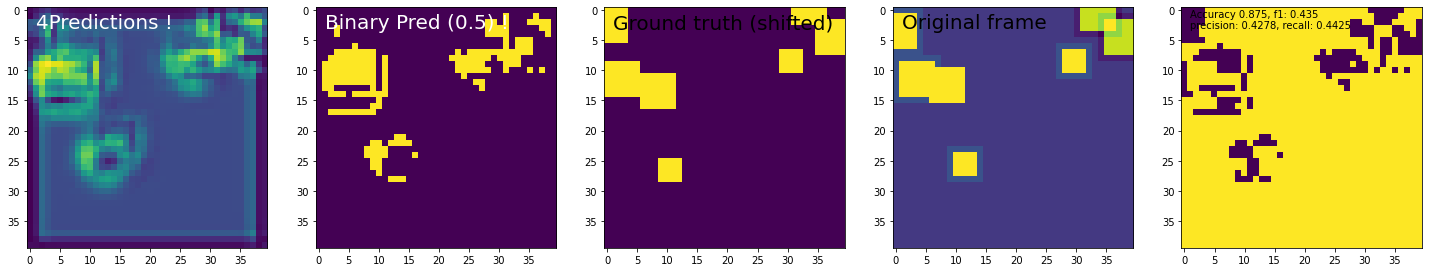

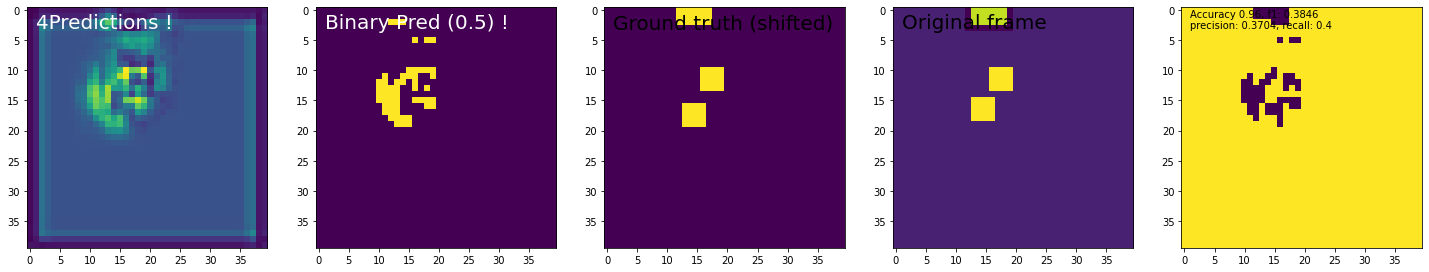

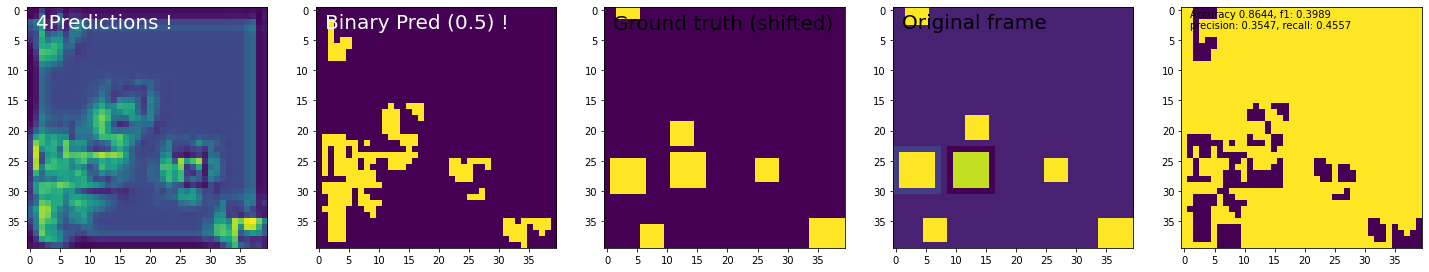

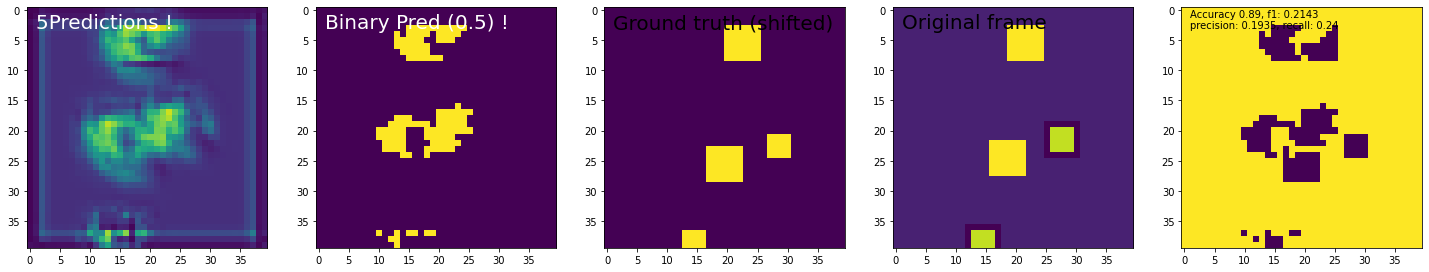

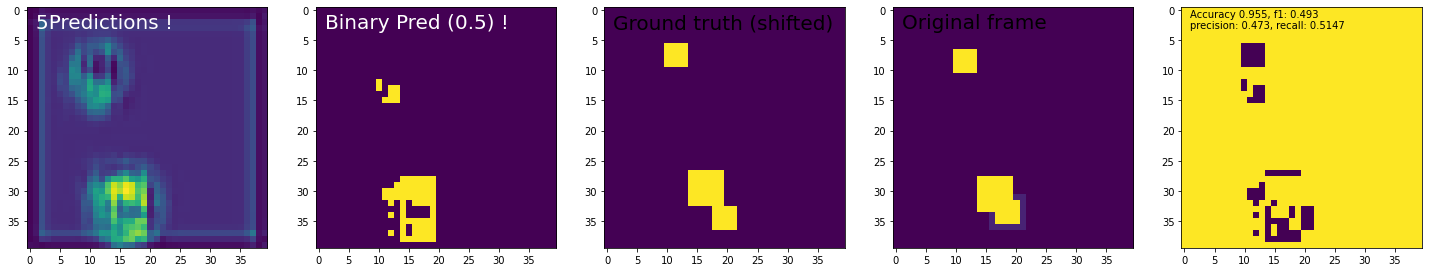

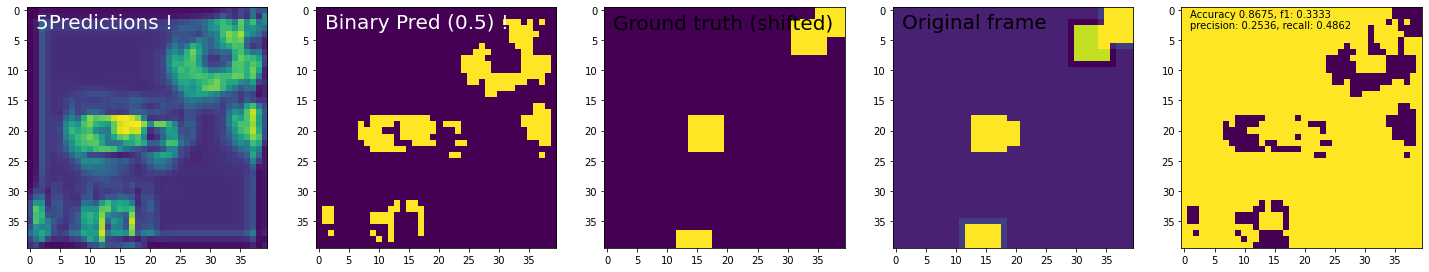

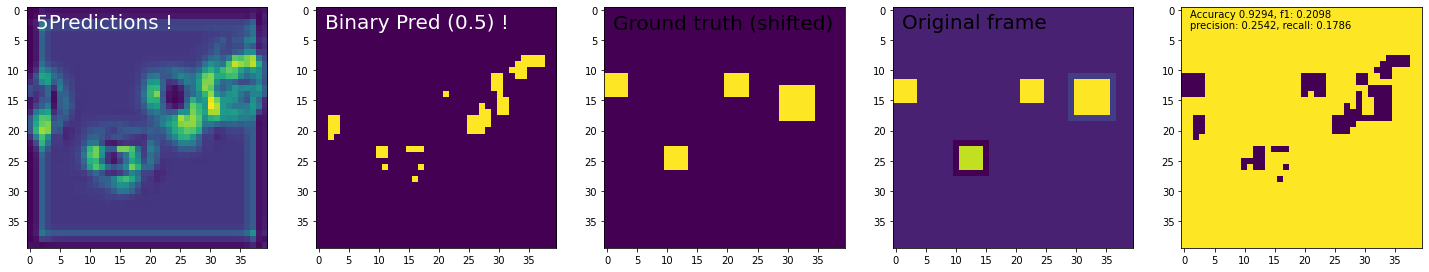

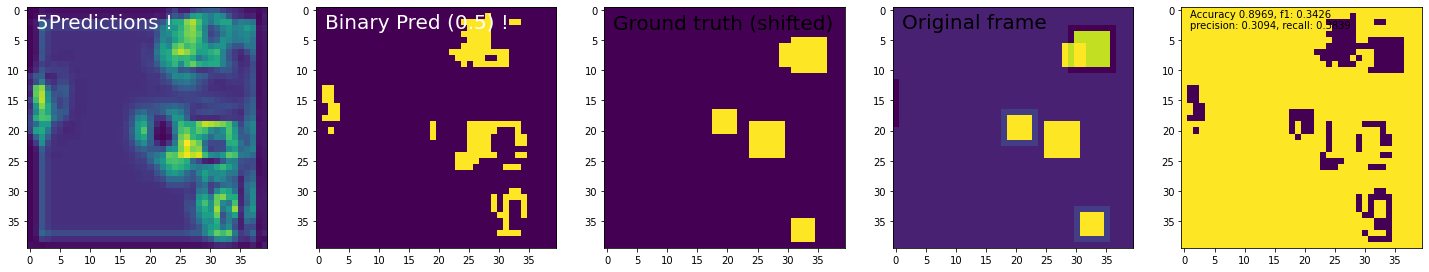

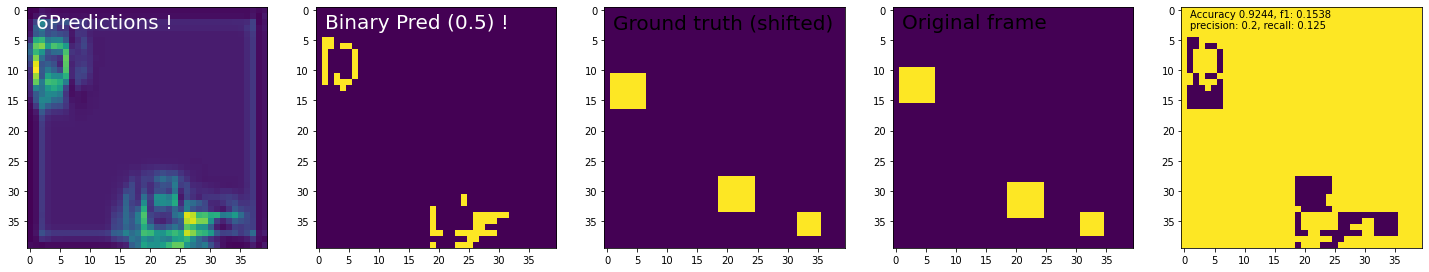

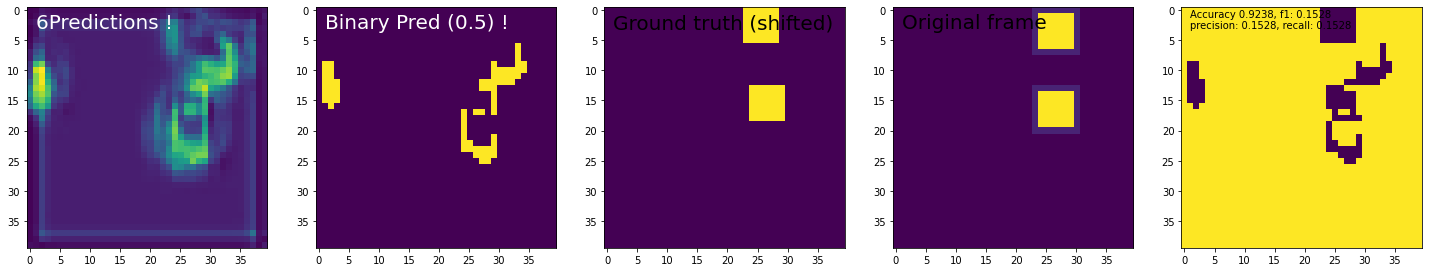

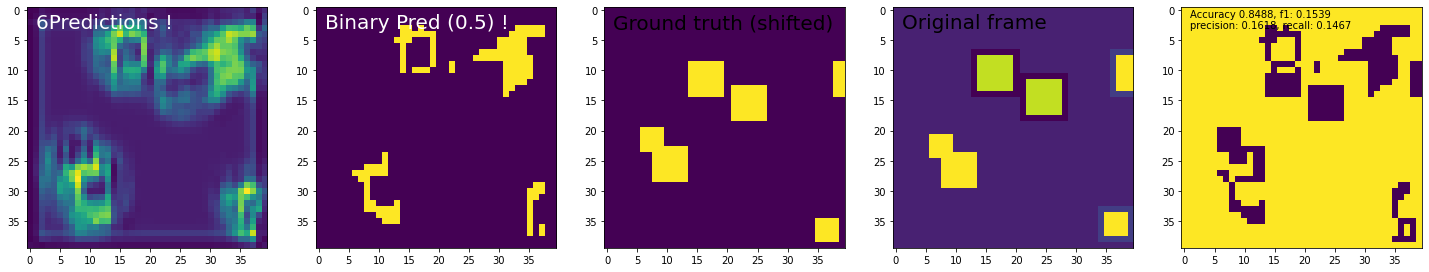

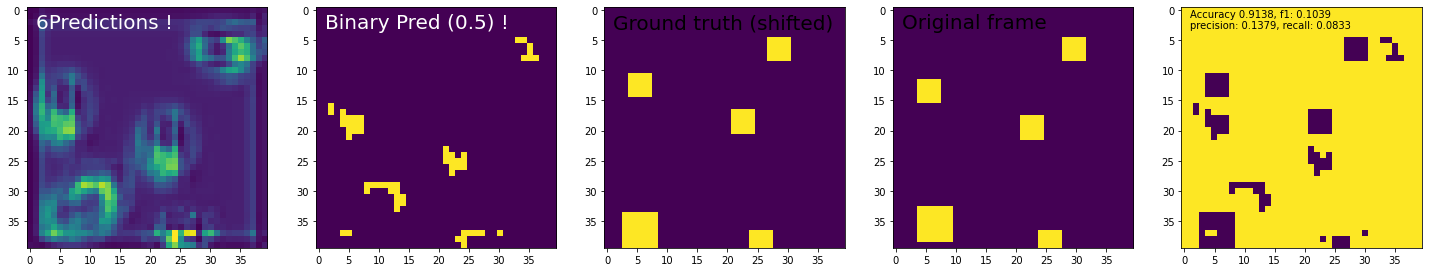

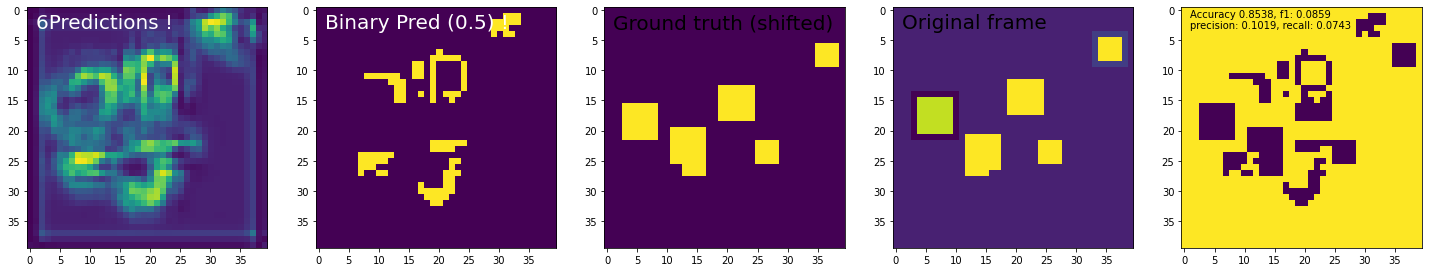

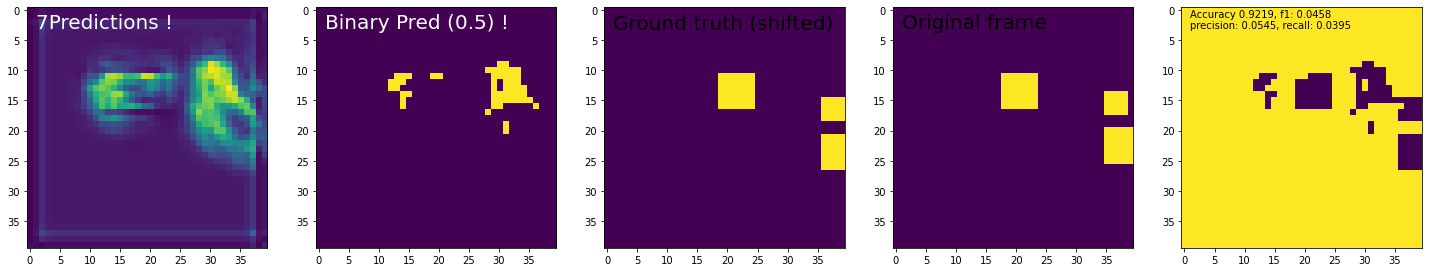

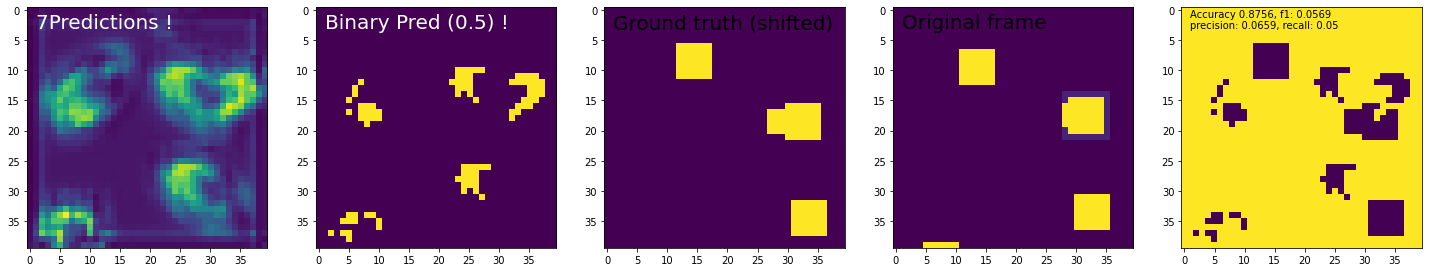

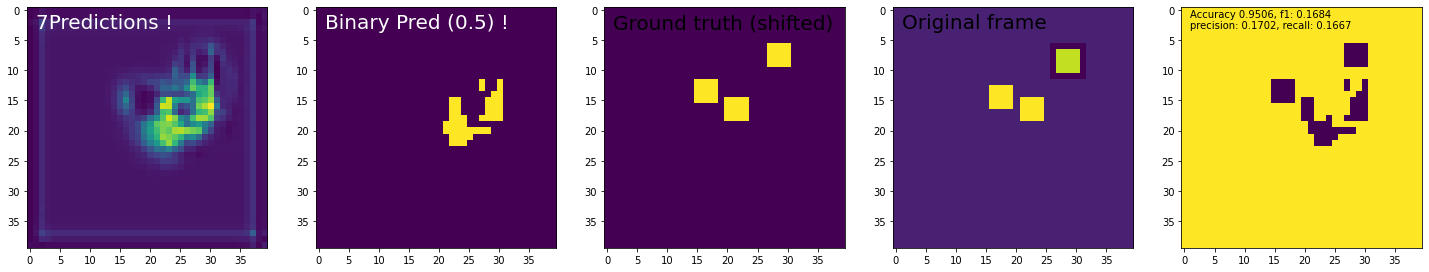

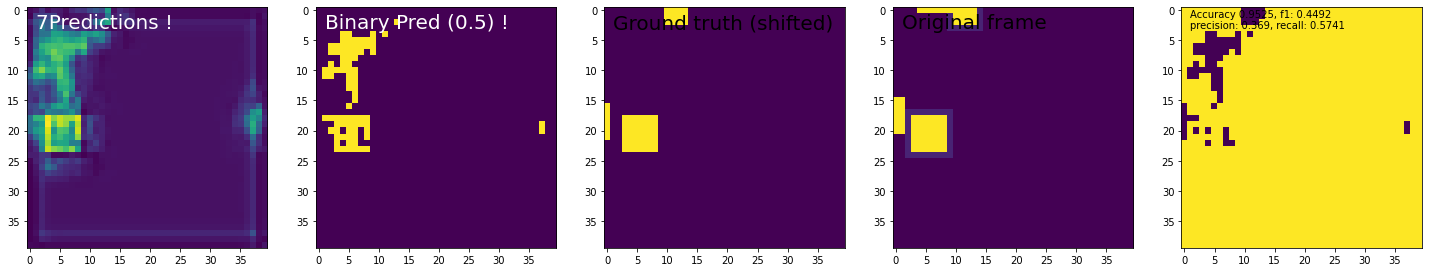

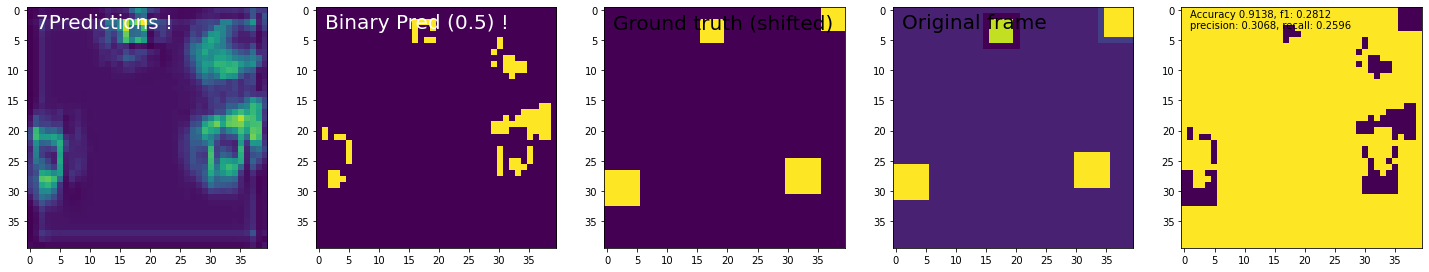

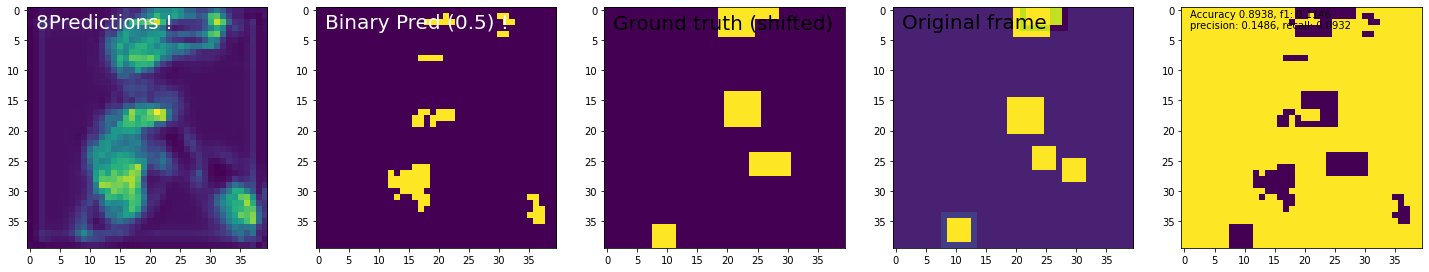

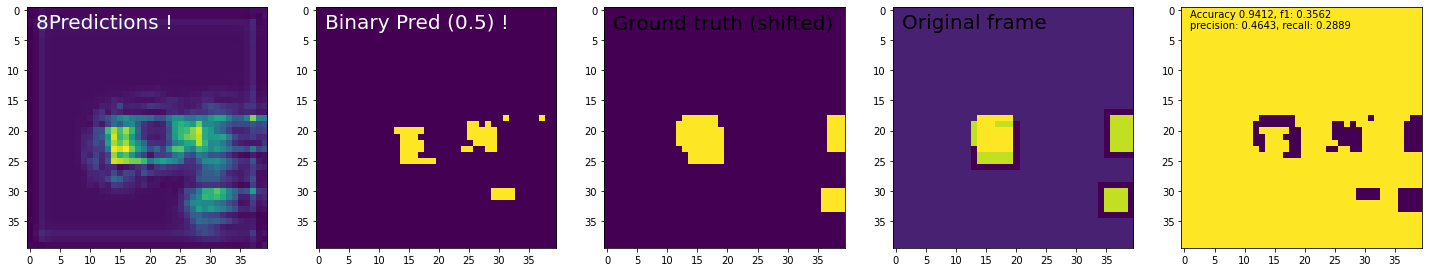

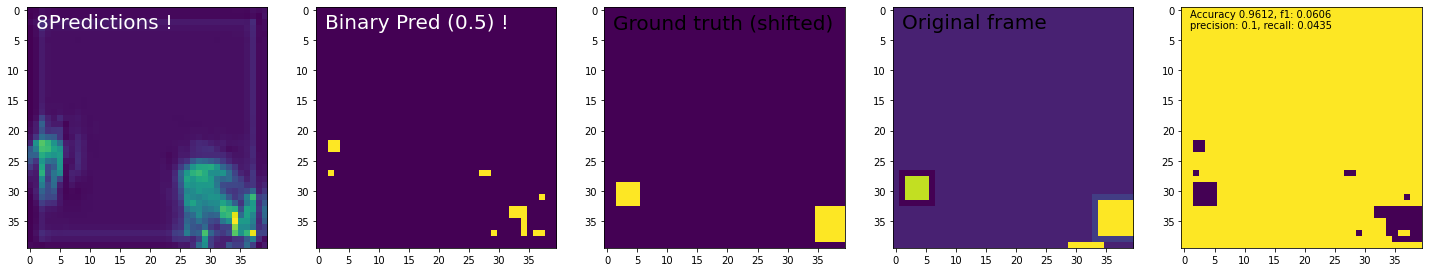

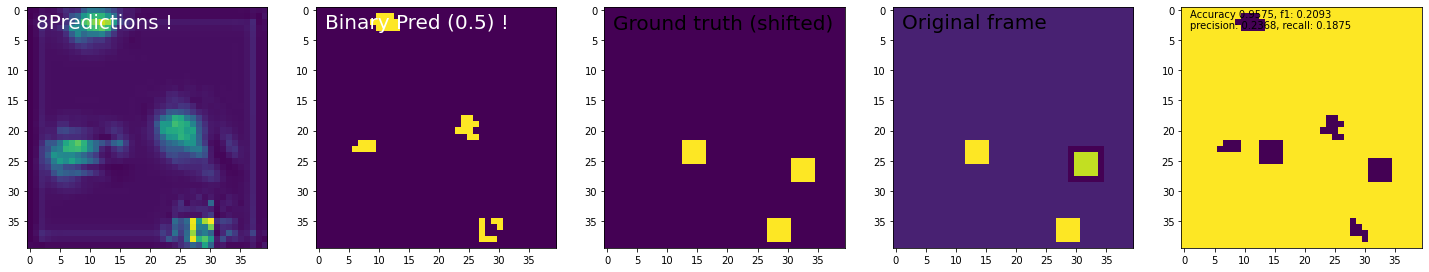

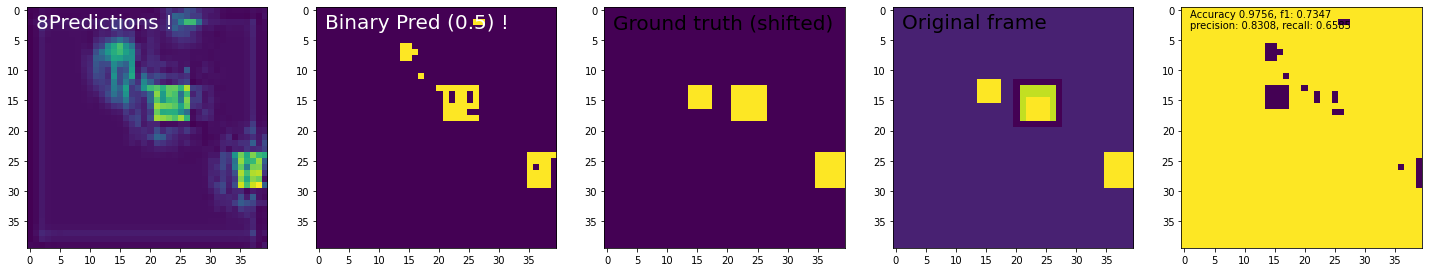

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


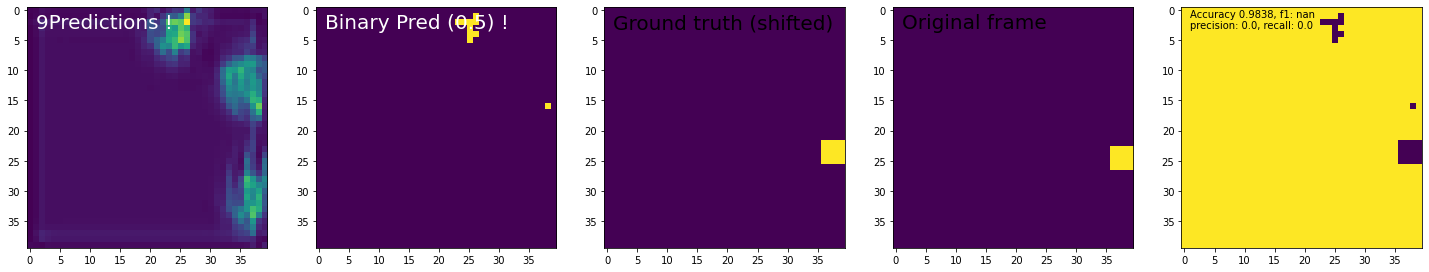

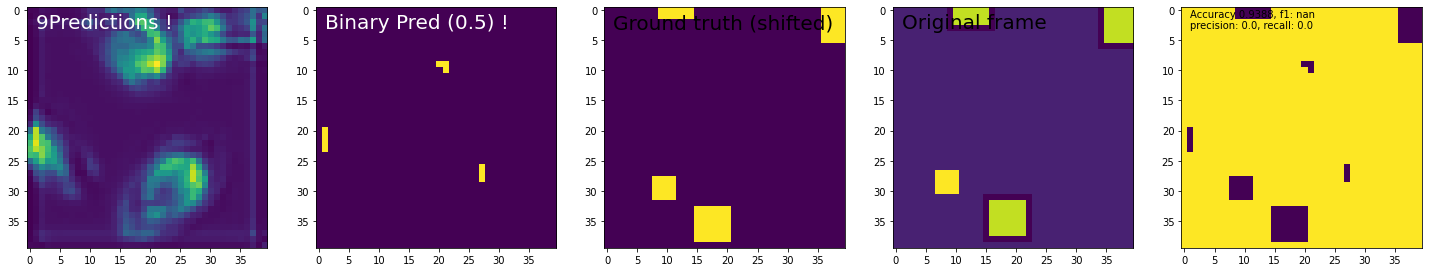

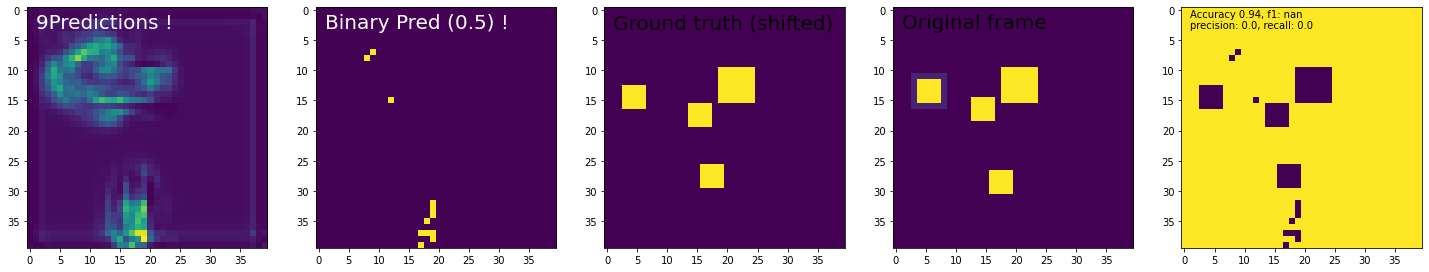

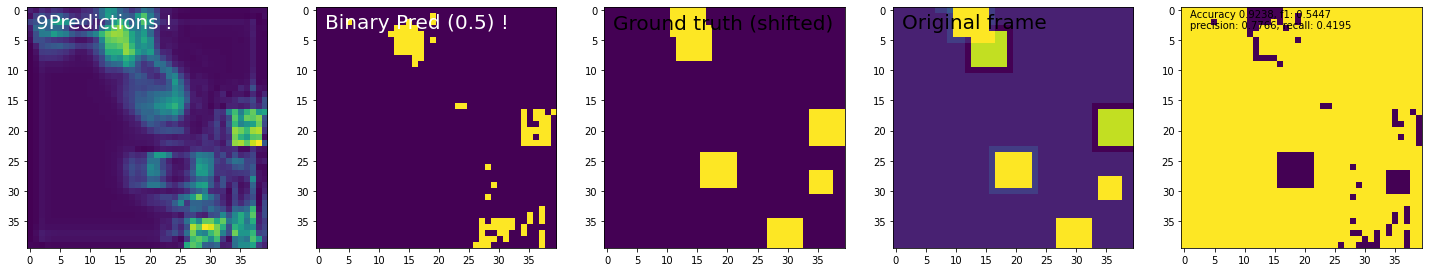

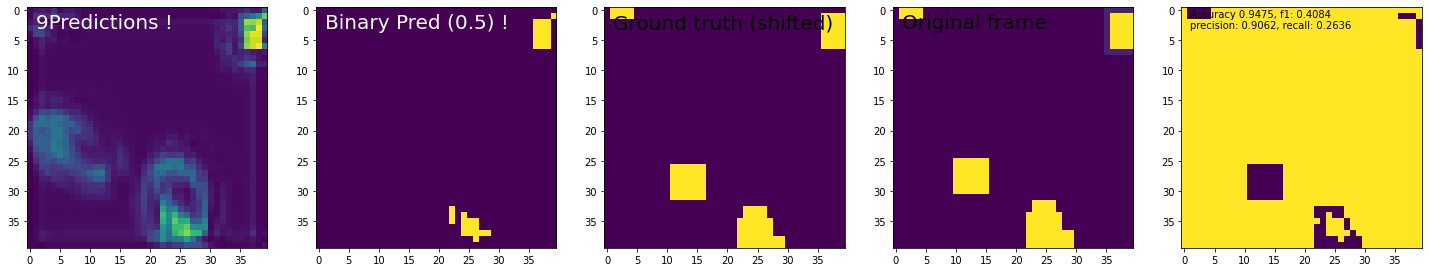

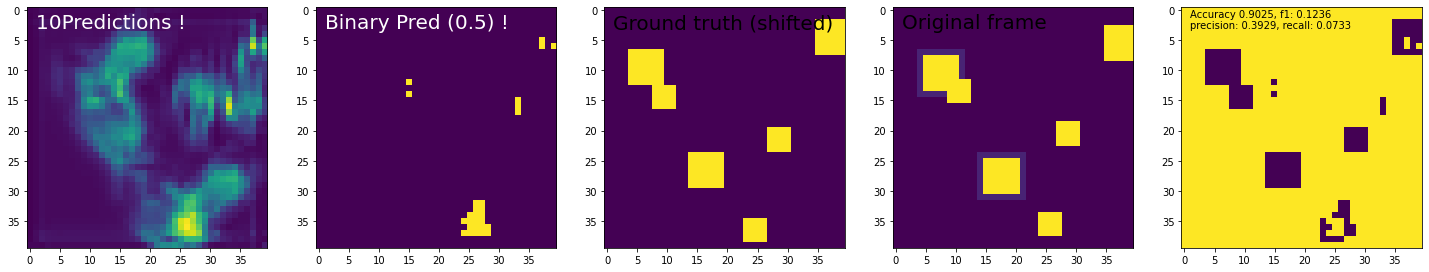

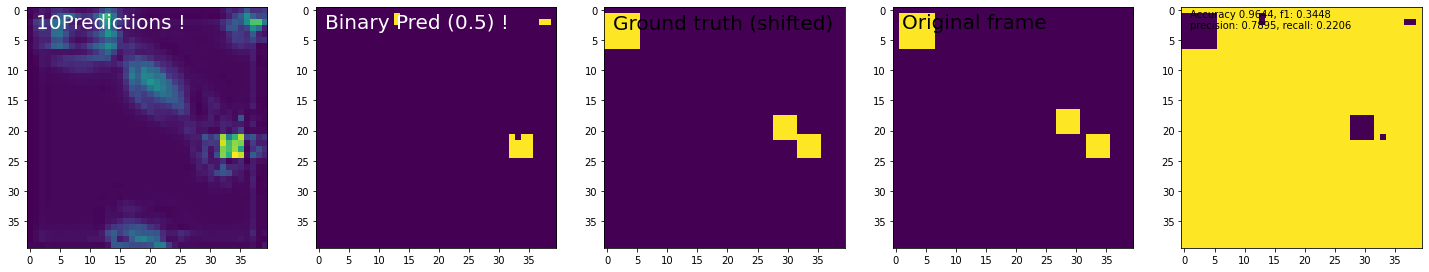

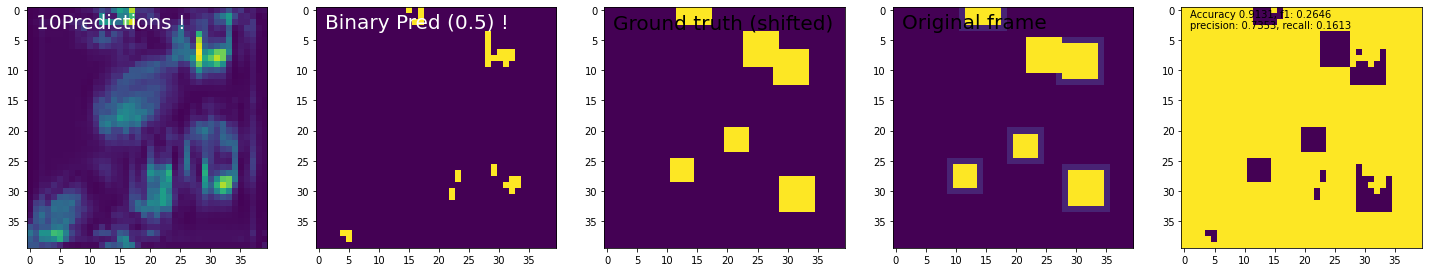

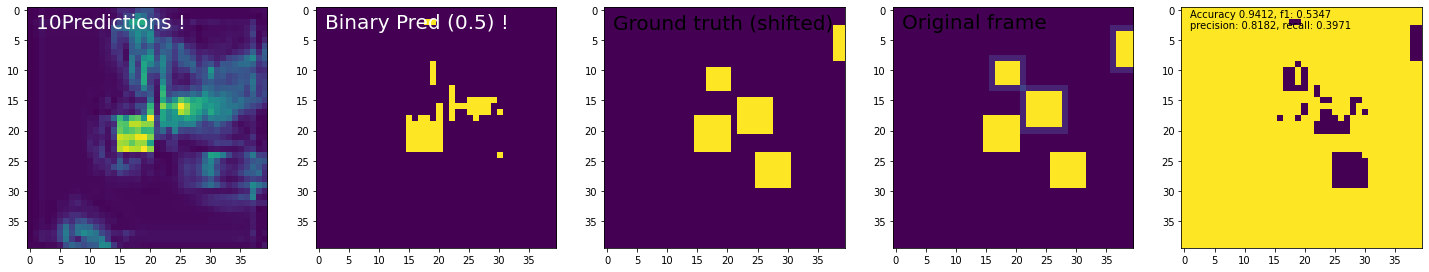

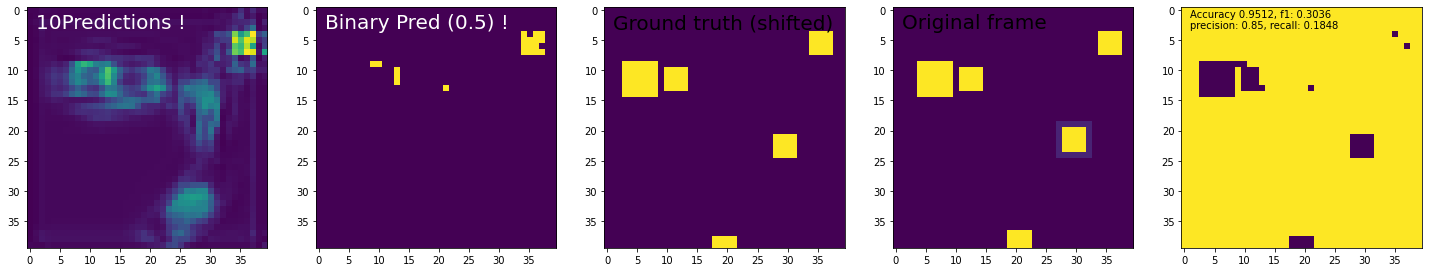

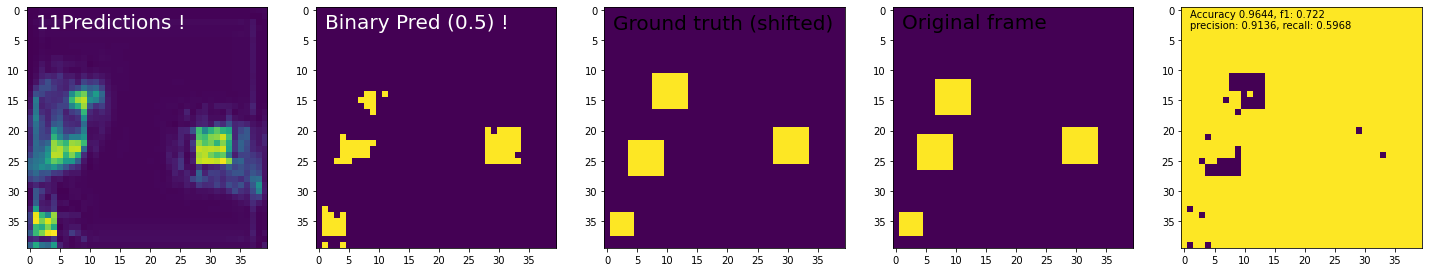

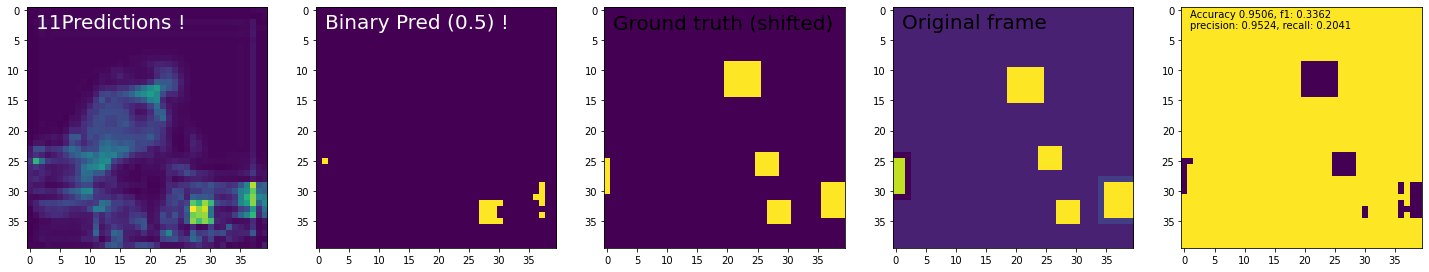

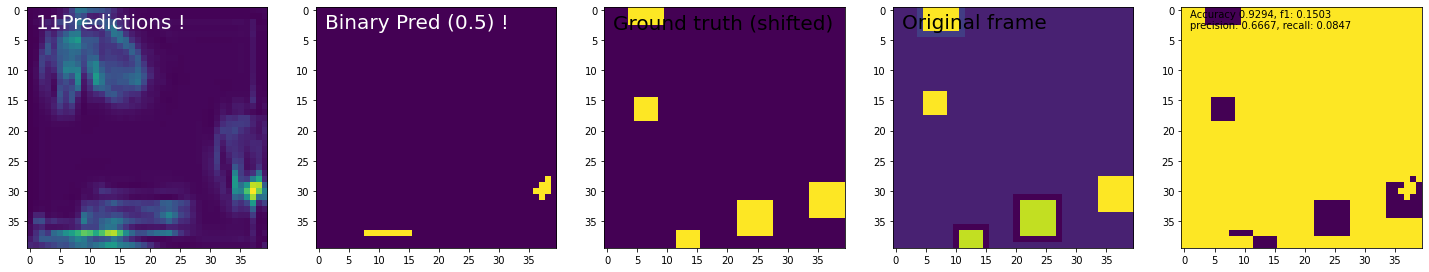

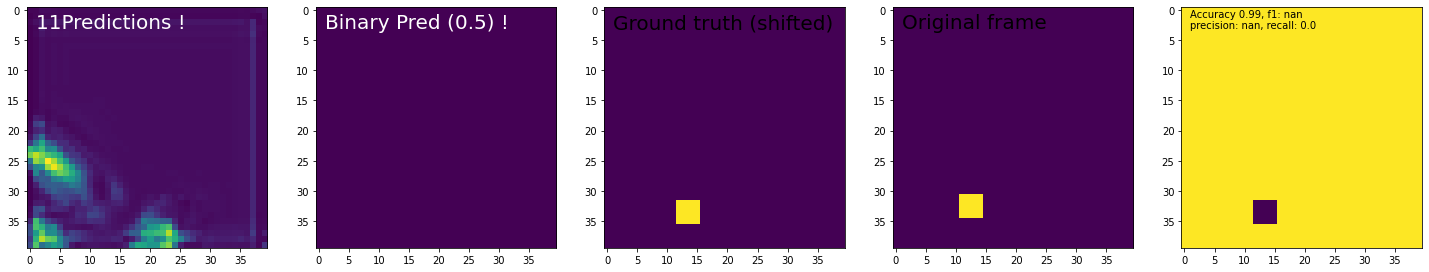

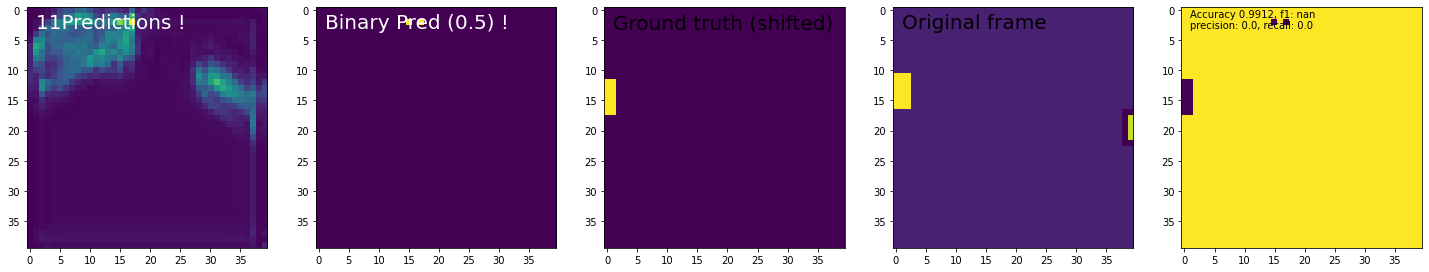

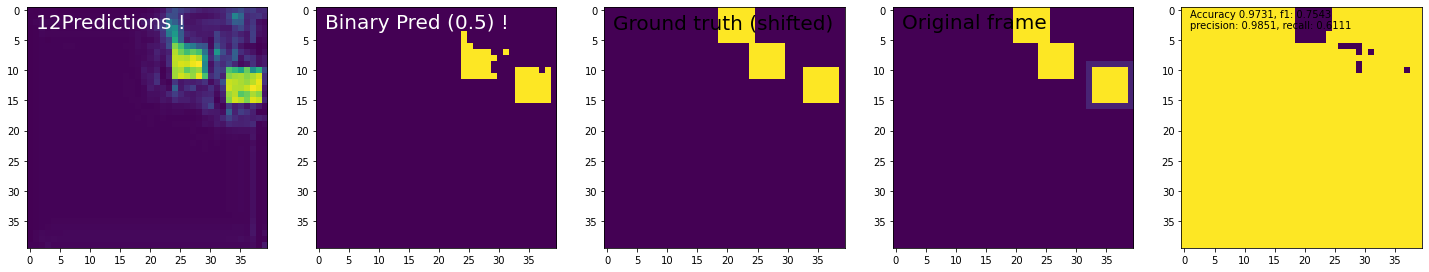

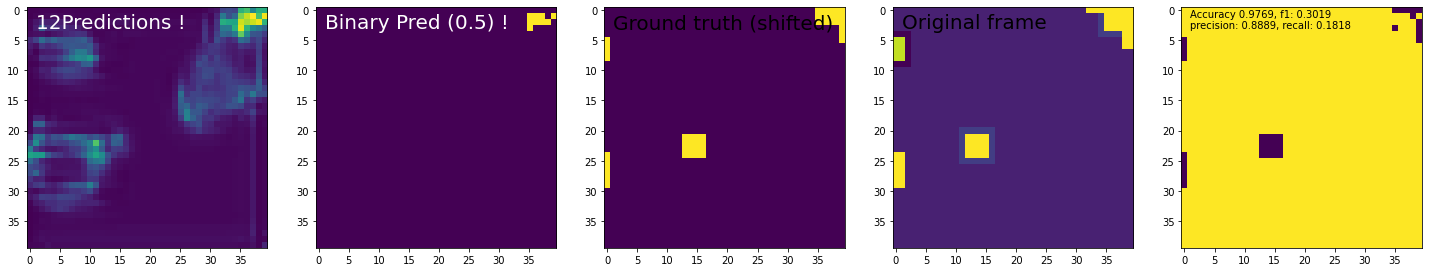

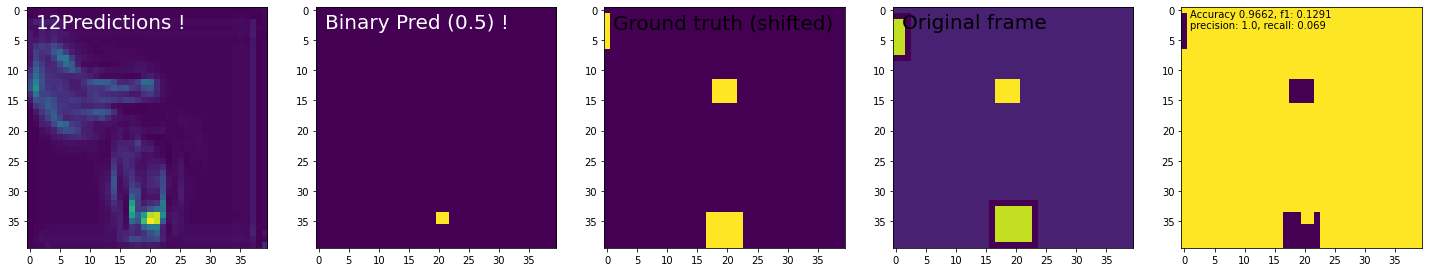

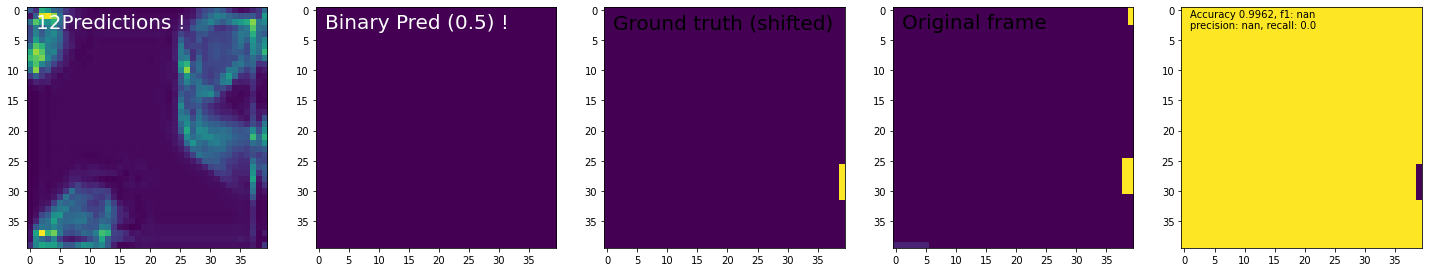

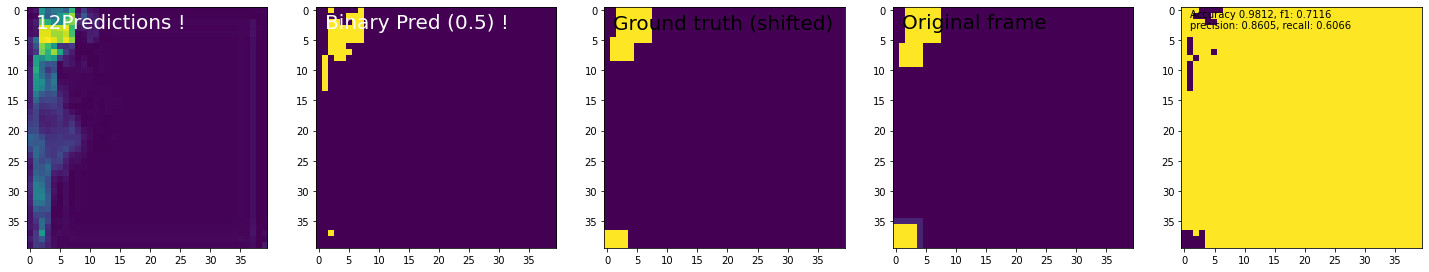

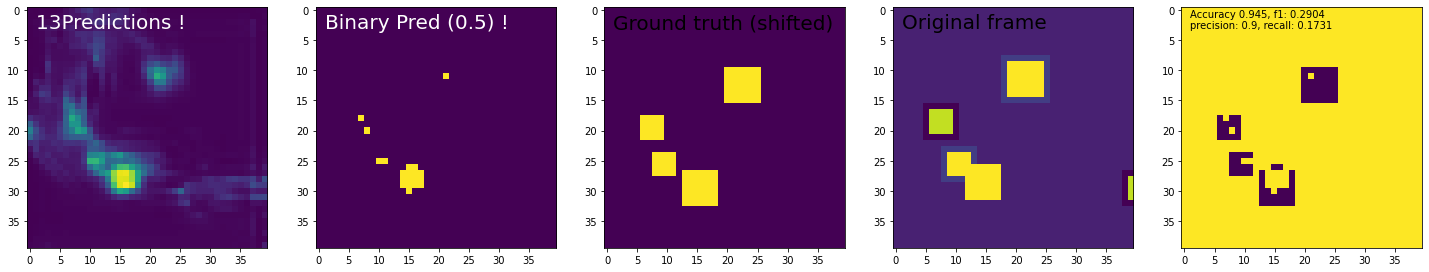

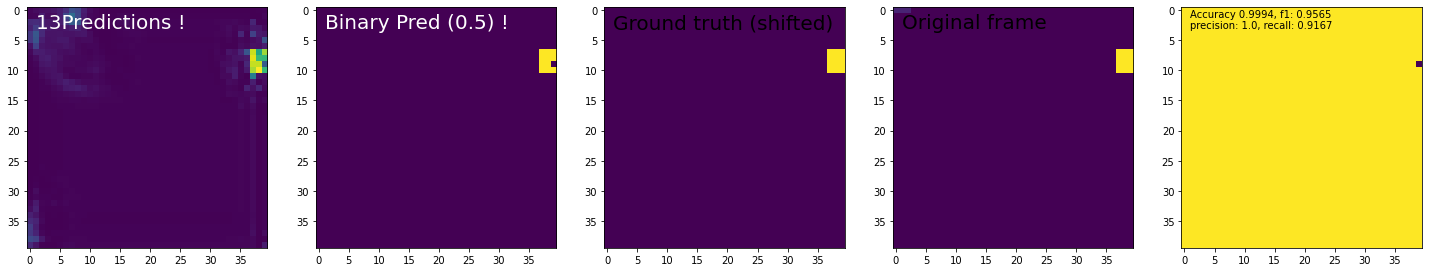

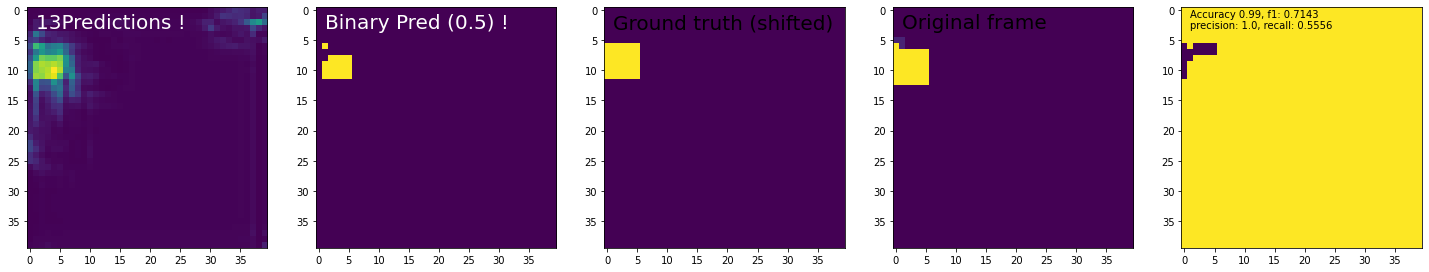

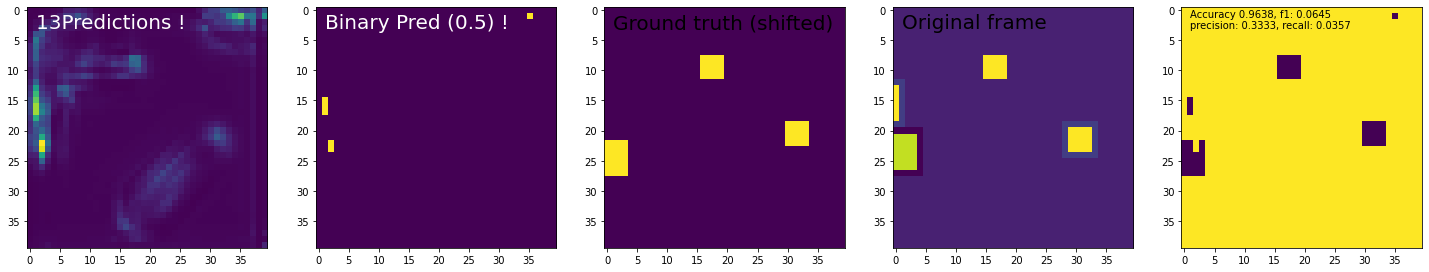

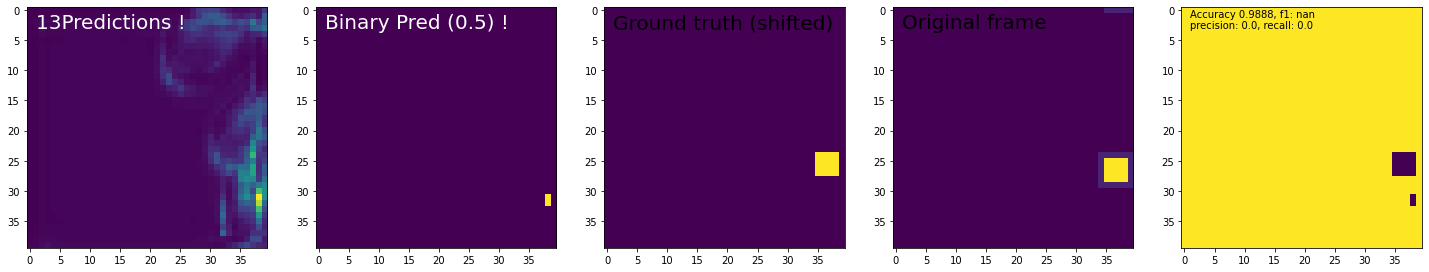

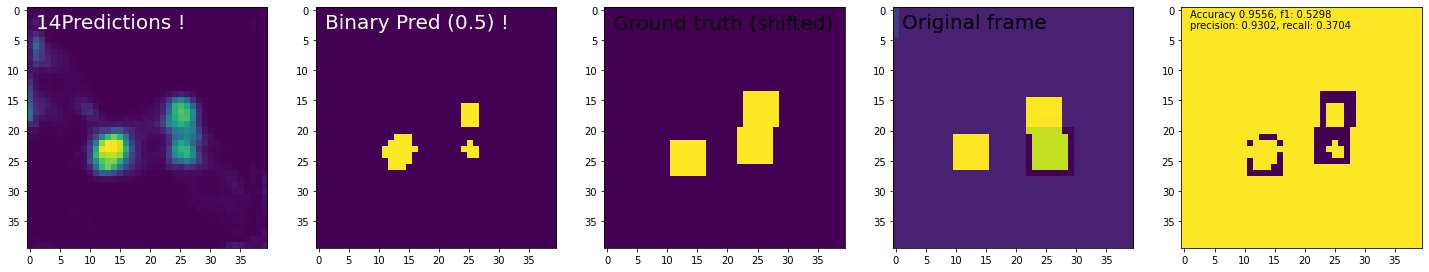

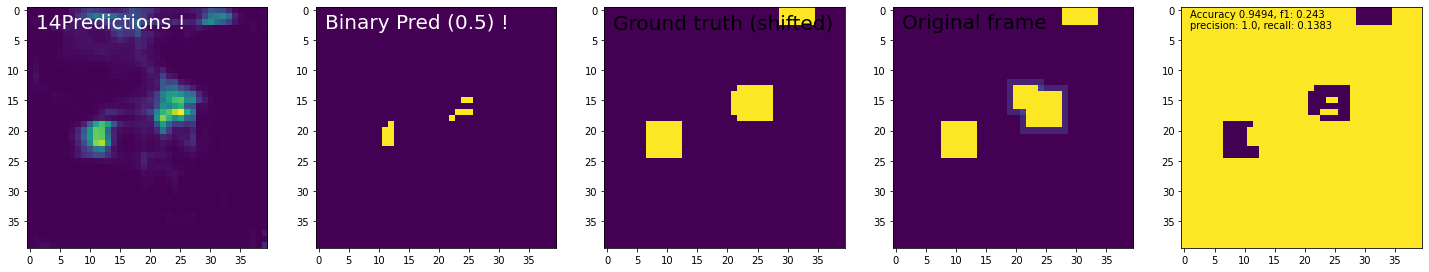

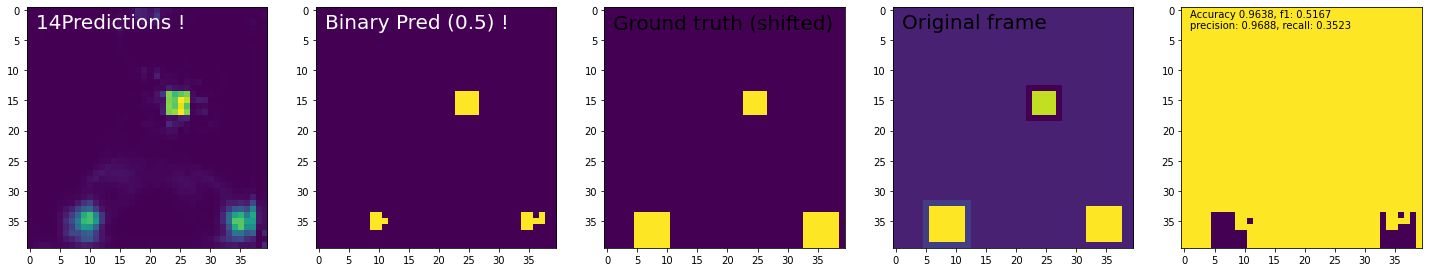

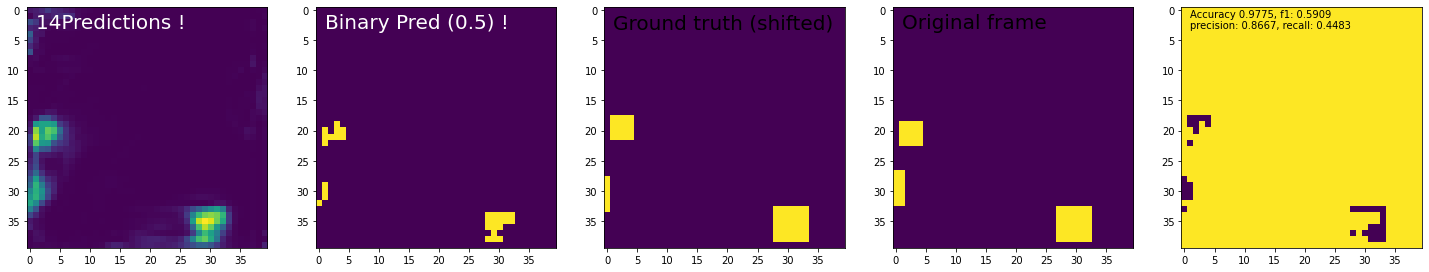

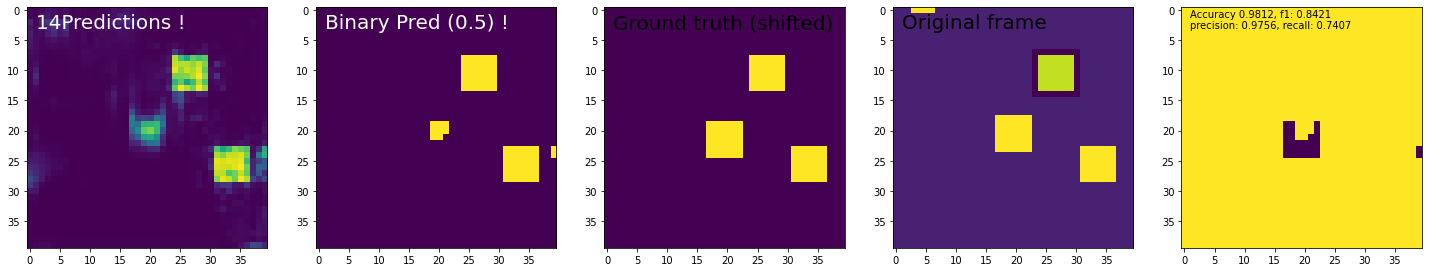

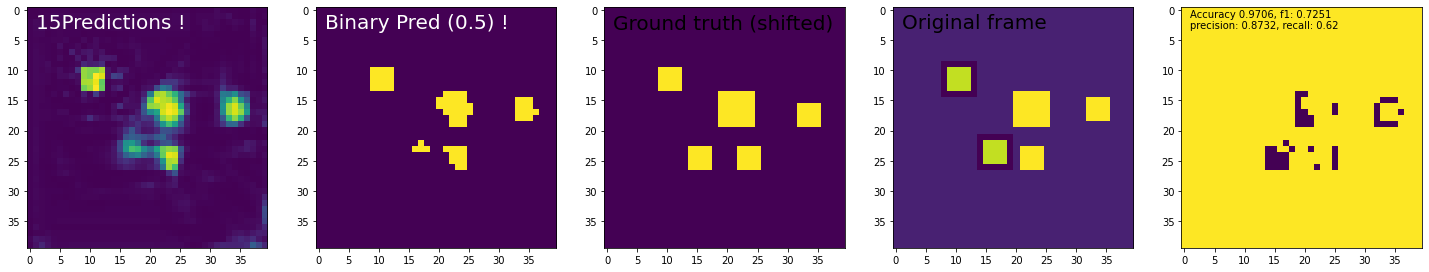

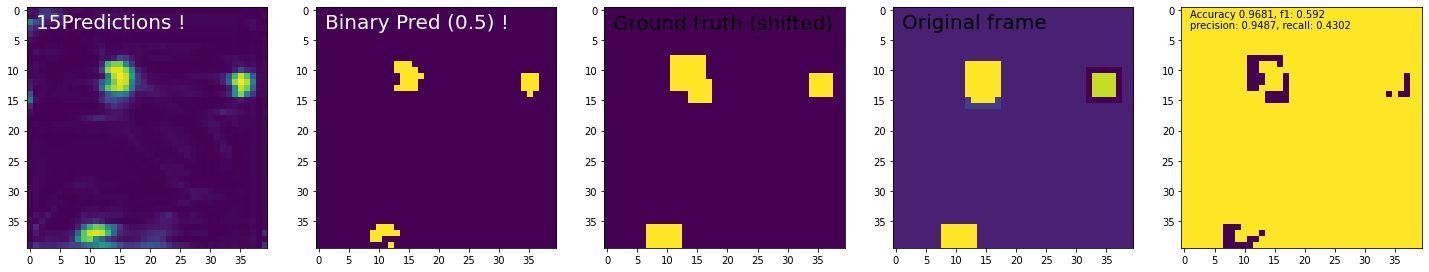

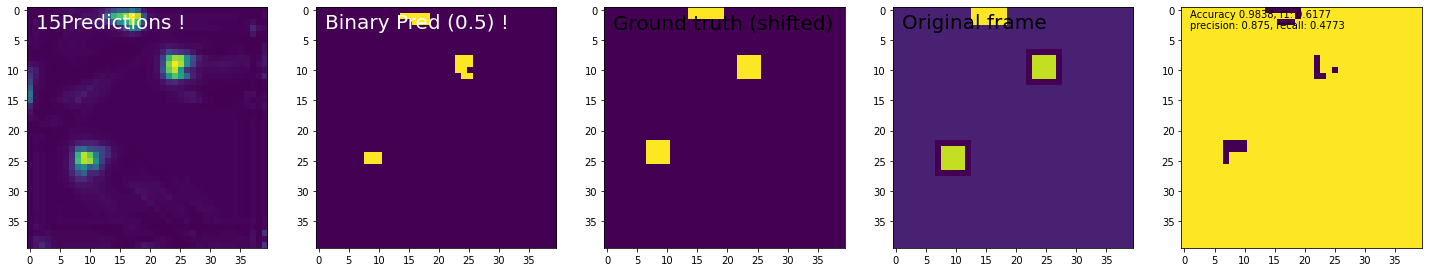

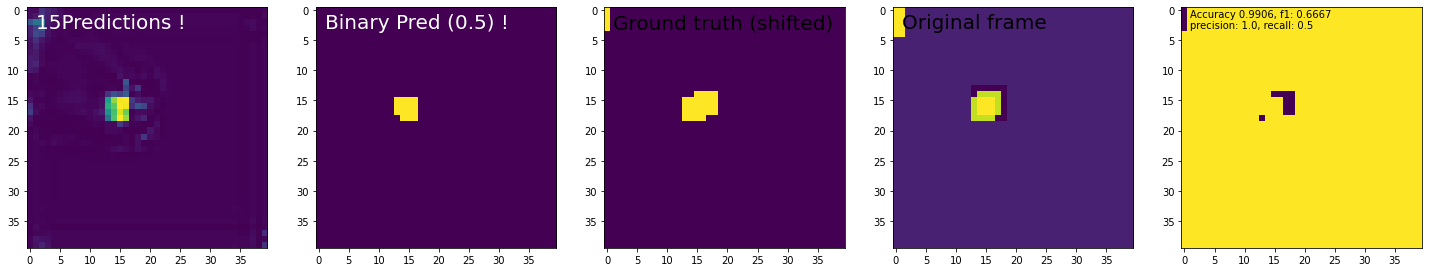

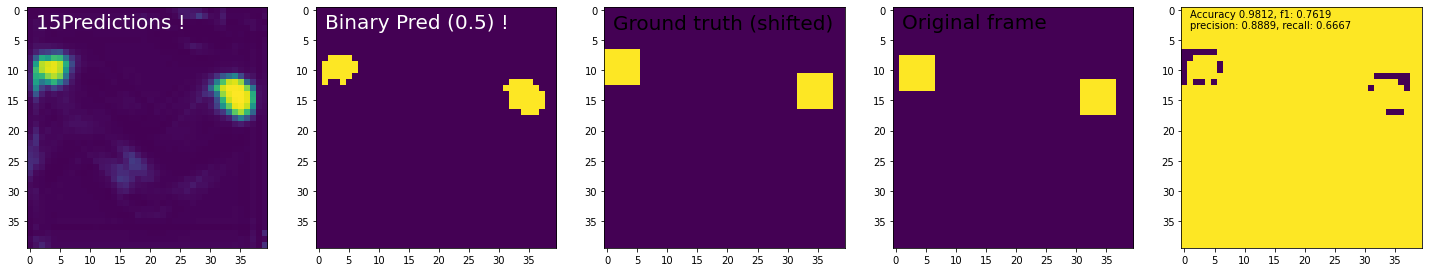

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  from ipykernel import kernelapp as app


accuracy  precision   recall        f1
n_frames                                        
1          0.91676        NaN  0.00000       NaN
2          0.91988   0.425020  0.19930  0.269880
3          0.91548   0.258560  0.32288  0.281980
4          0.89676   0.371240  0.47424  0.413020
5          0.90776   0.296740  0.36068  0.318600
6          0.89292   0.150880  0.11642  0.130060
7          0.92288   0.193280  0.21798  0.200300
8          0.94586   0.356100  0.25432  0.295080
9          0.94678   0.336560  0.13662  0.476550
10         0.93448   0.717180  0.20742  0.314260
11         0.96512   0.633175  0.17712  0.402833
12         0.97872   0.933625  0.29370  0.474225
13         0.97740   0.646660  0.33622  0.506425
14         0.96550   0.948260  0.41000  0.544500
15         0.97886   0.917160  0.53884  0.672680

In [ ]:
dfList = []

for len_movie in range(1, 16):
  for execIdx in range(5):
    # print(len_movie, execIdx)
    noisy, shifted = generate_movies(n_samples=1, n_frames=len_movie)
    pred = seq.predict(noisy)
    df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], title=str(len_movie), binarize_threshold=0.5)
    plt.show()
    df.loc[:, 'n_frames'] = len_movie
    df.loc[:, 'idx'] = execIdx
    dfList.append(df)

perfDF = pd.concat(dfList)
perfDF.groupby('n_frames')['accuracy', 'precision', 'recall', 'f1'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


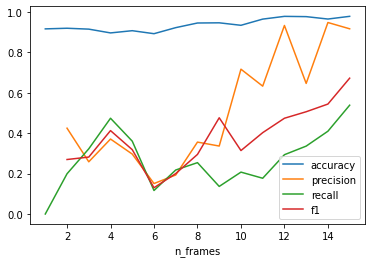

In [ ]:
perfDF.groupby('n_frames')['accuracy', 'precision', 'recall', 'f1'].mean().plot()

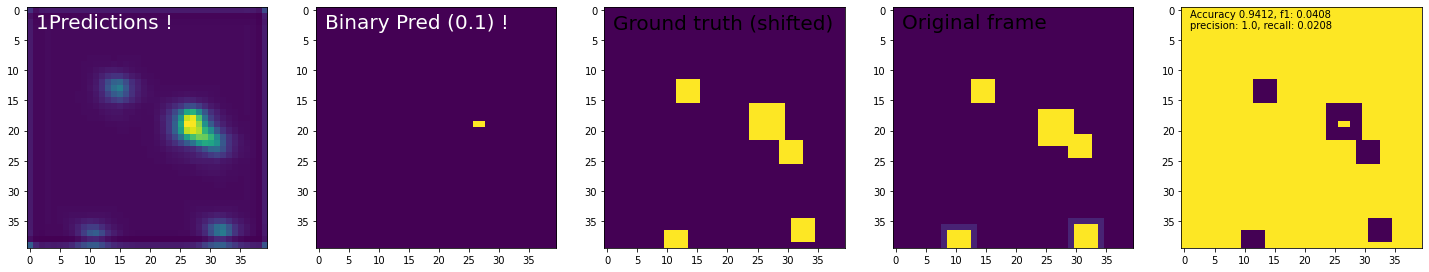

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in long_scalars


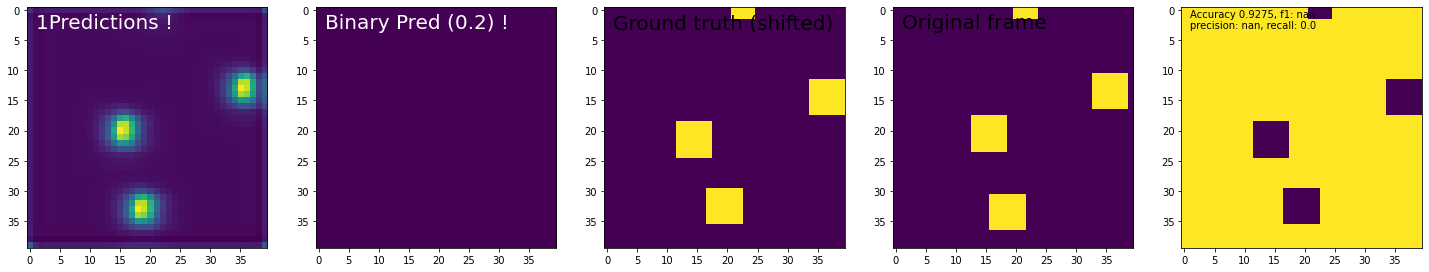

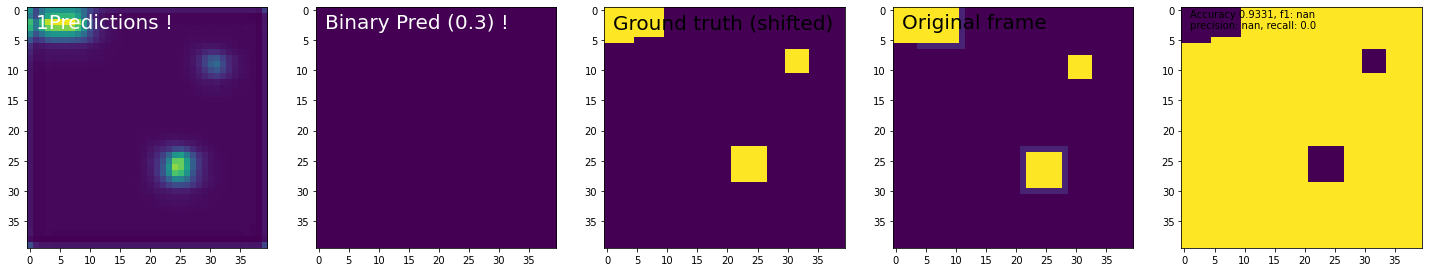

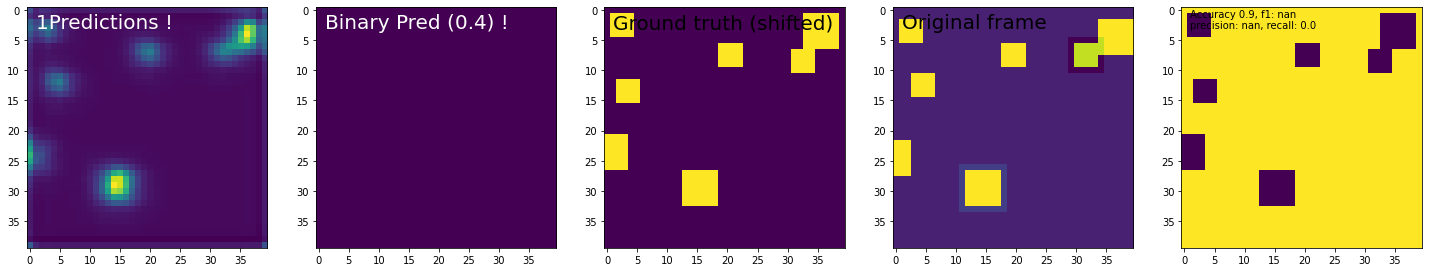

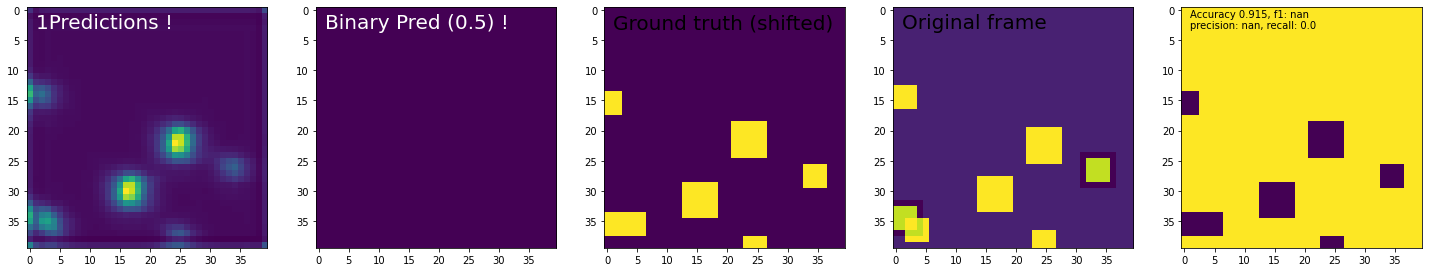

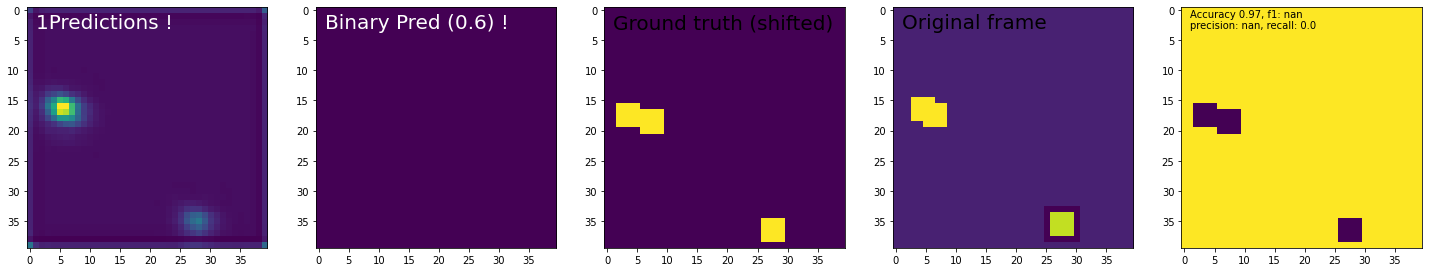

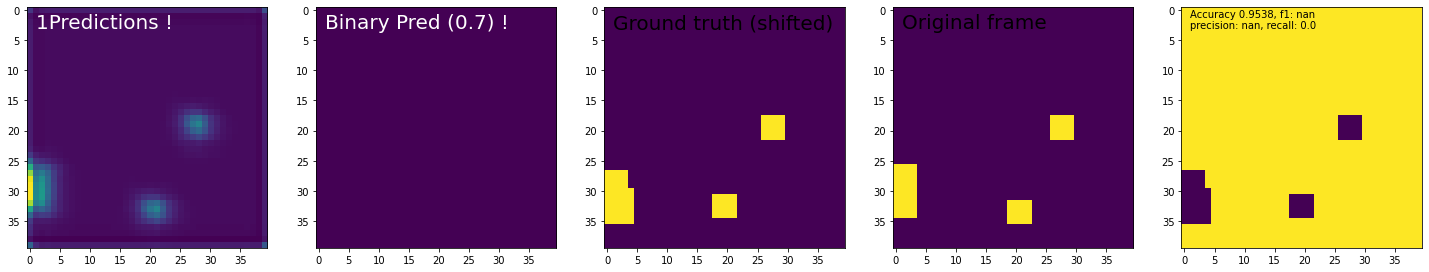

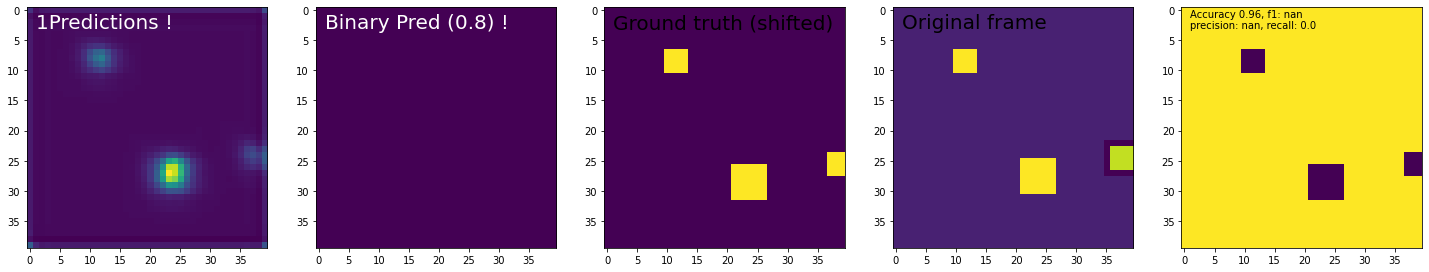

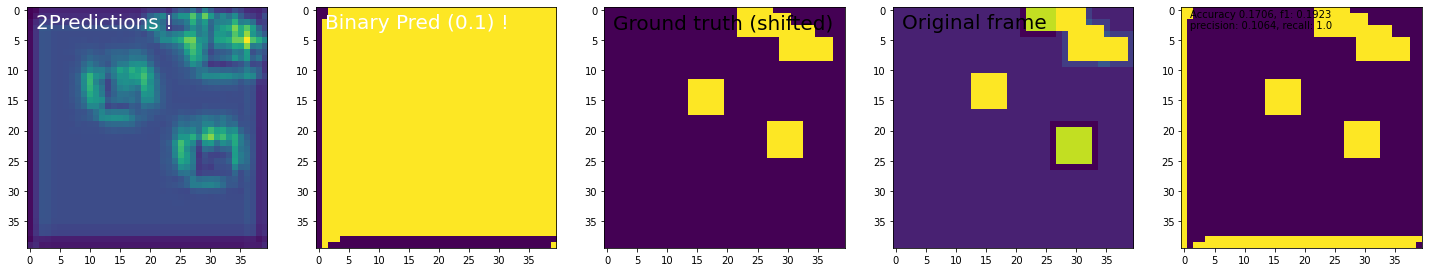

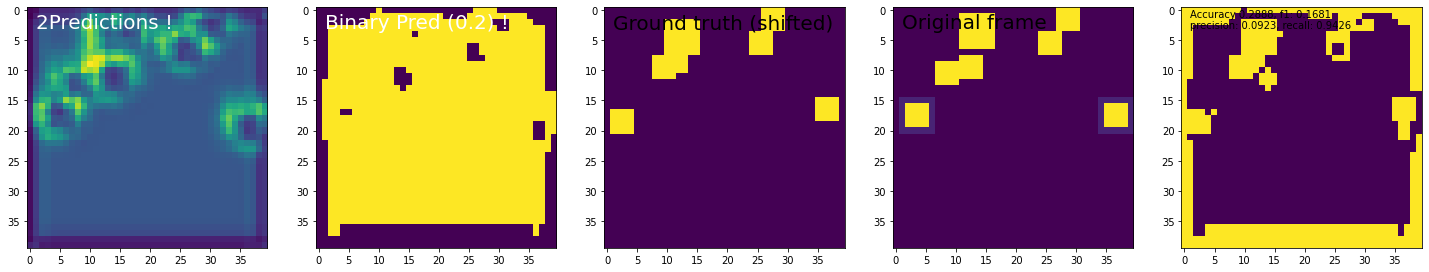

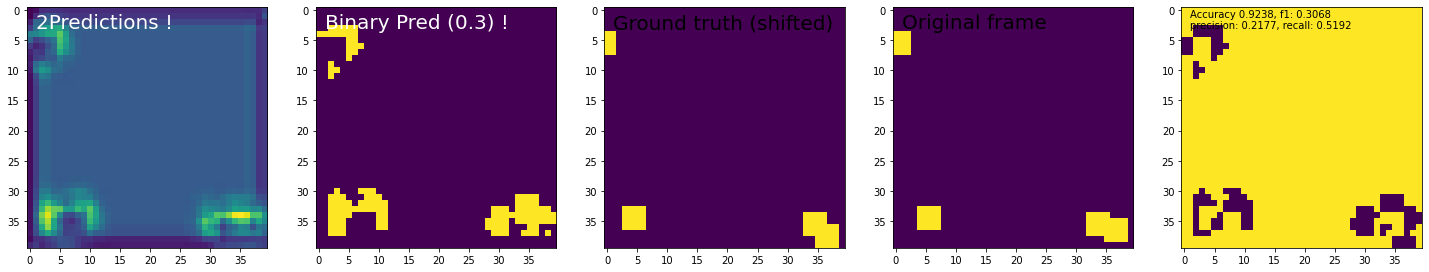

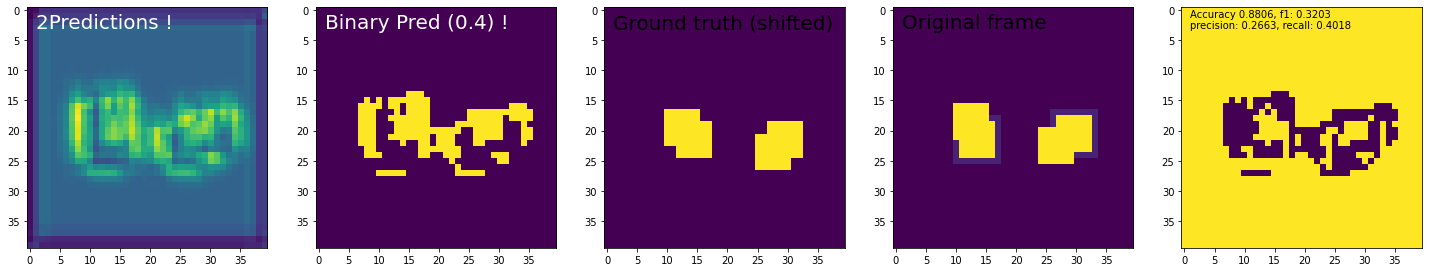

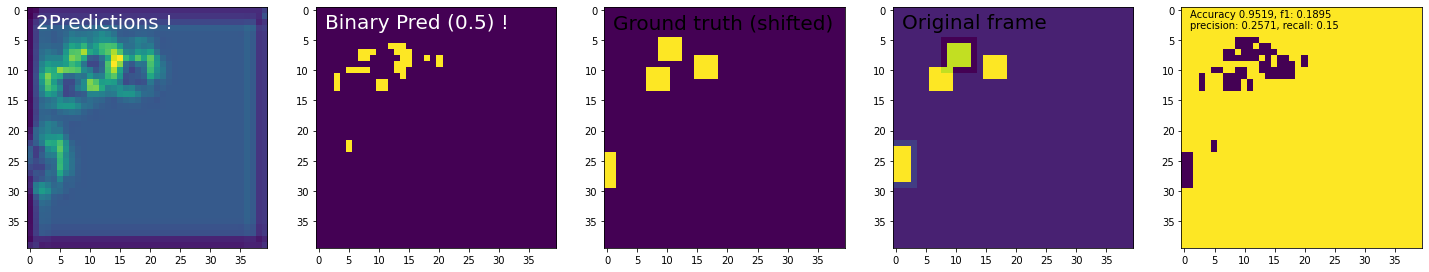

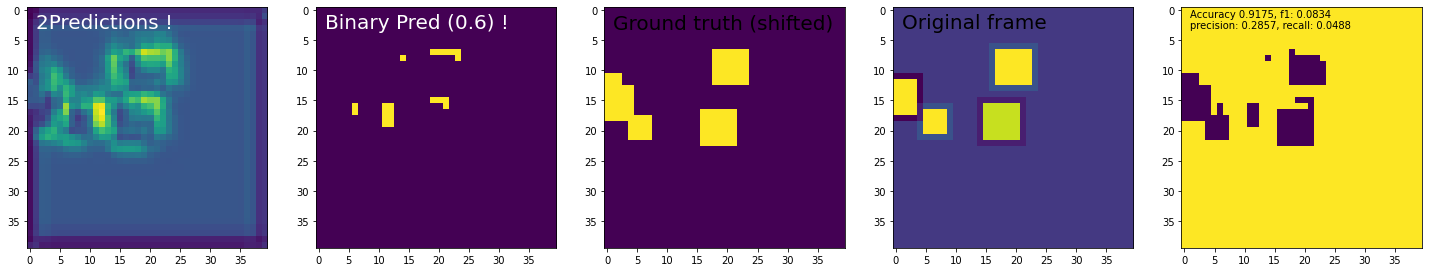

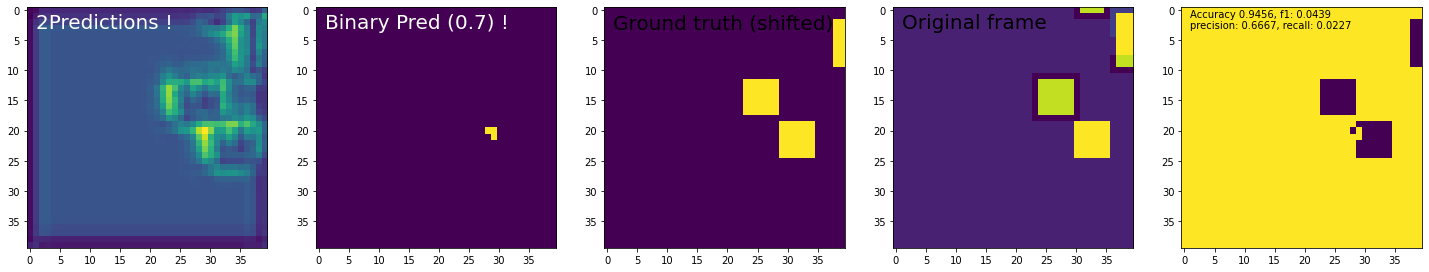

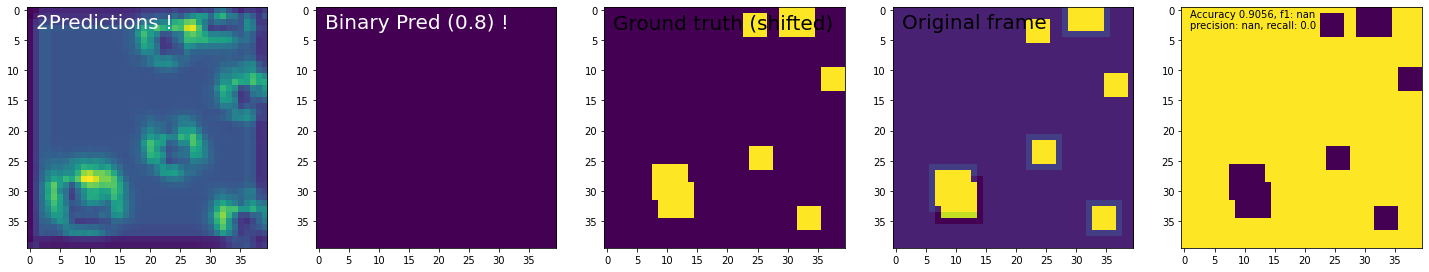

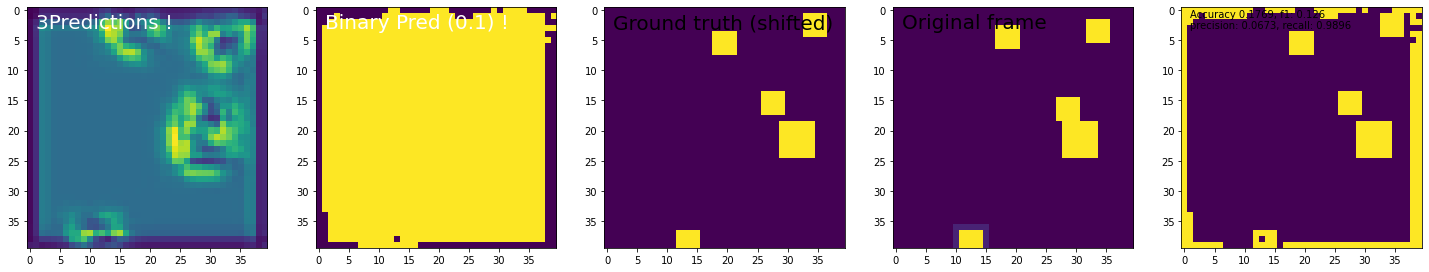

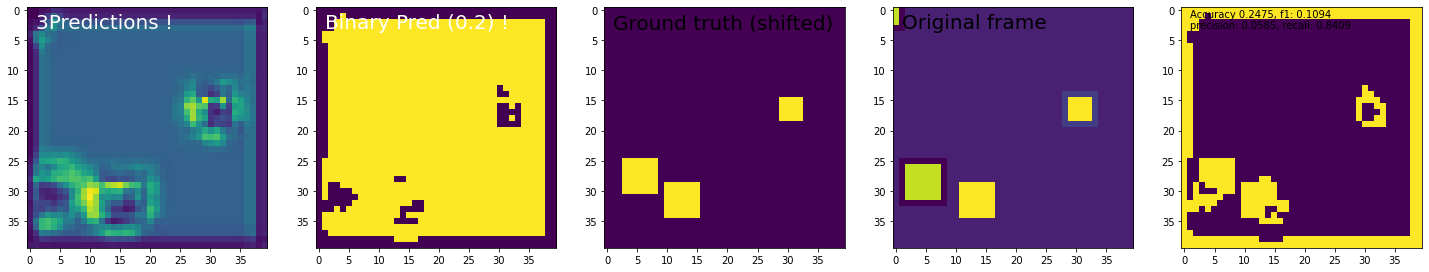

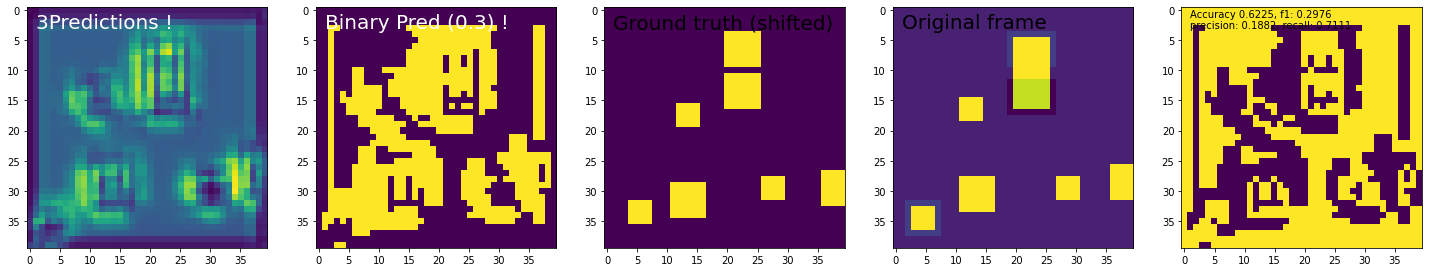

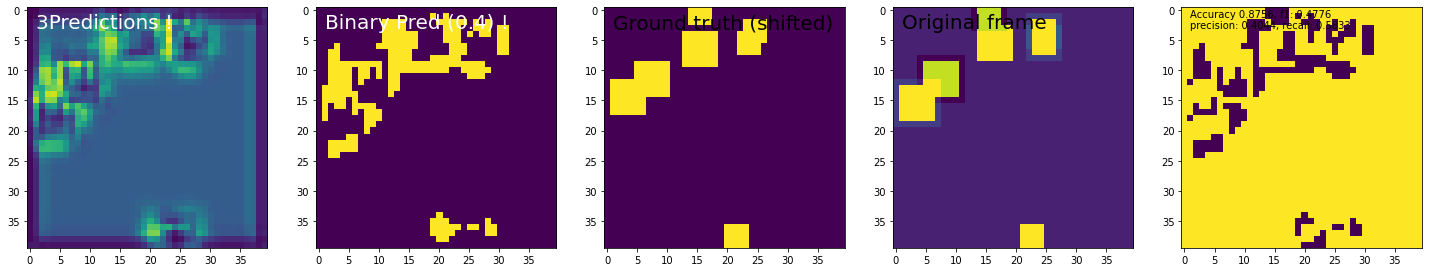

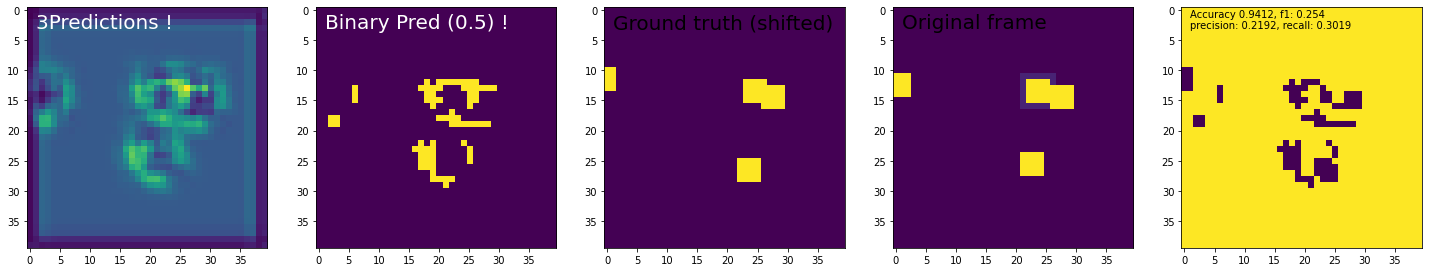

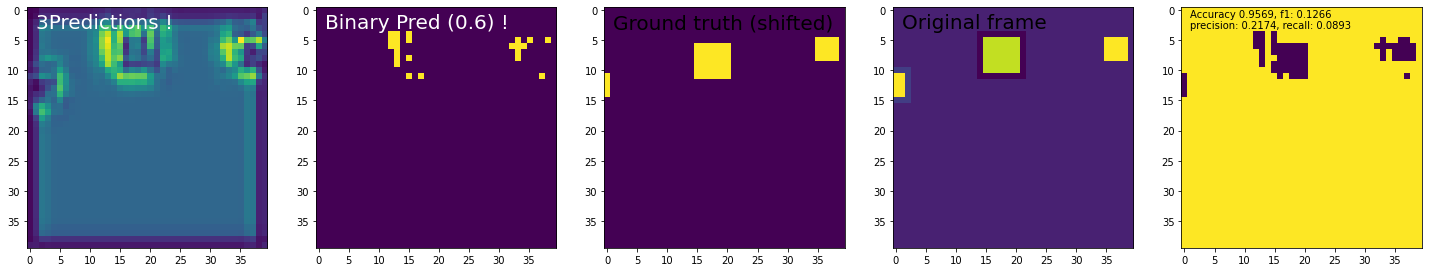

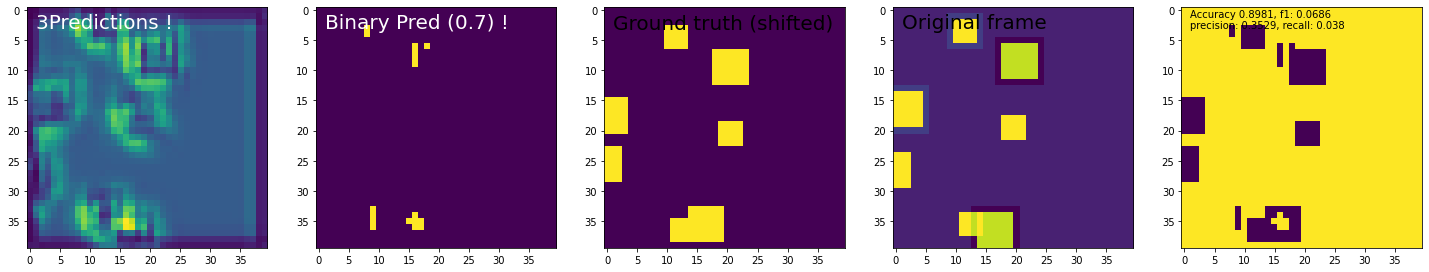

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


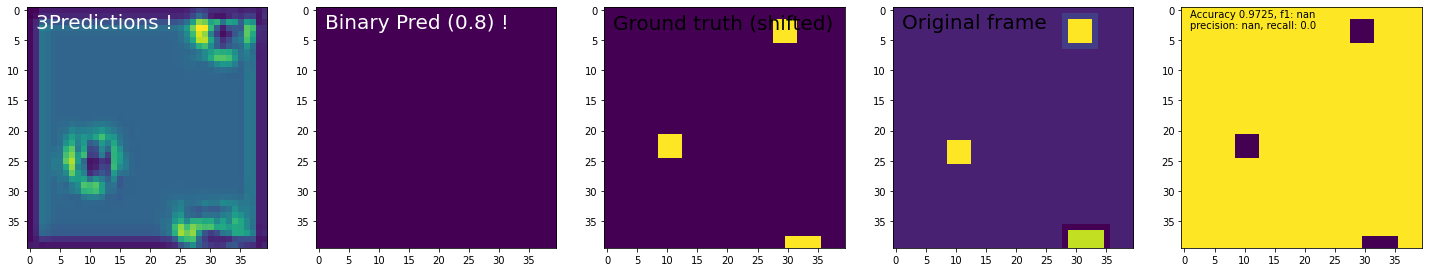

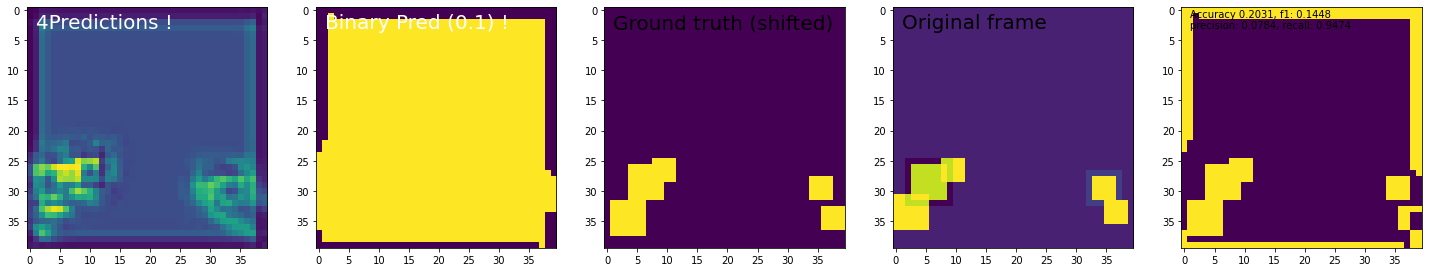

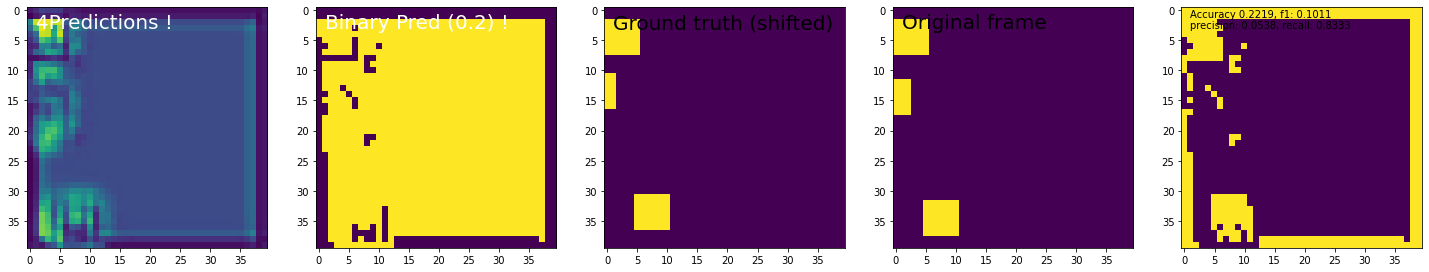

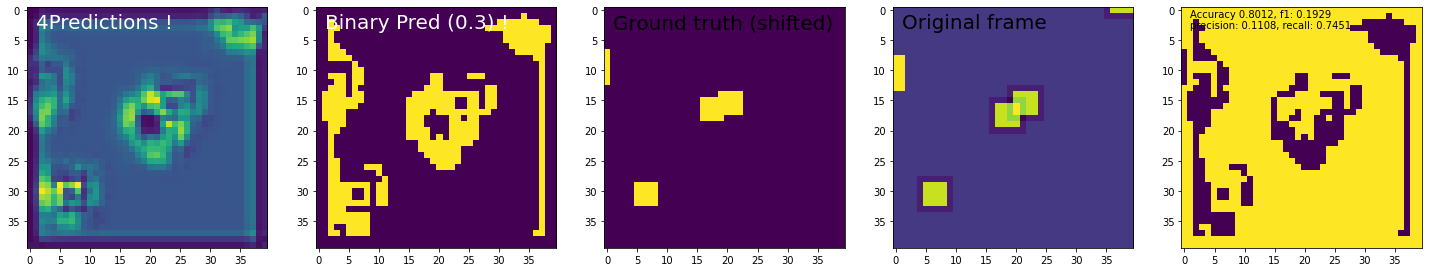

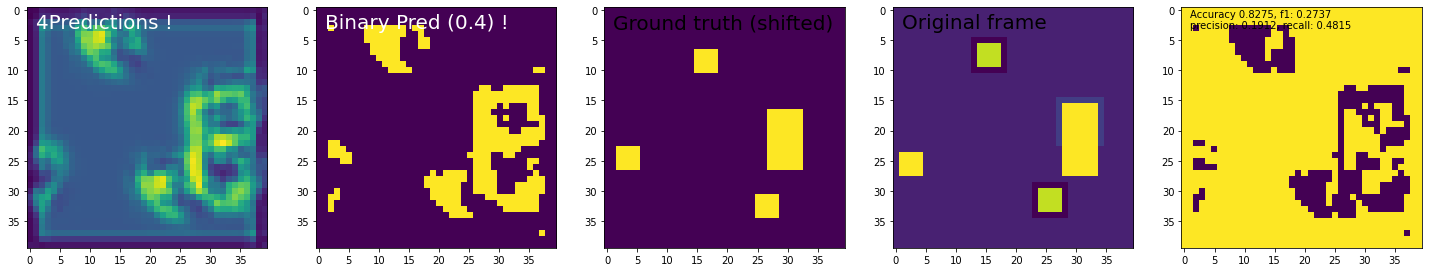

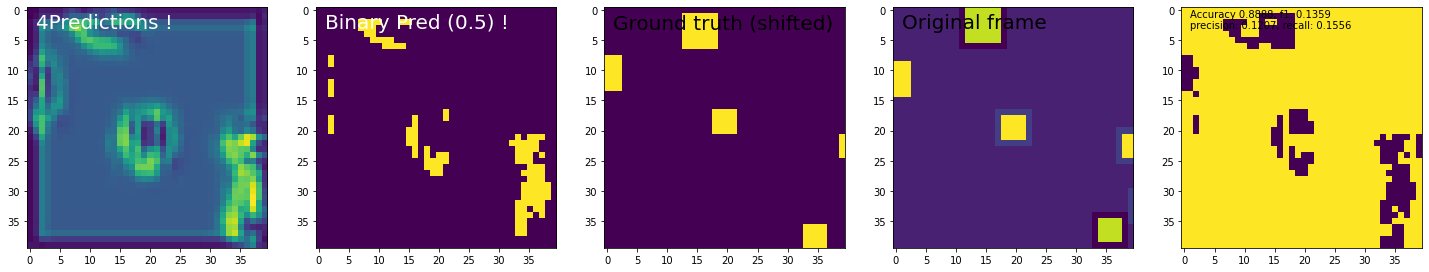

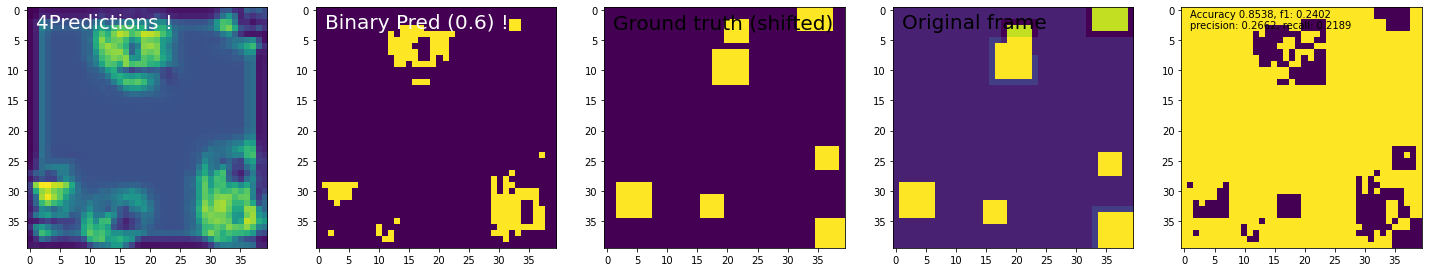

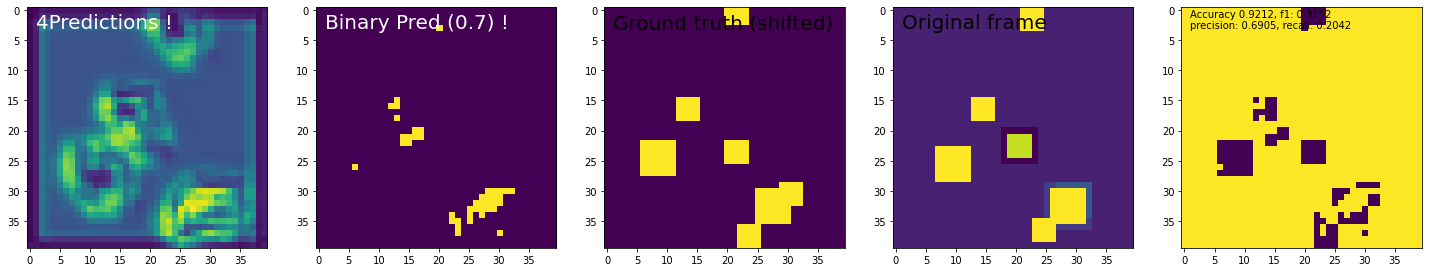

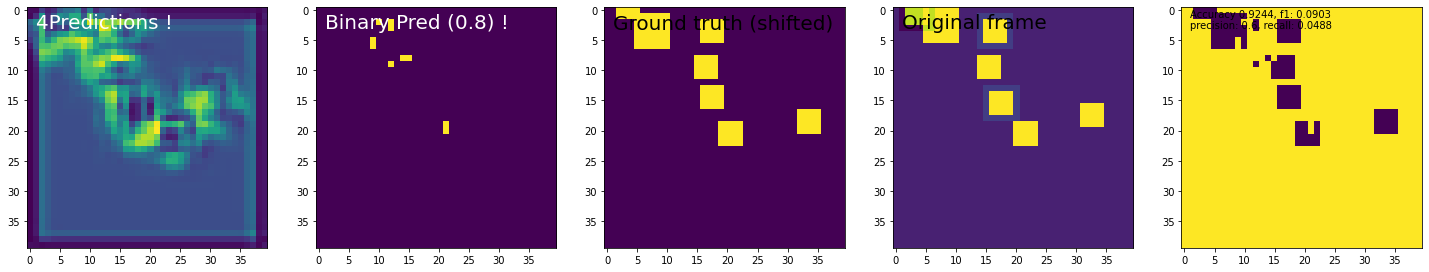

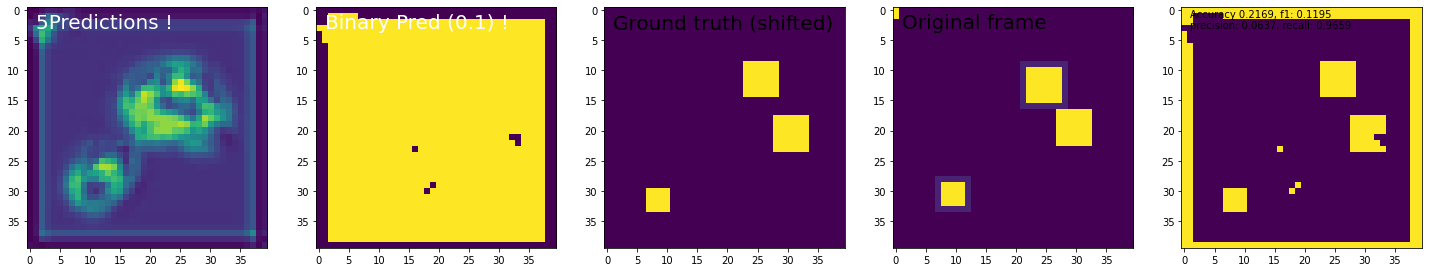

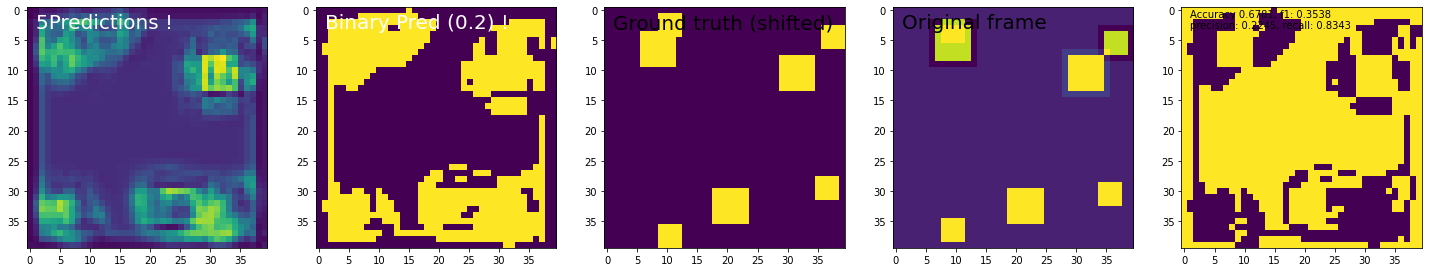

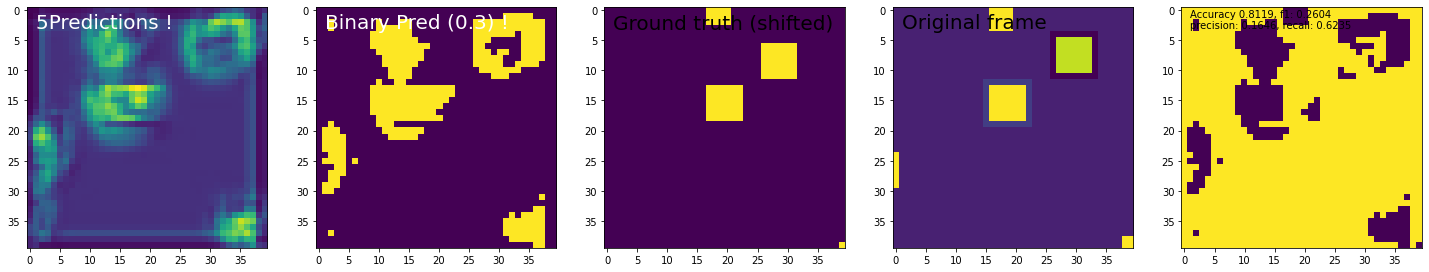

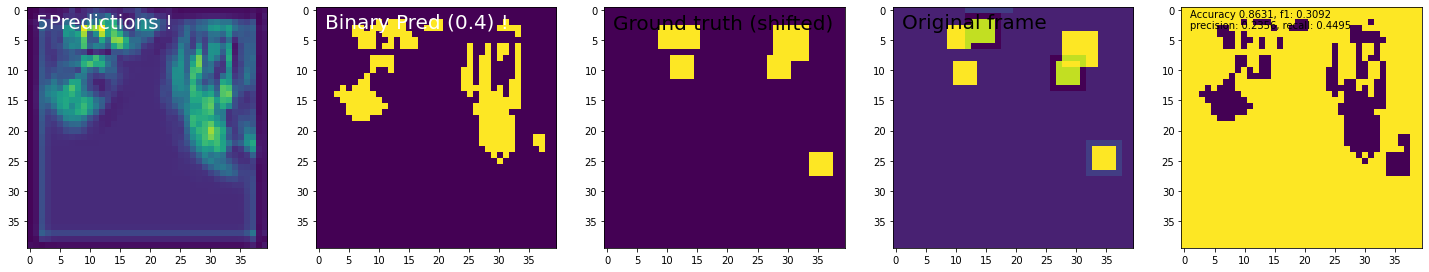

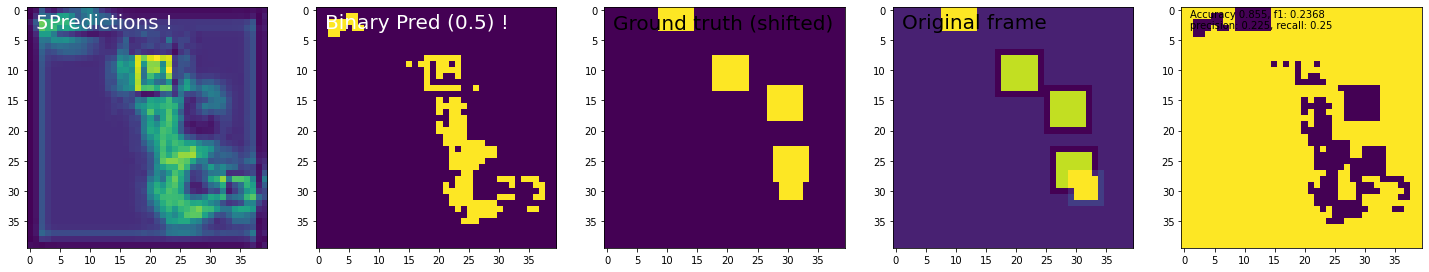

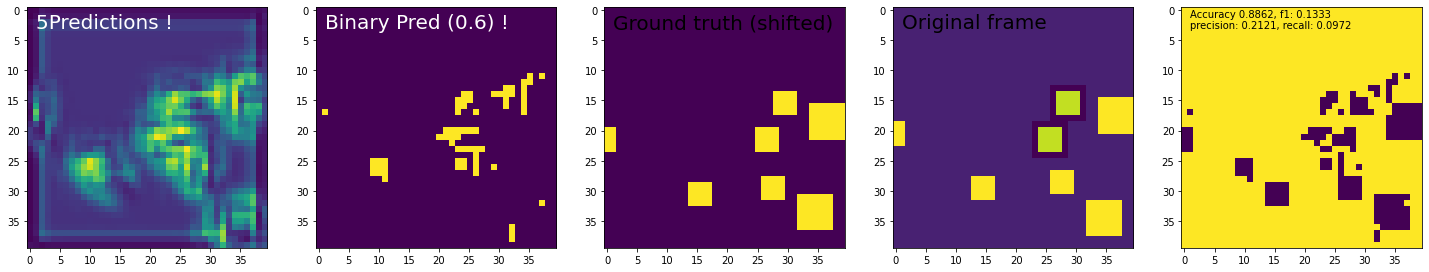

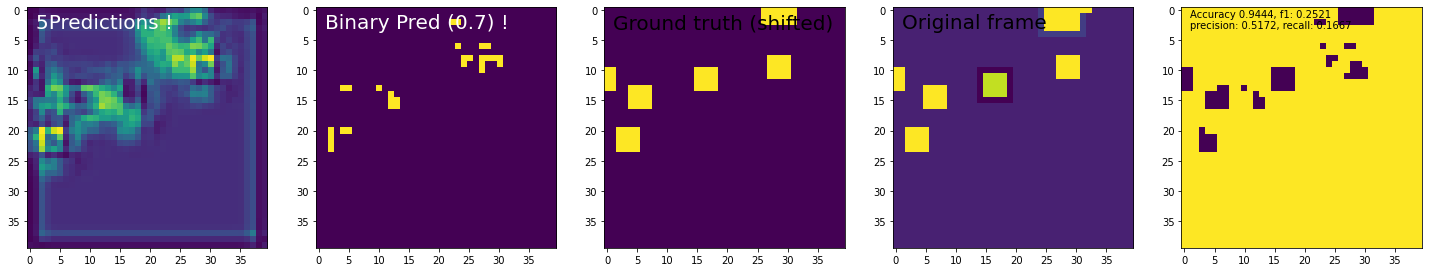

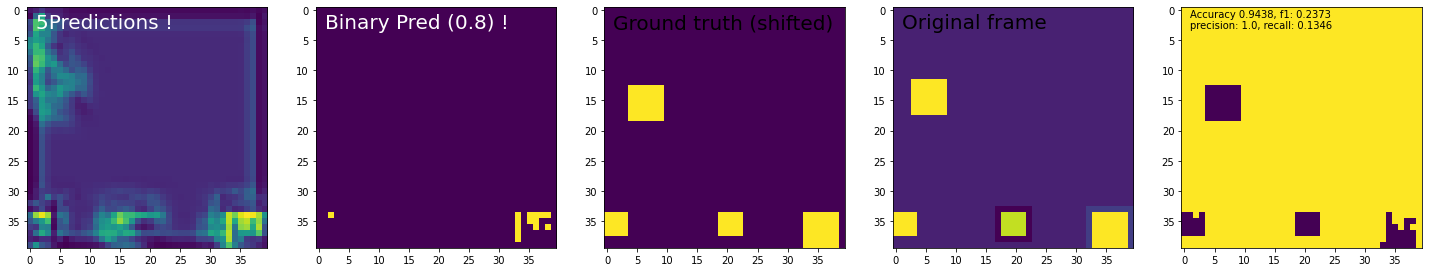

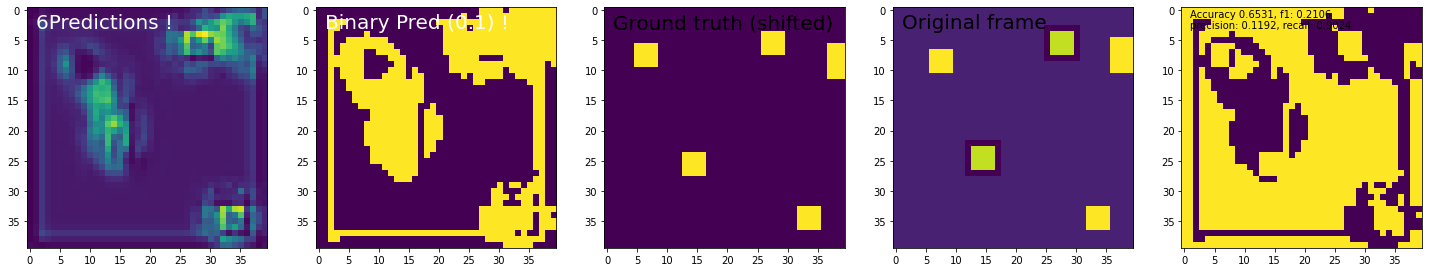

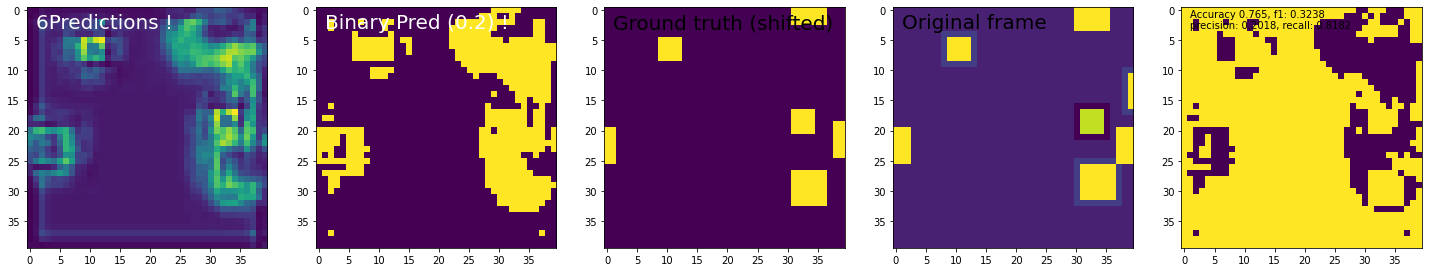

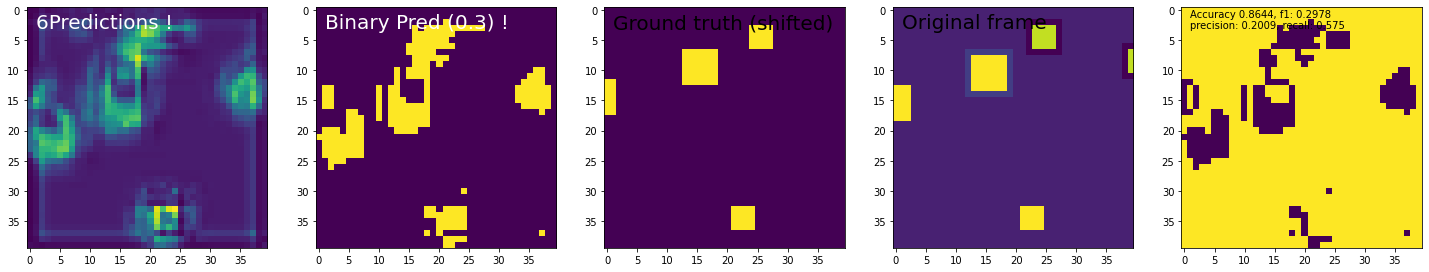

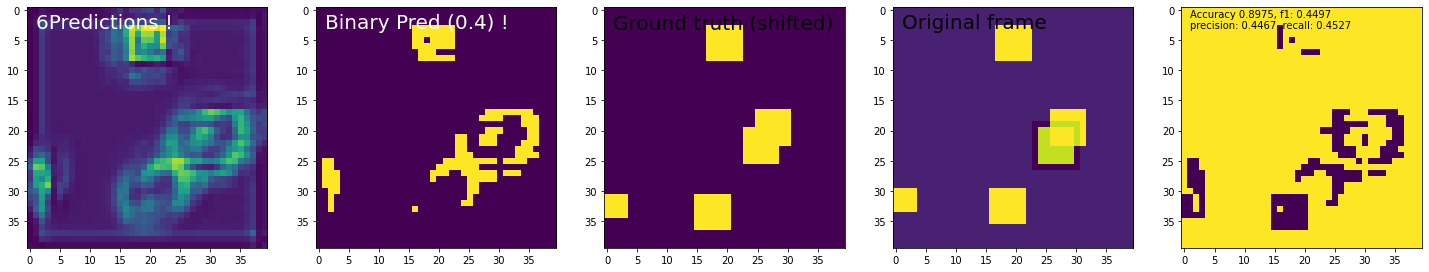

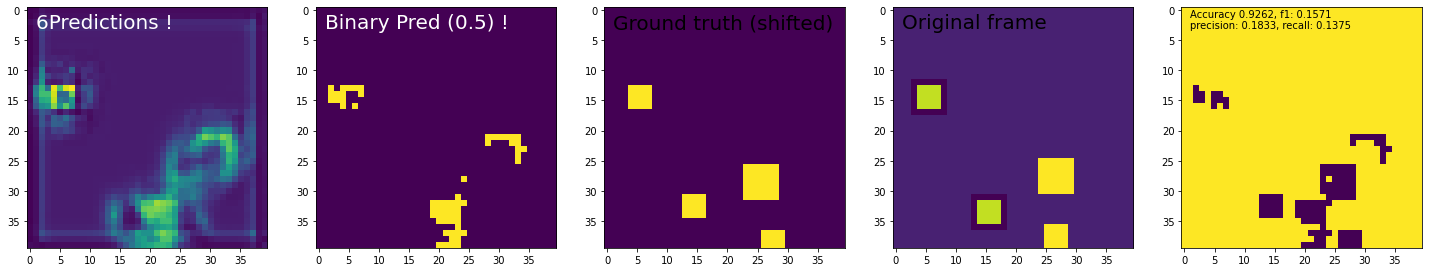

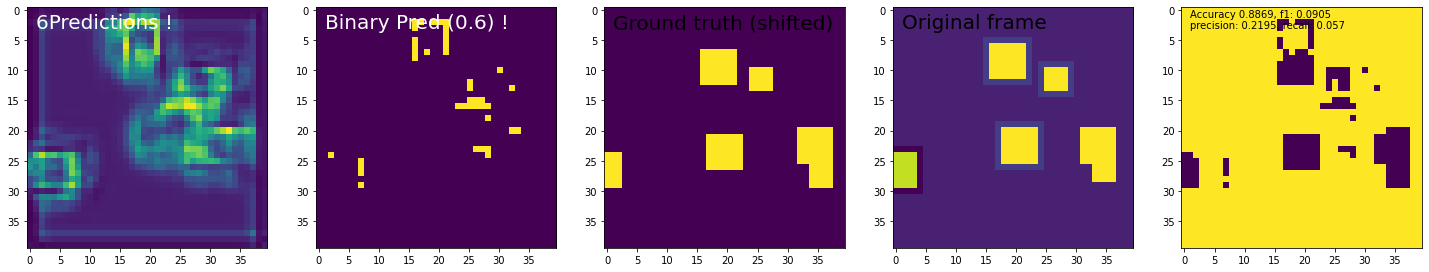

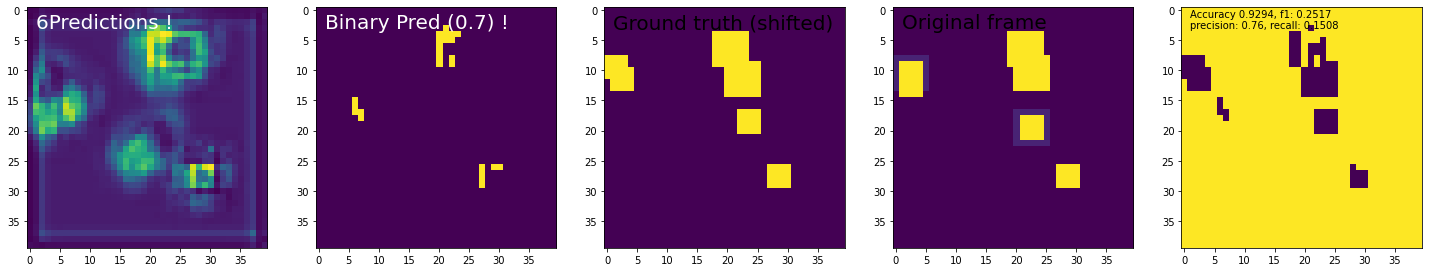

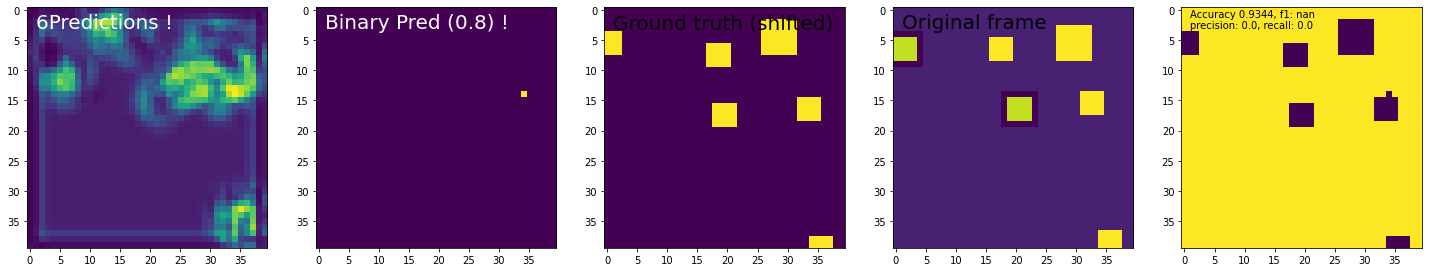

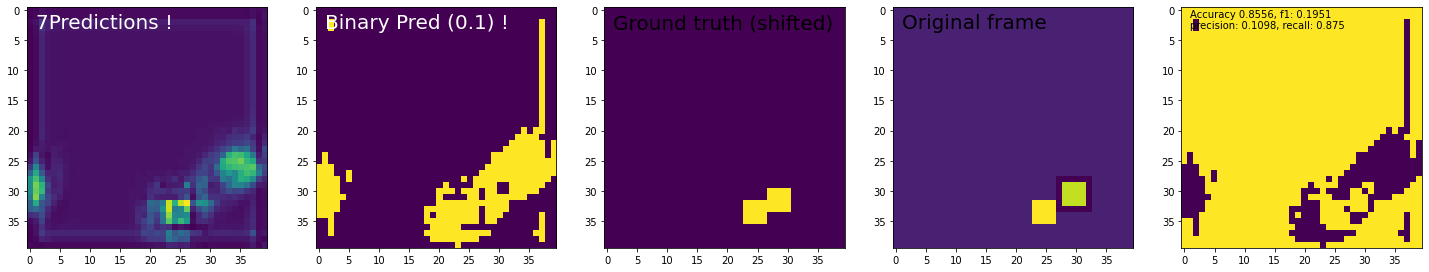

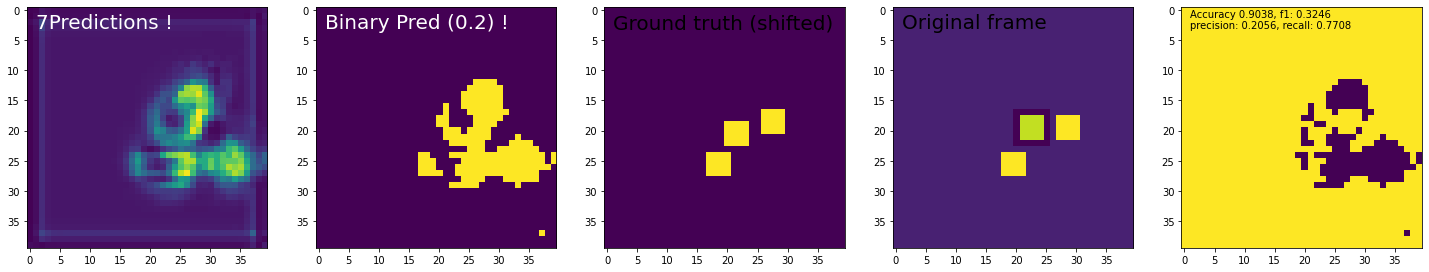

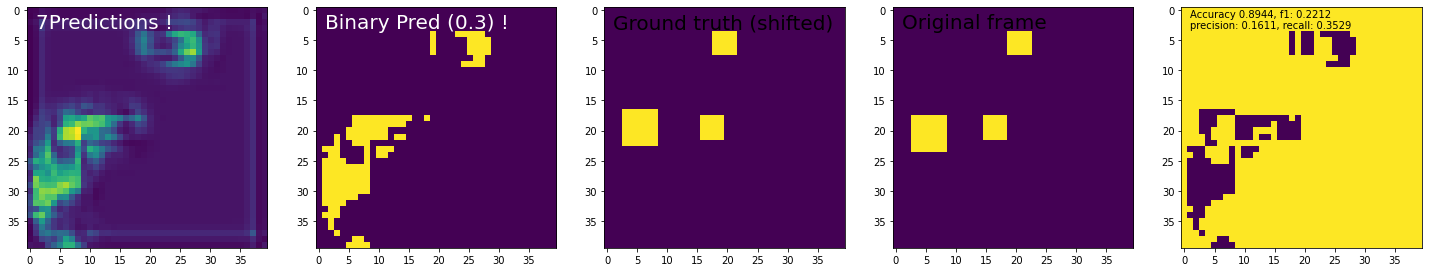

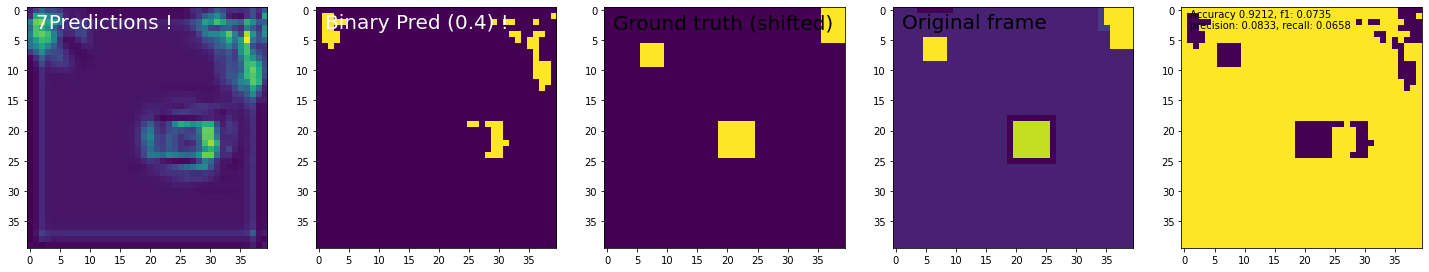

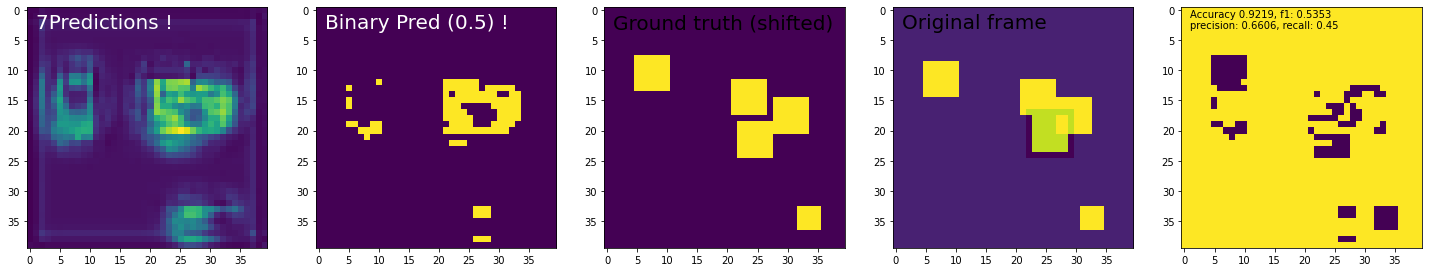

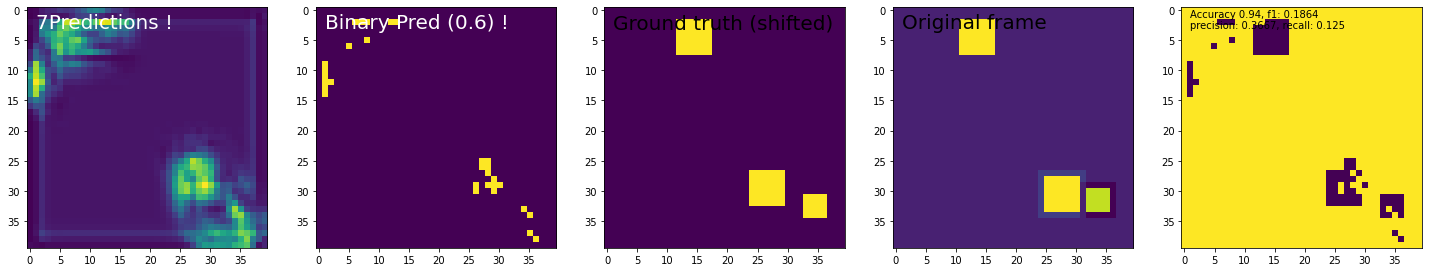

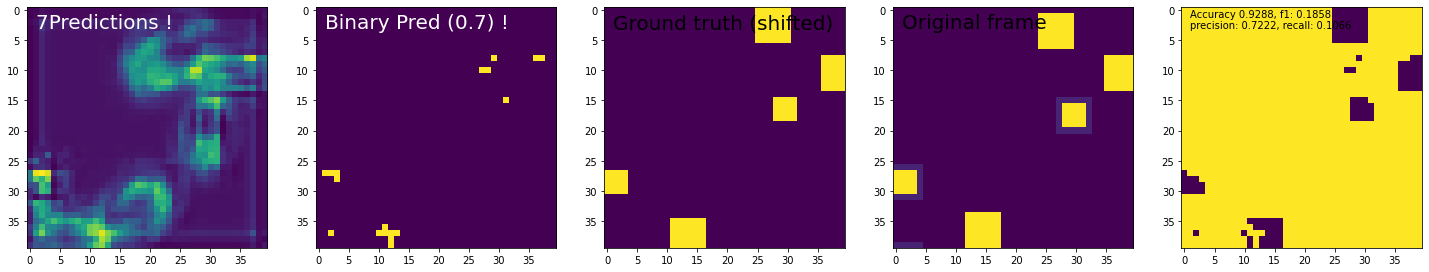

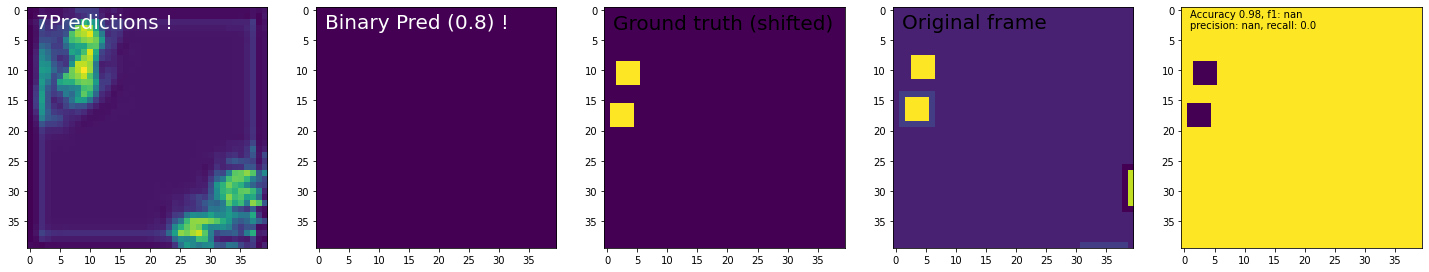

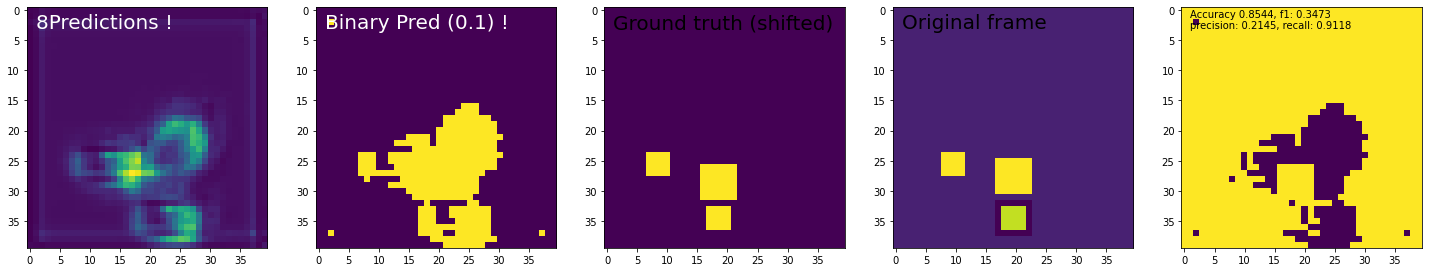

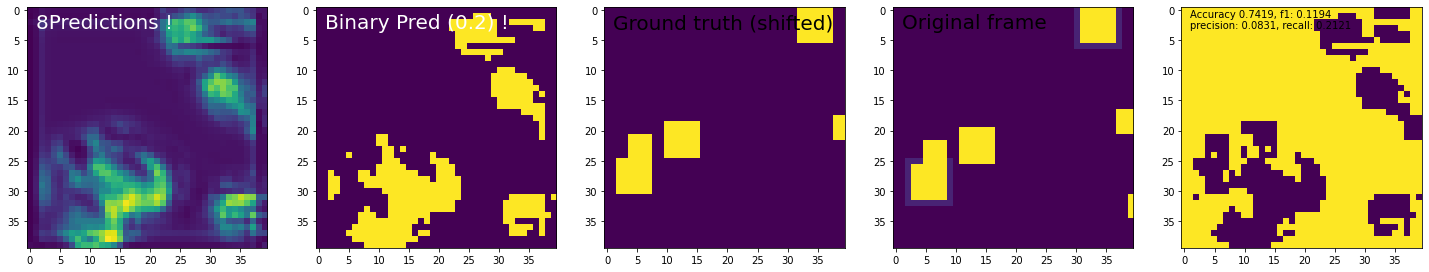

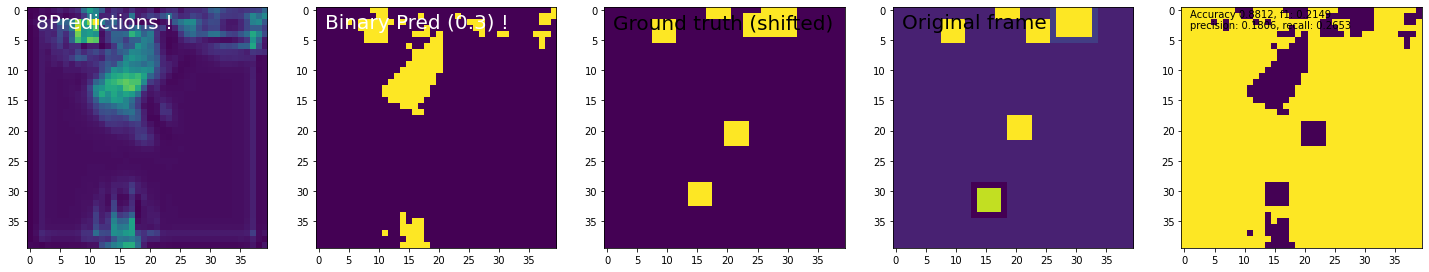

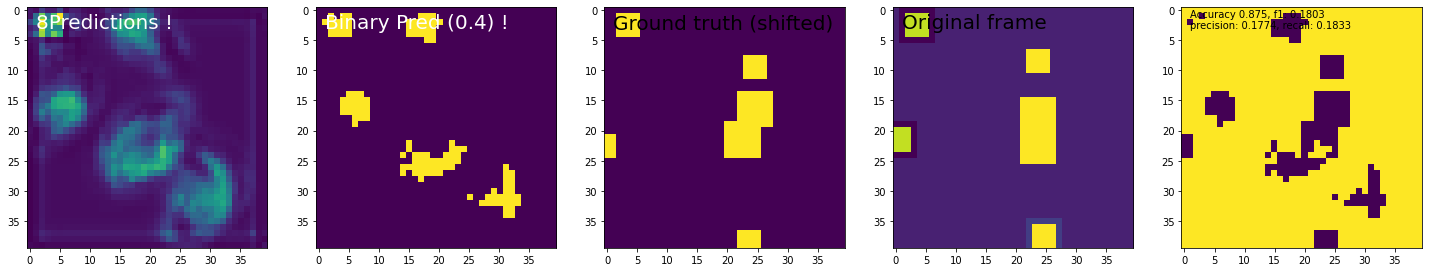

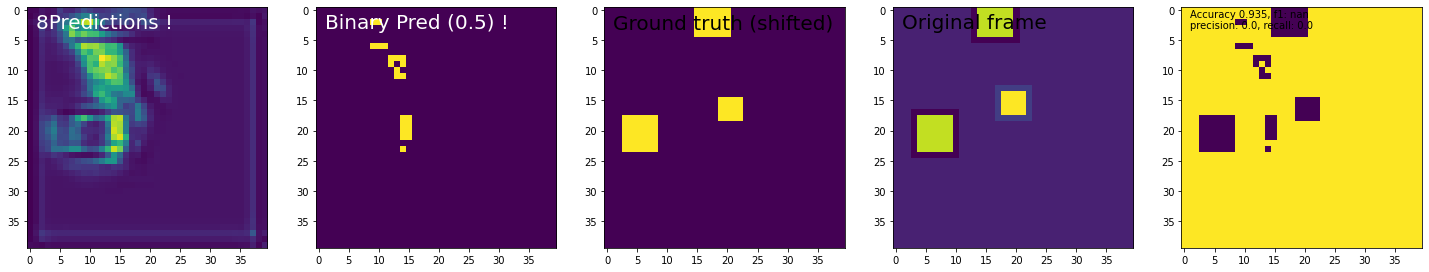

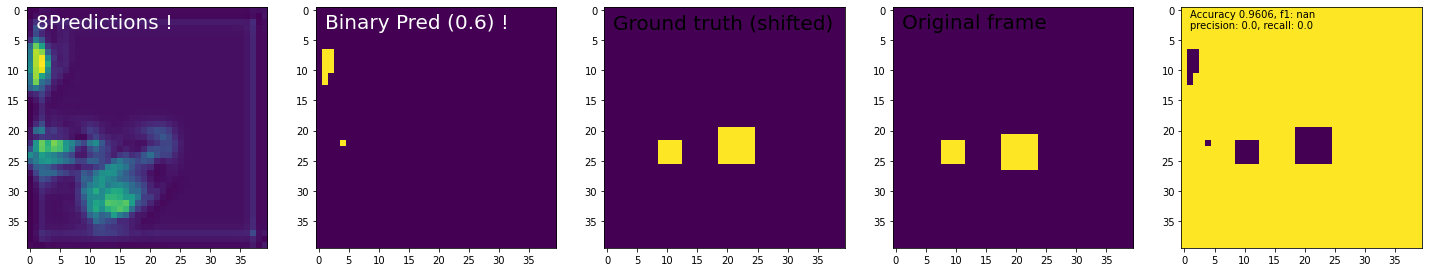

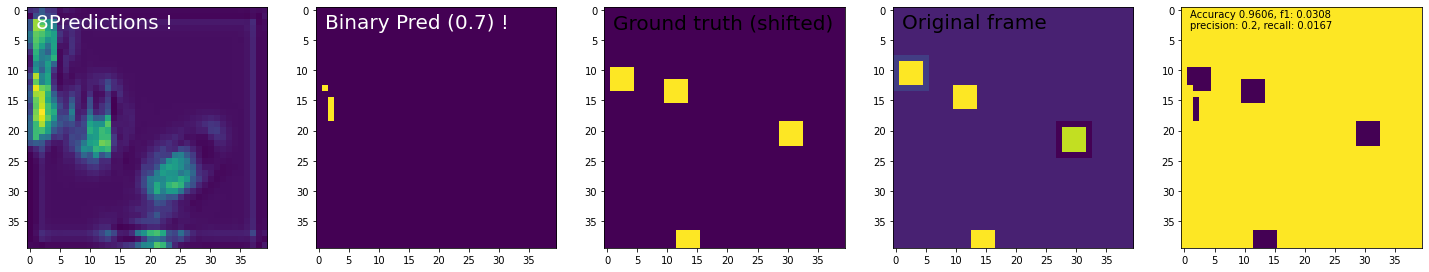

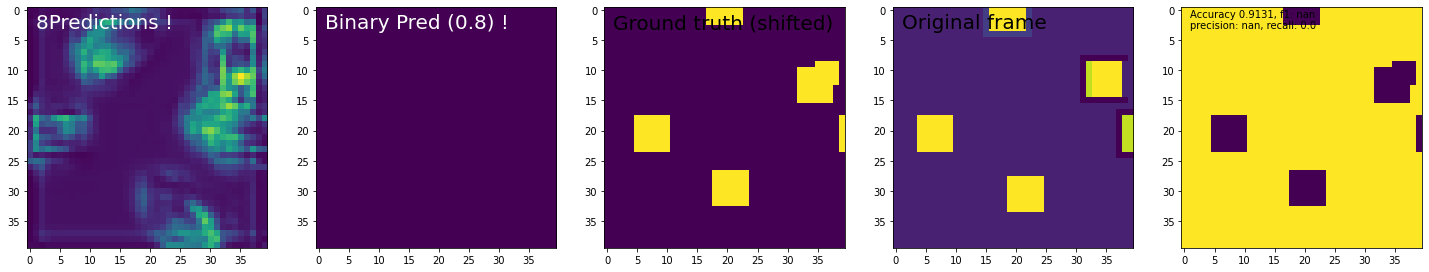

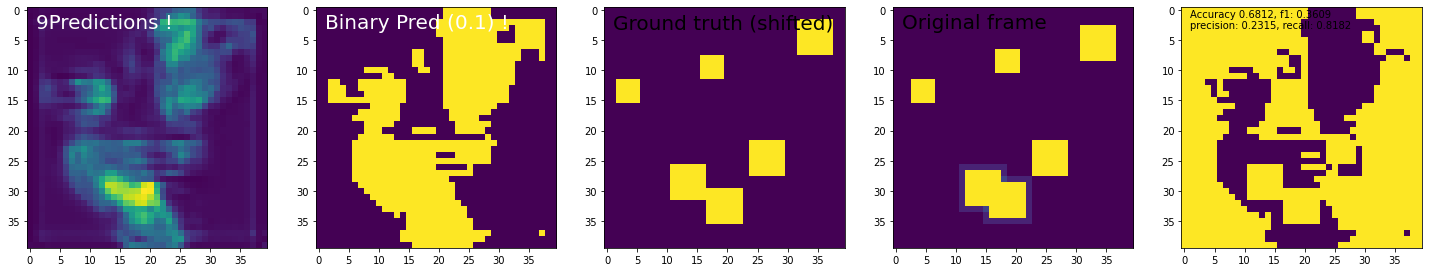

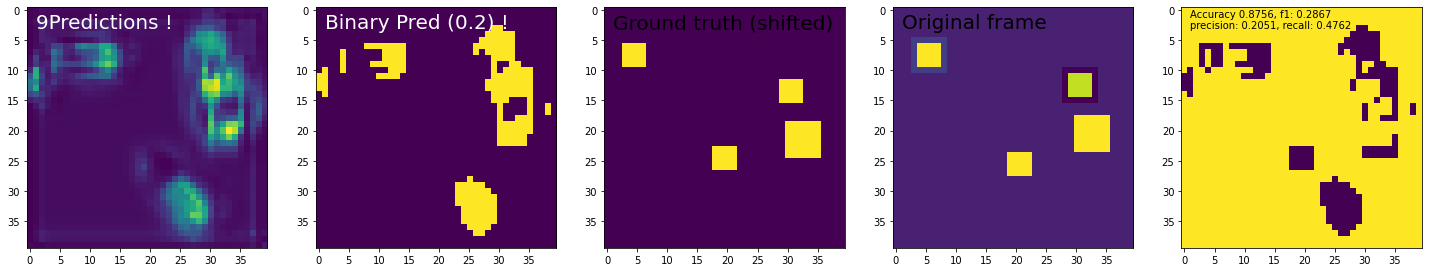

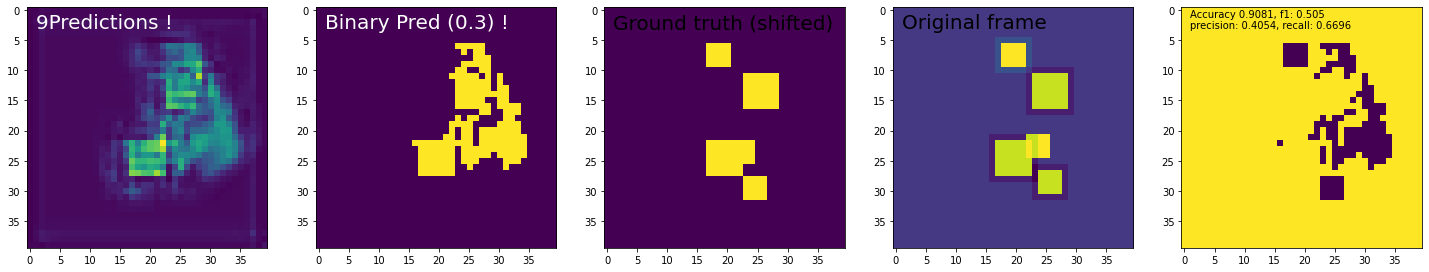

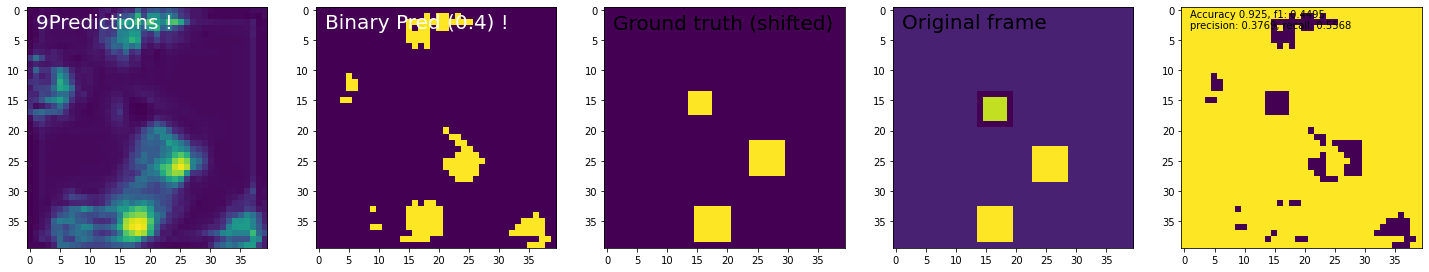

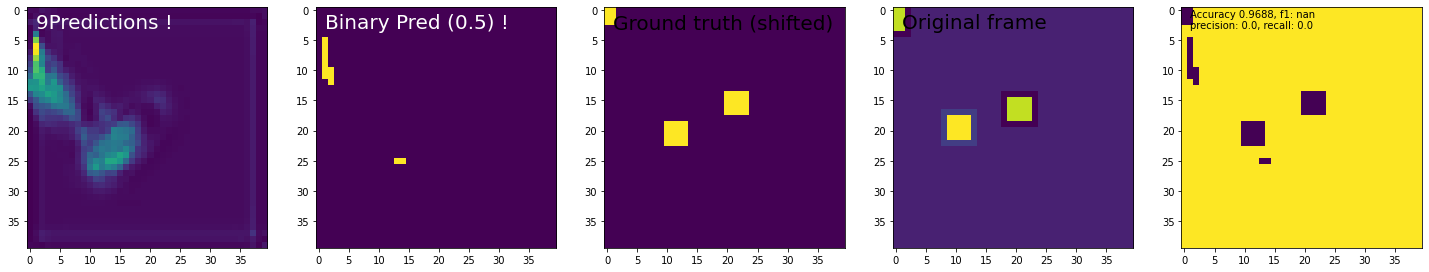

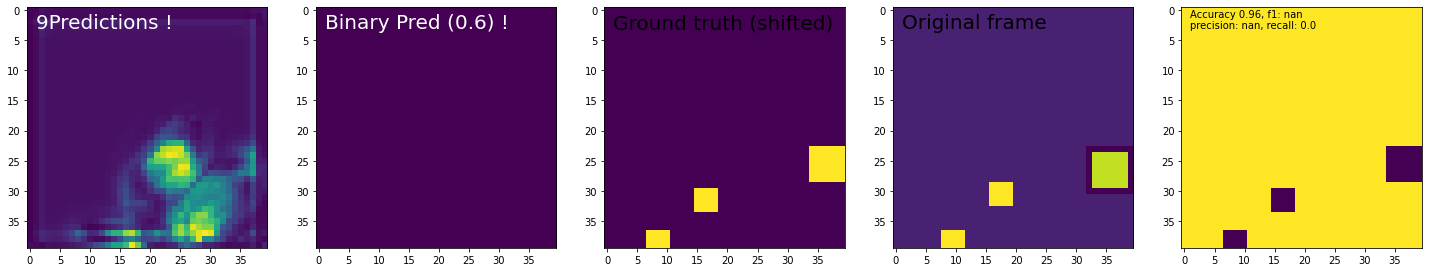

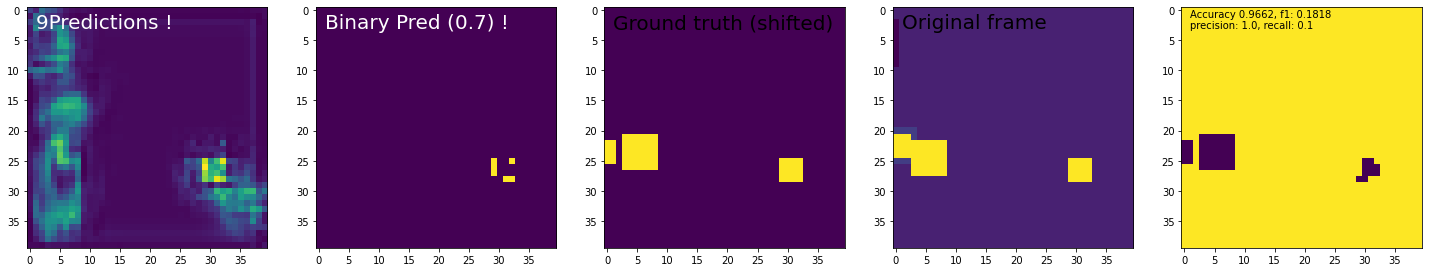

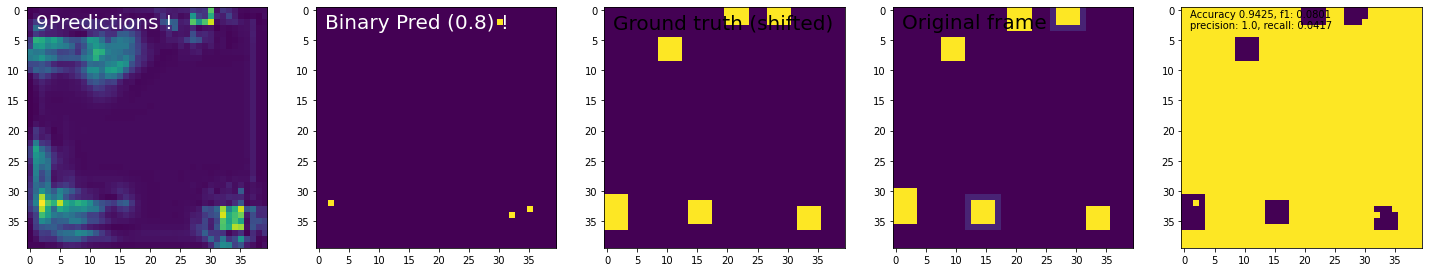

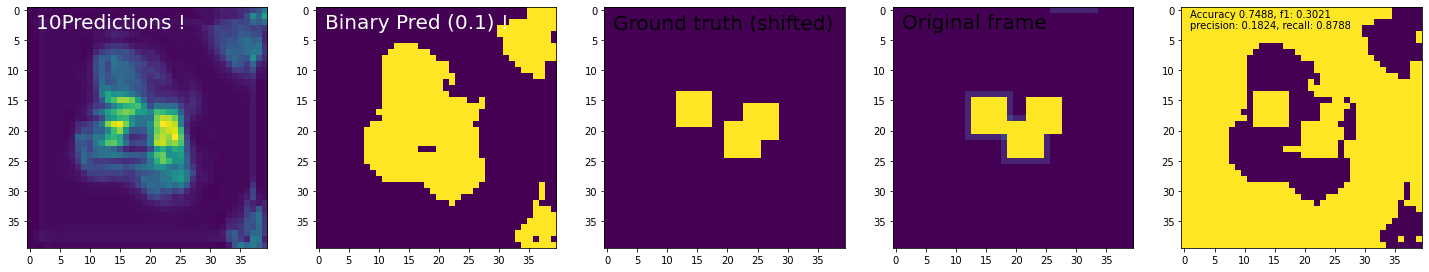

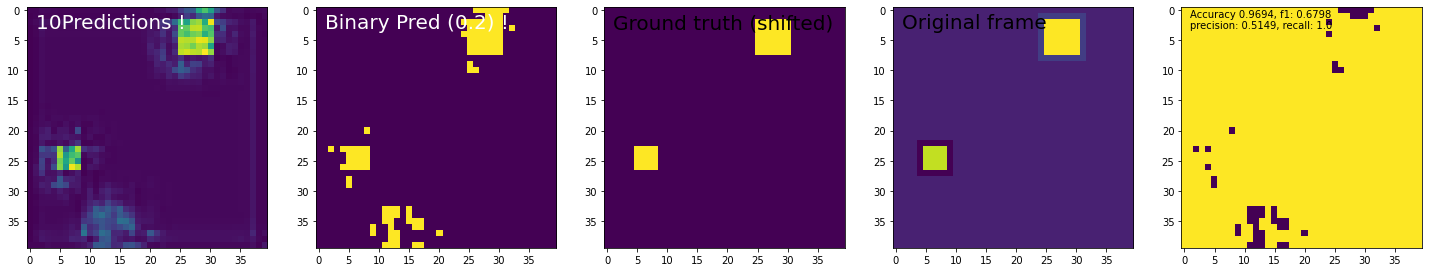

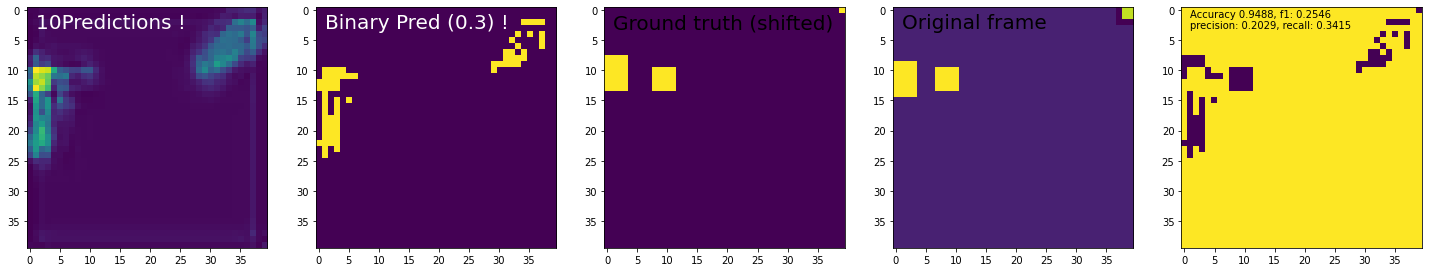

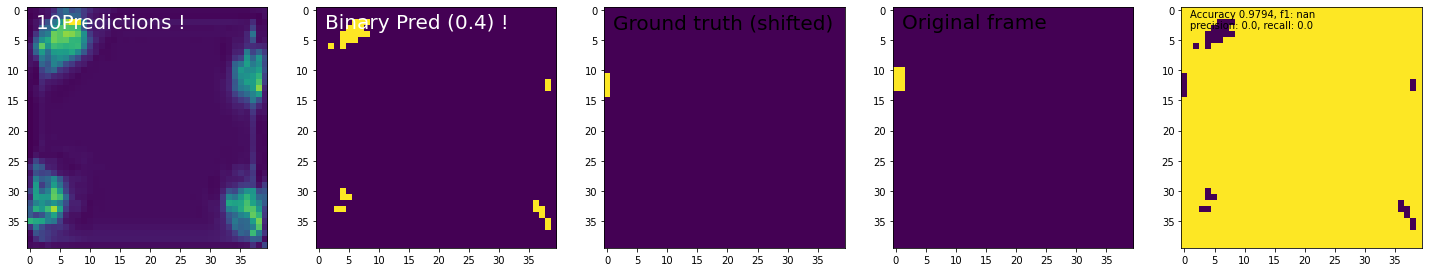

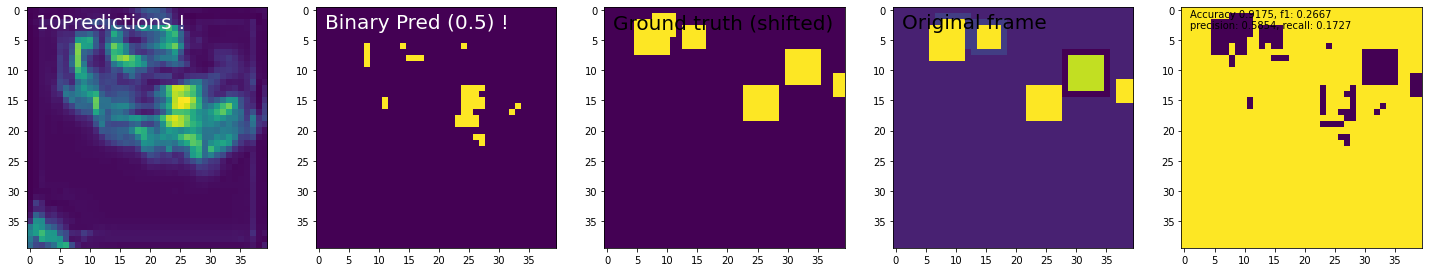

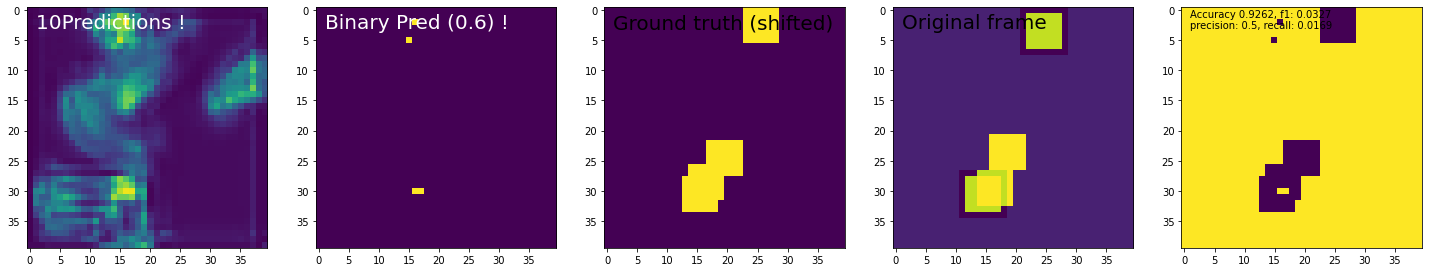

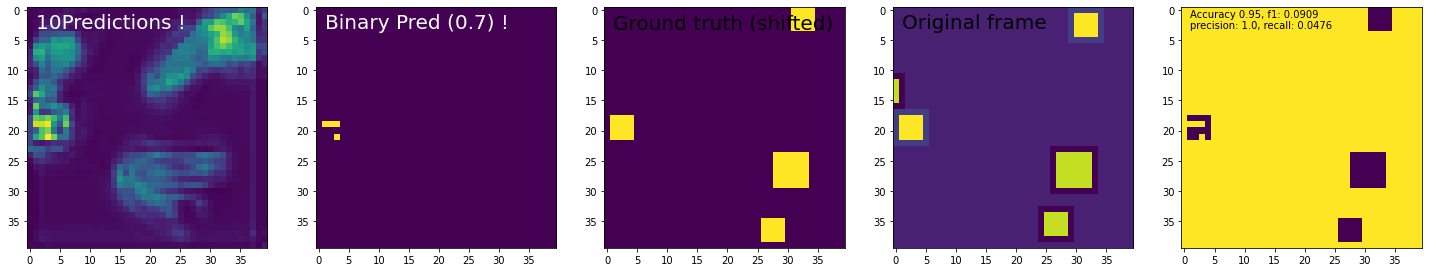

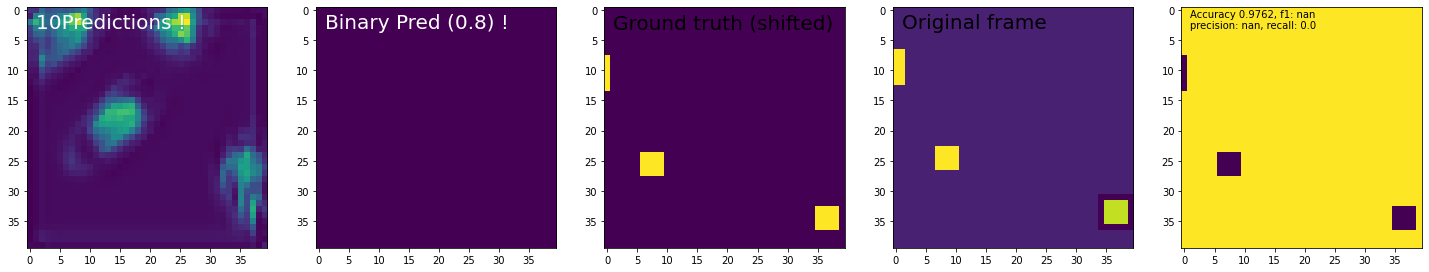

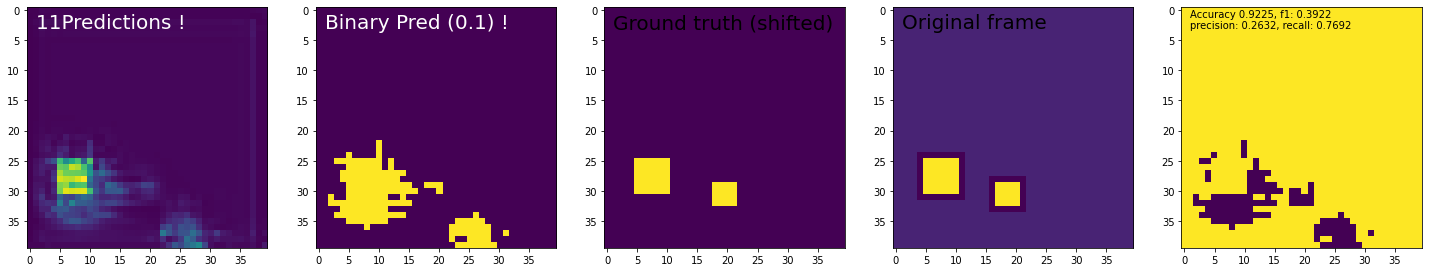

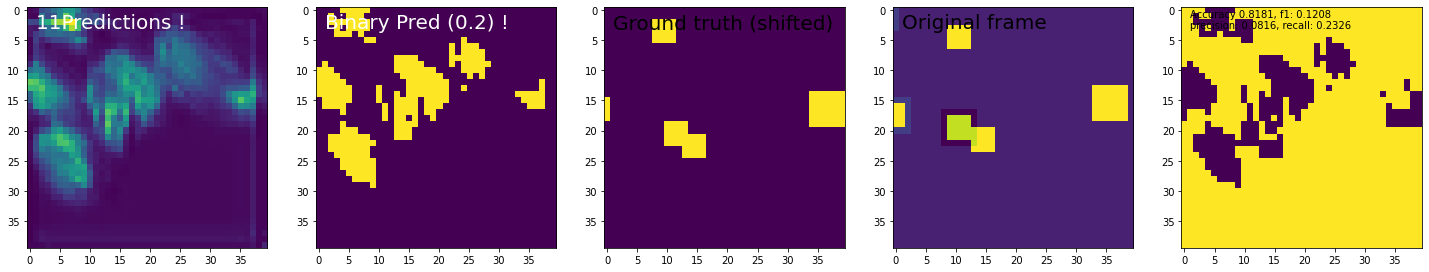

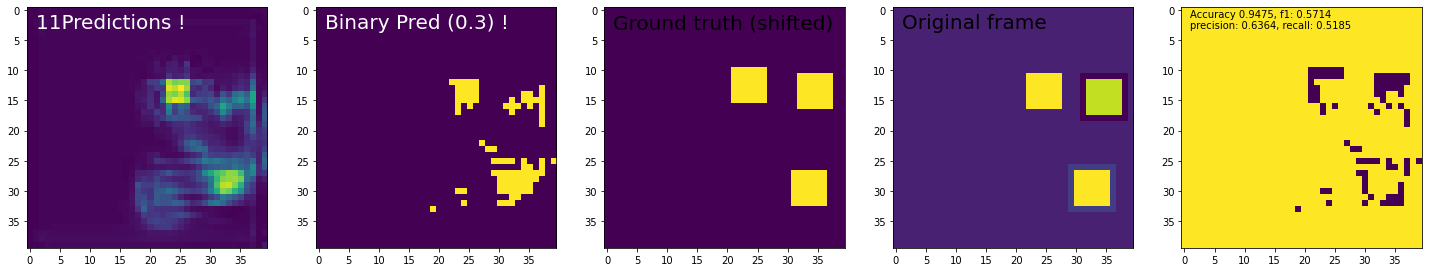

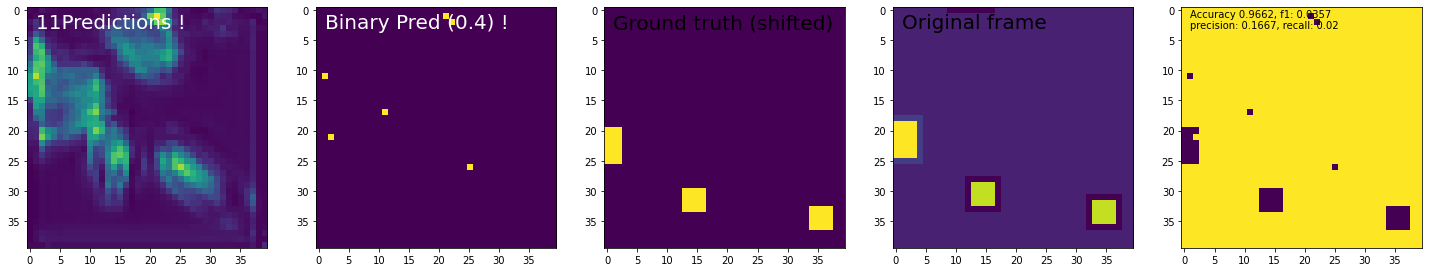

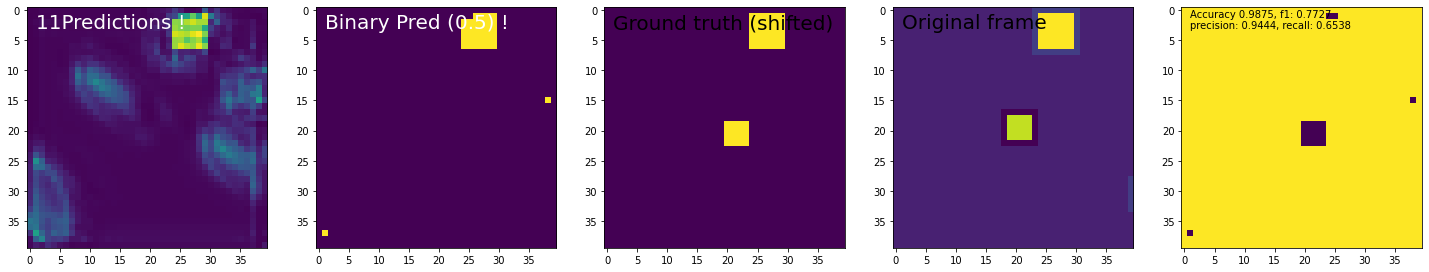

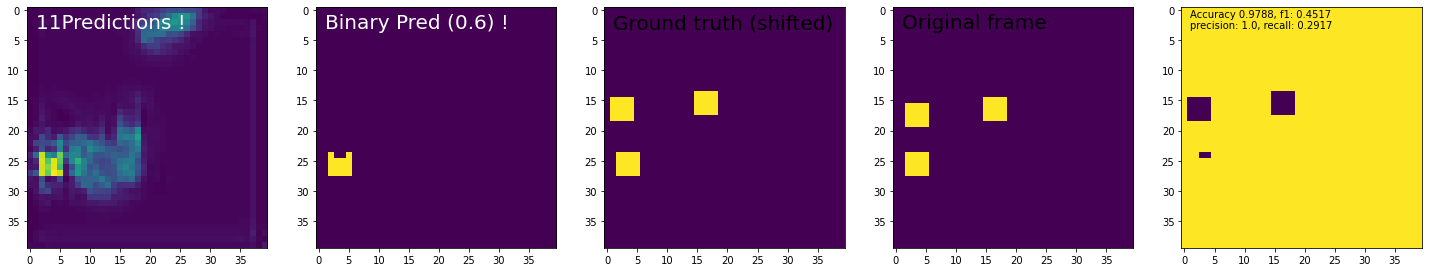

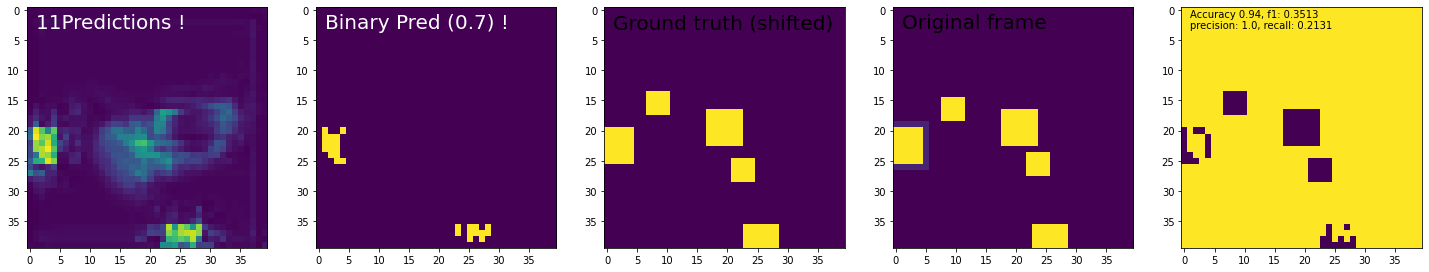

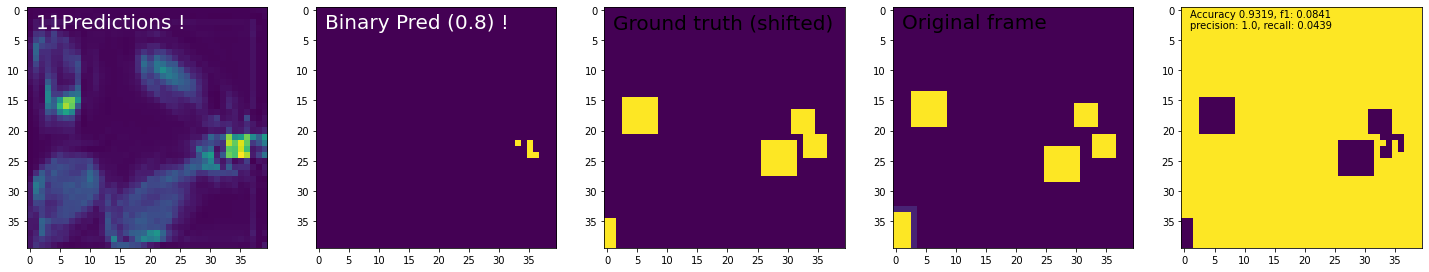

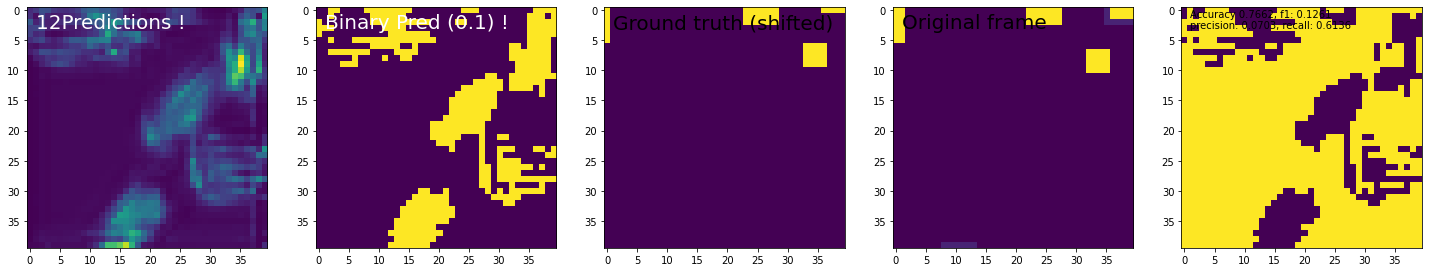

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars


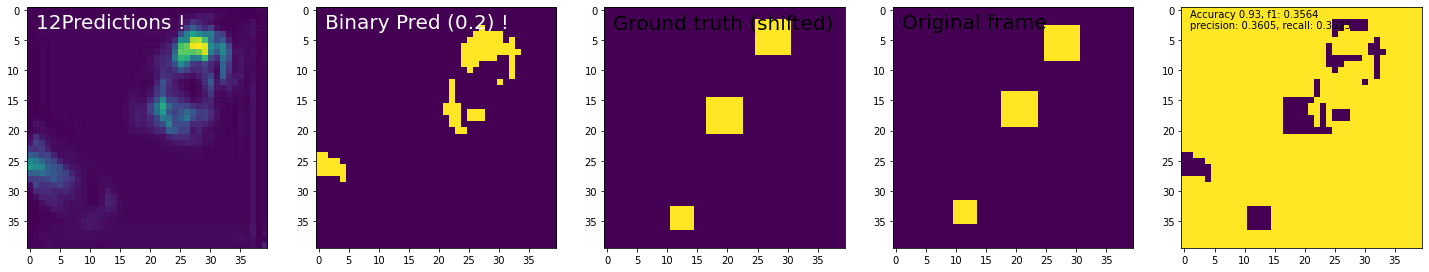

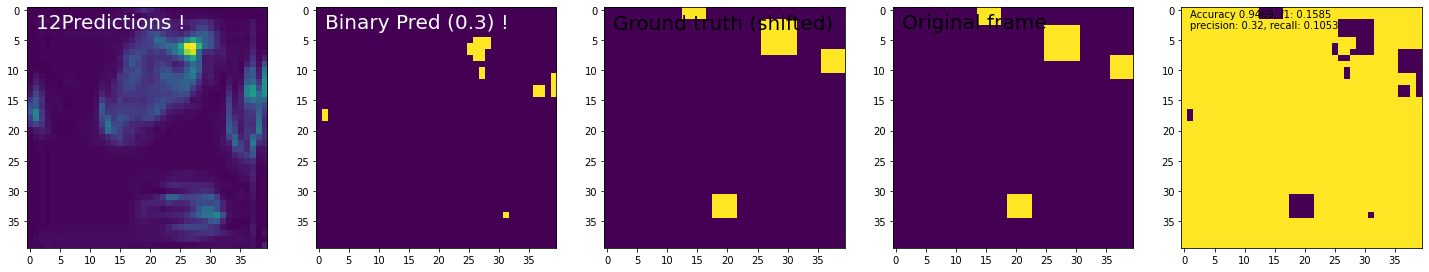

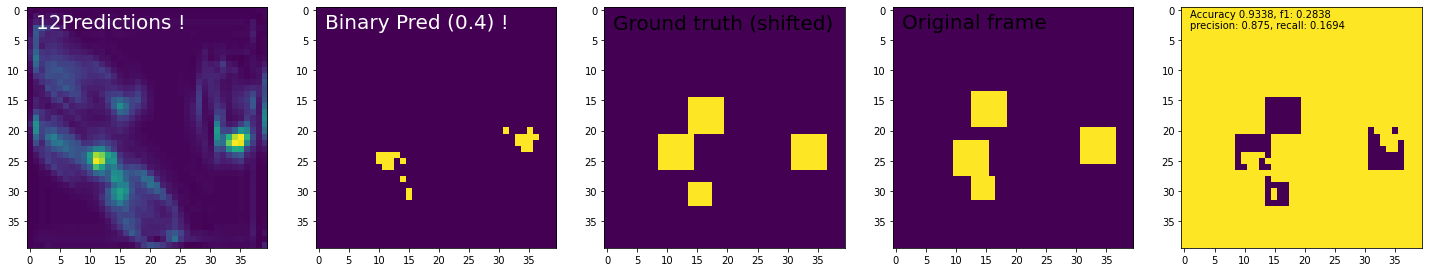

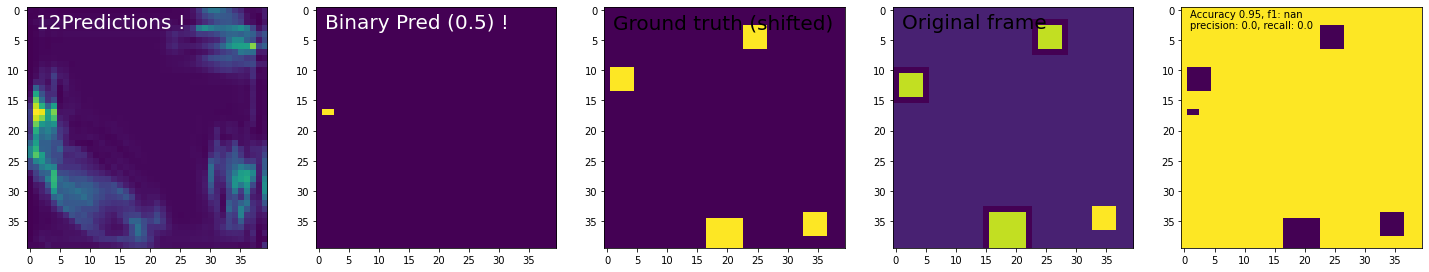

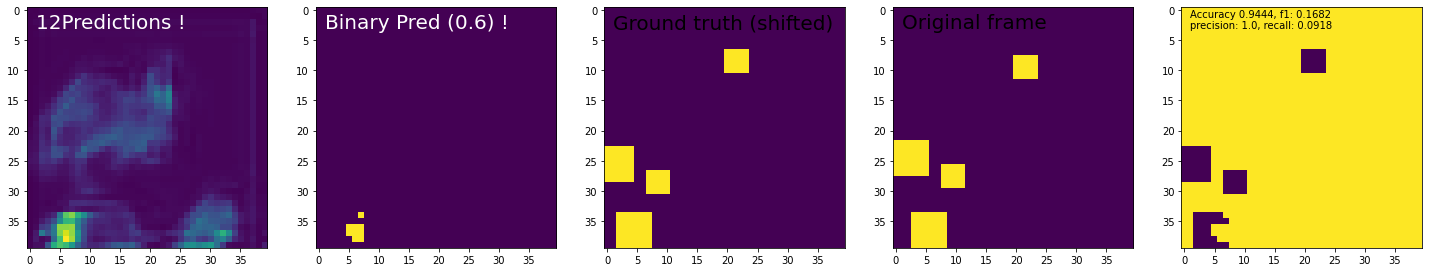

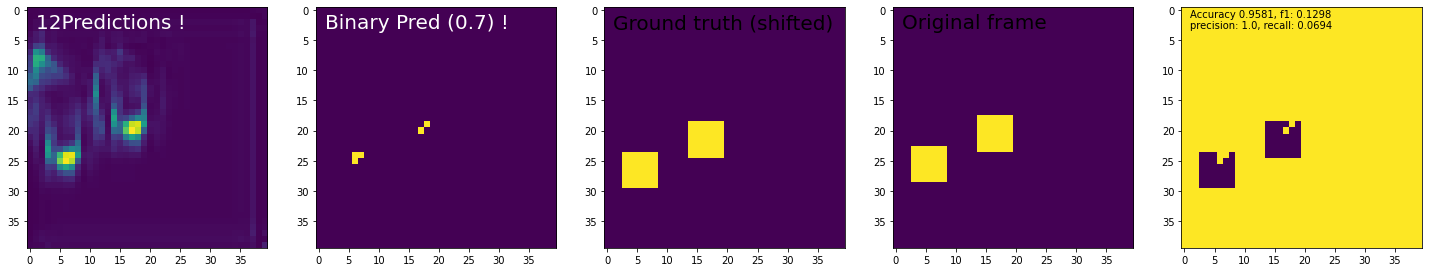

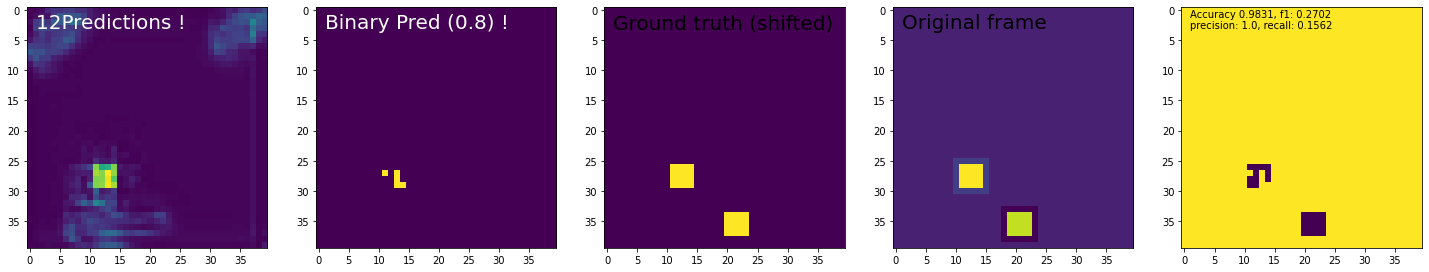

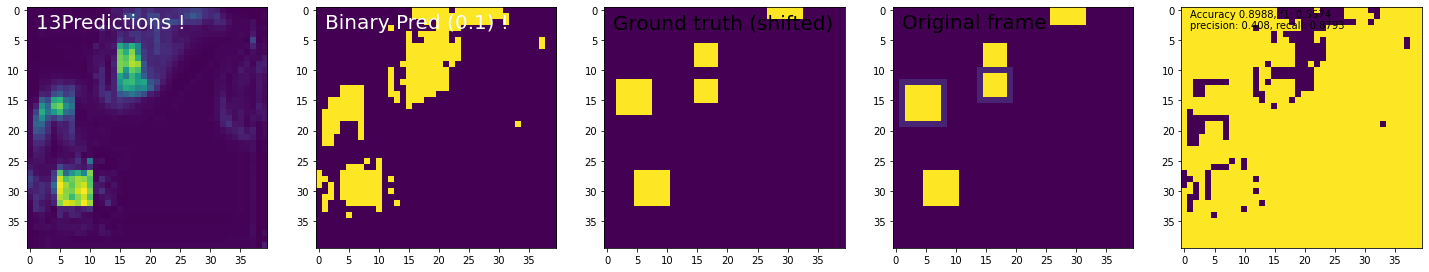

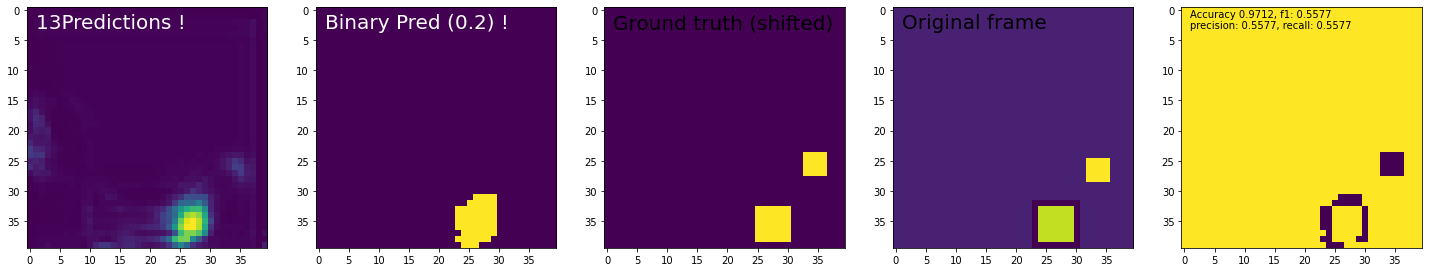

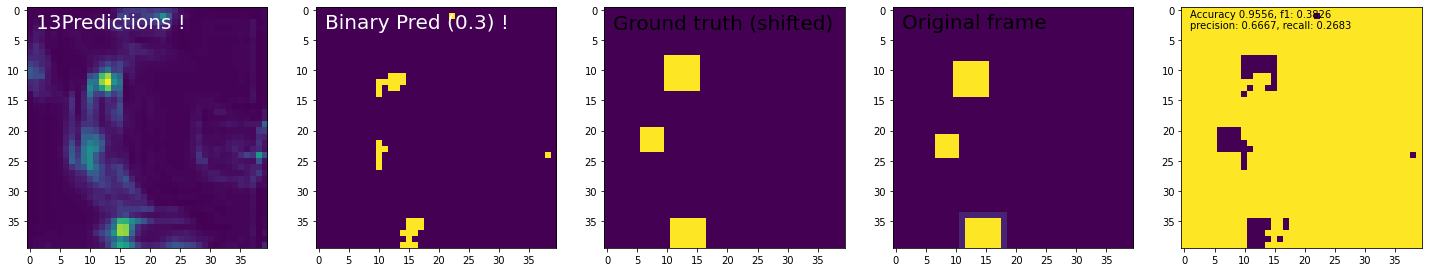

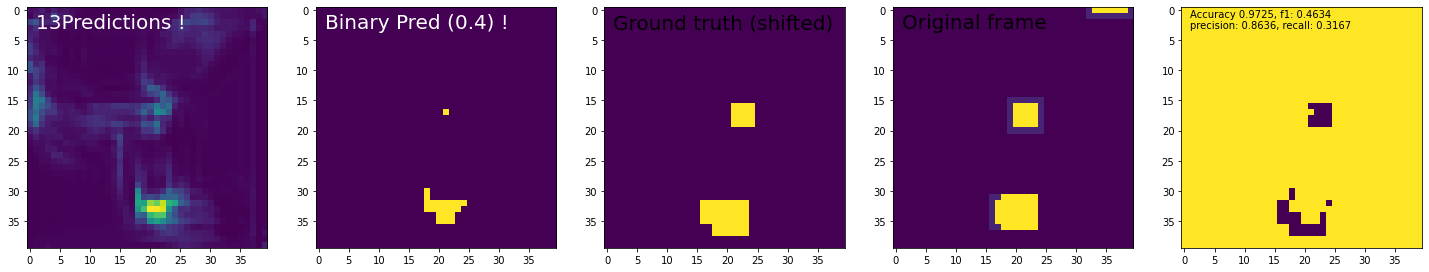

Error with len 13, bin_thr 0.4, execIdx 3
shape noisy (1, 13, 40, 40, 1), shape shifted (1, 13, 40, 40, 1) and shape pred (1, 13, 40, 40, 1)


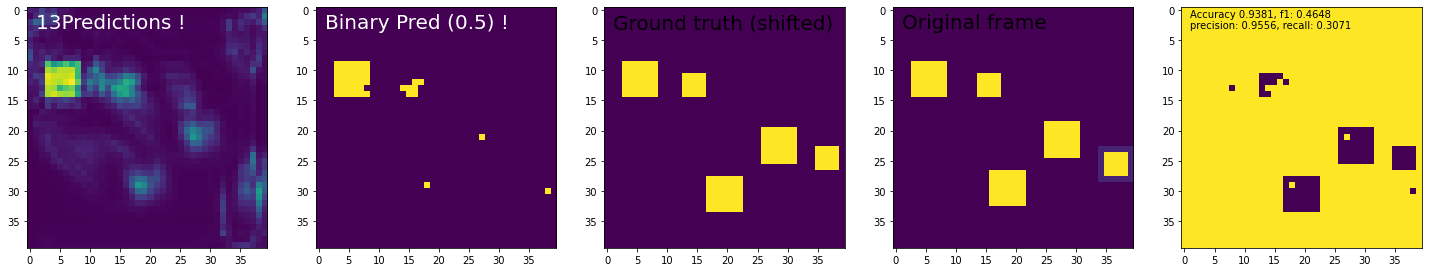

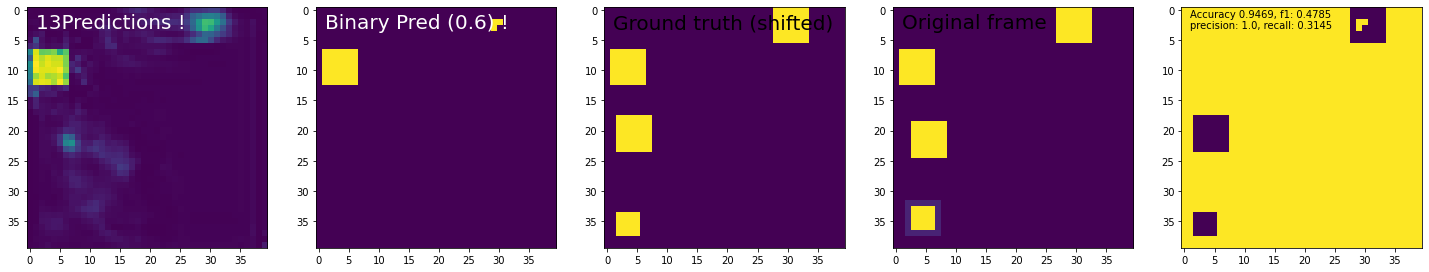

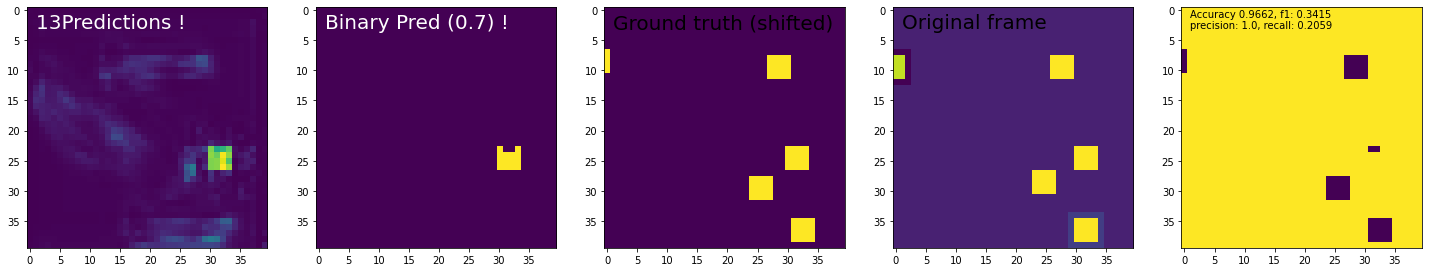

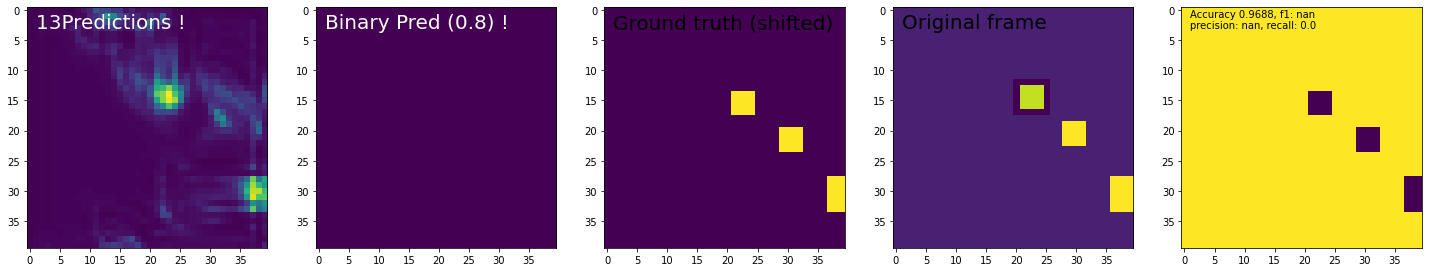

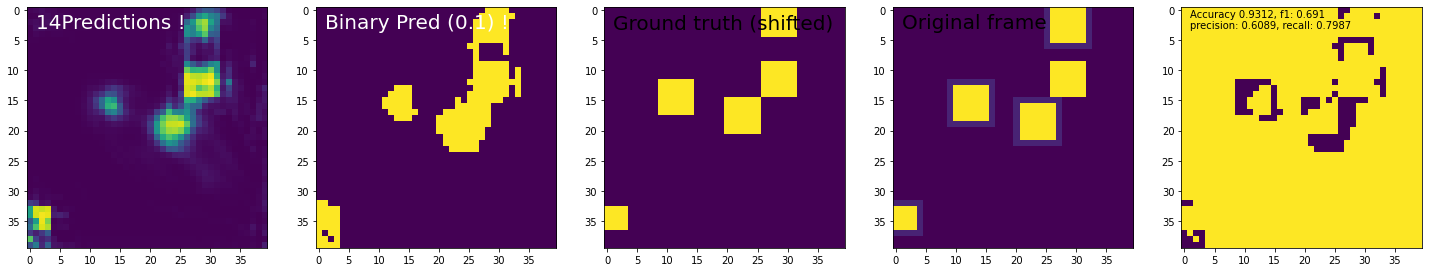

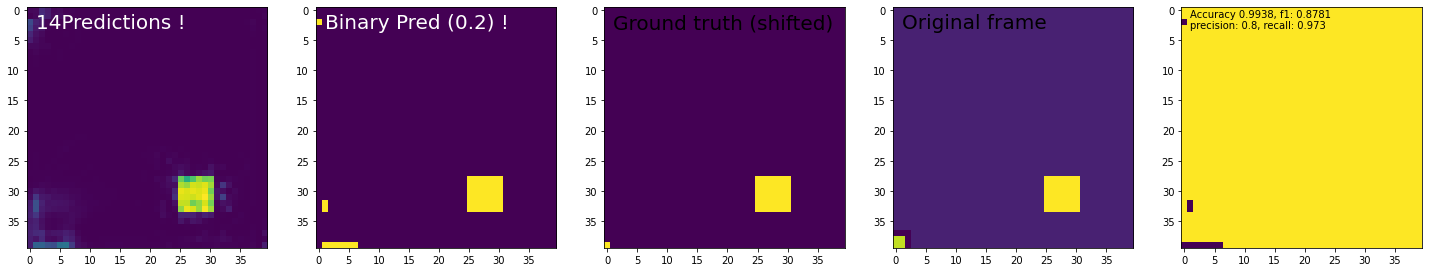

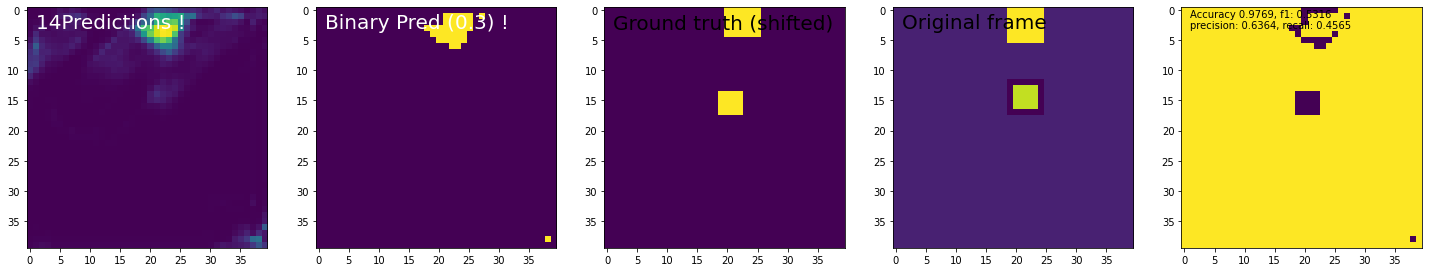

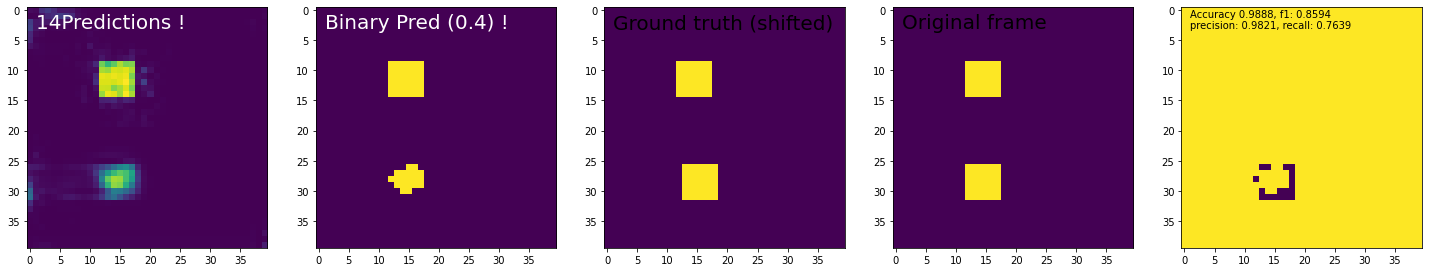

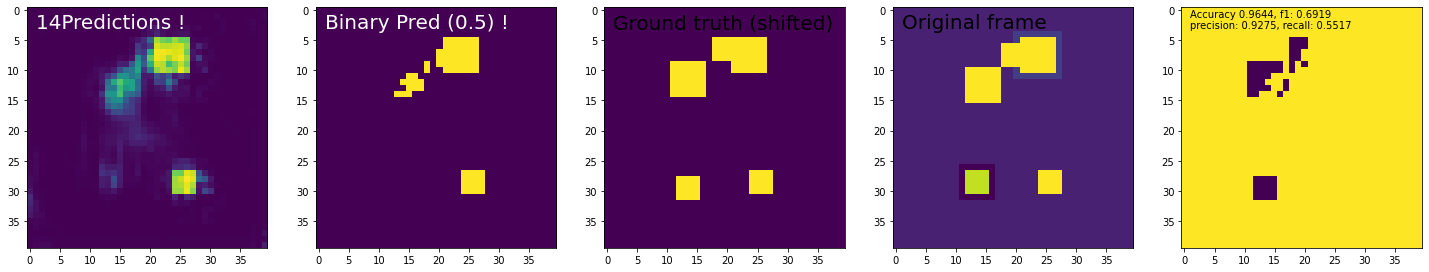

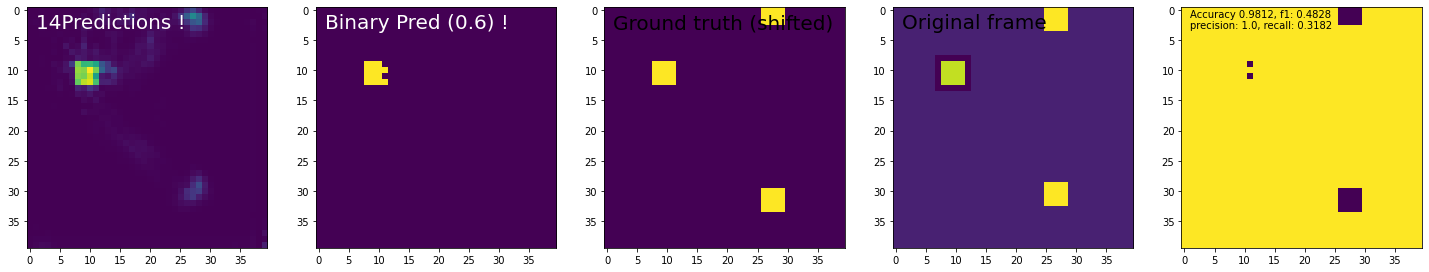

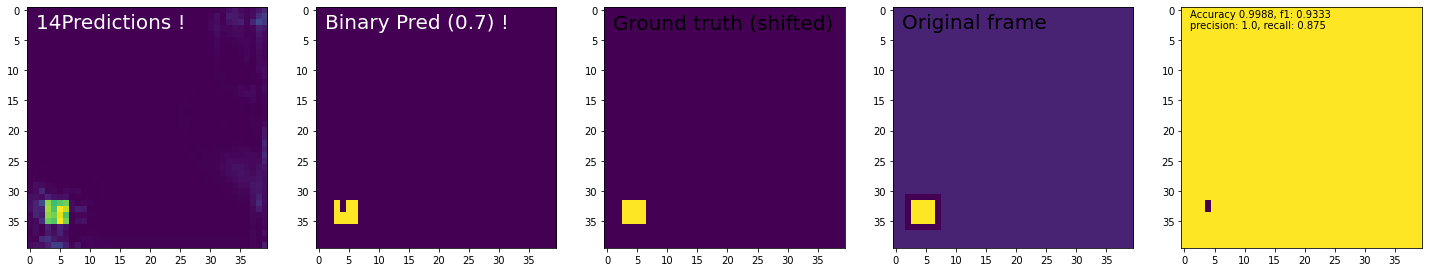

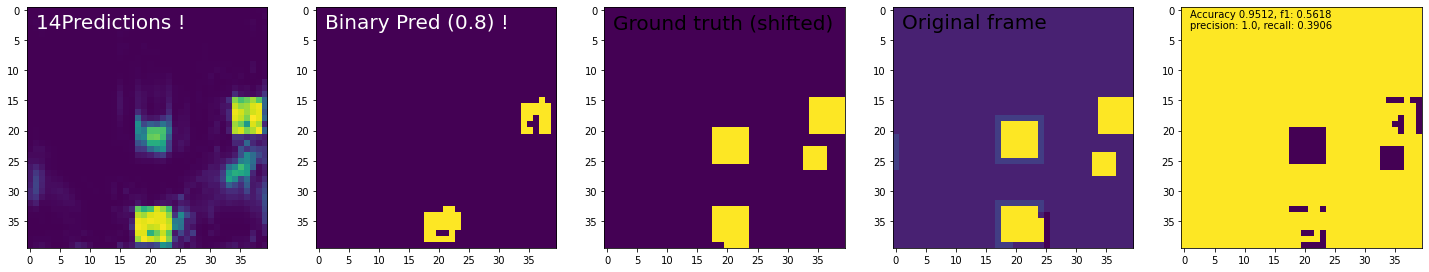

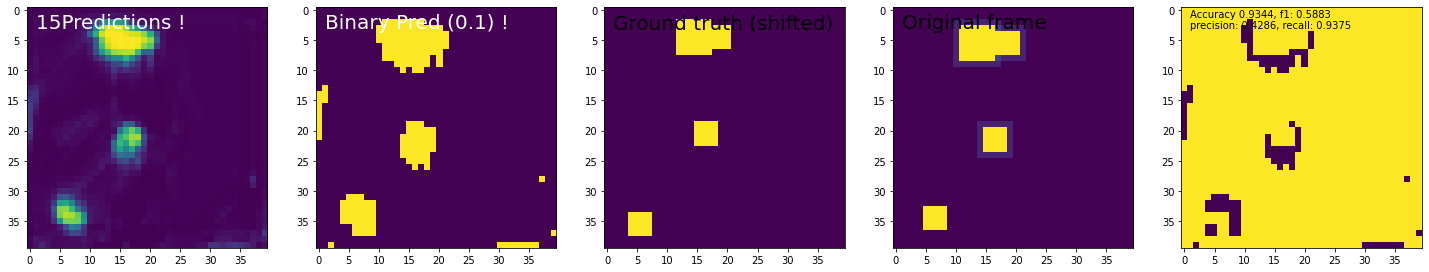

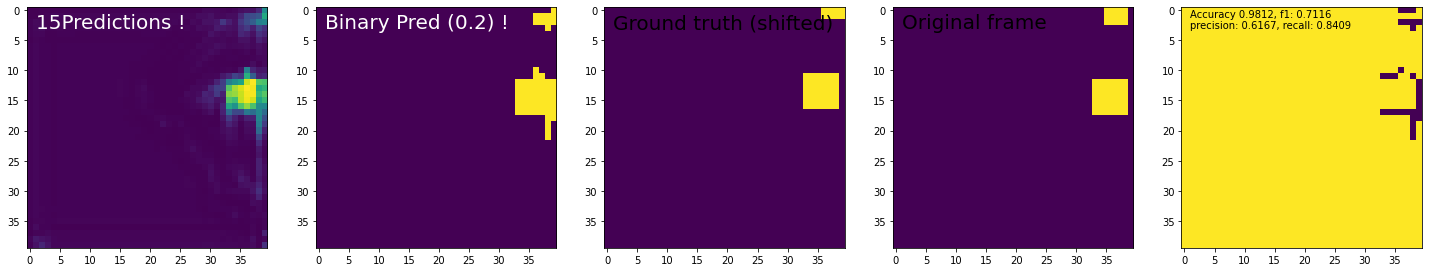

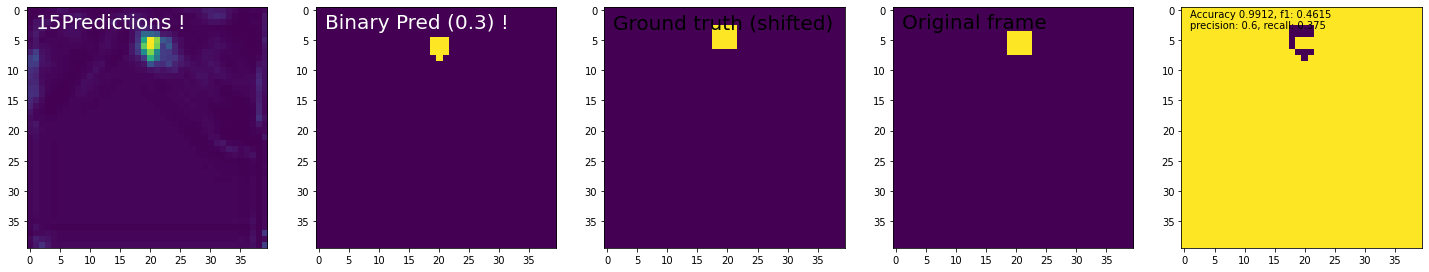

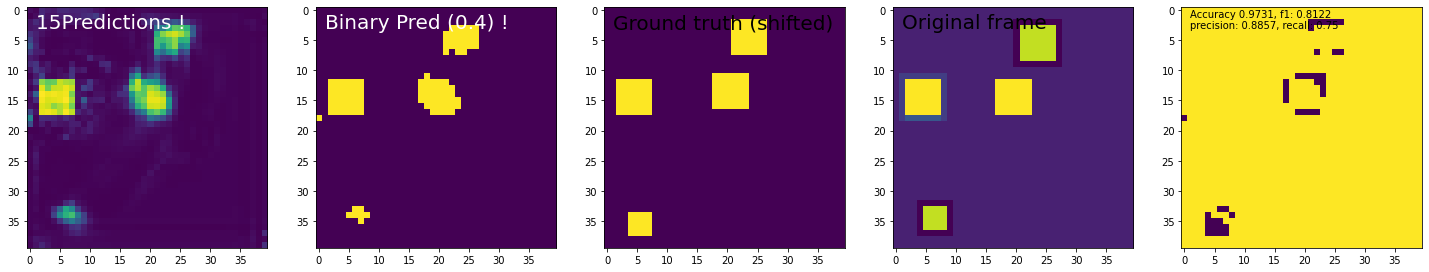

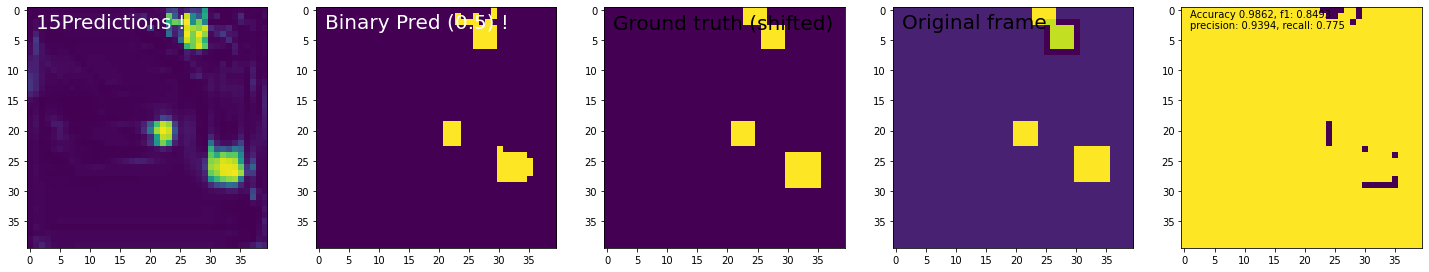

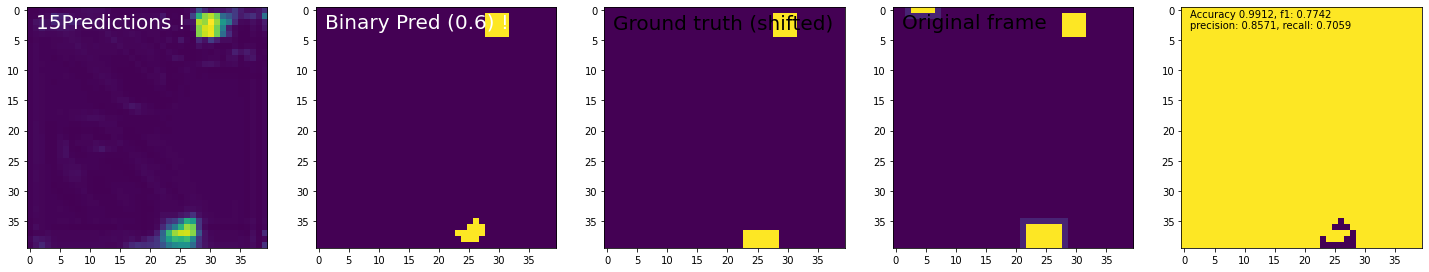

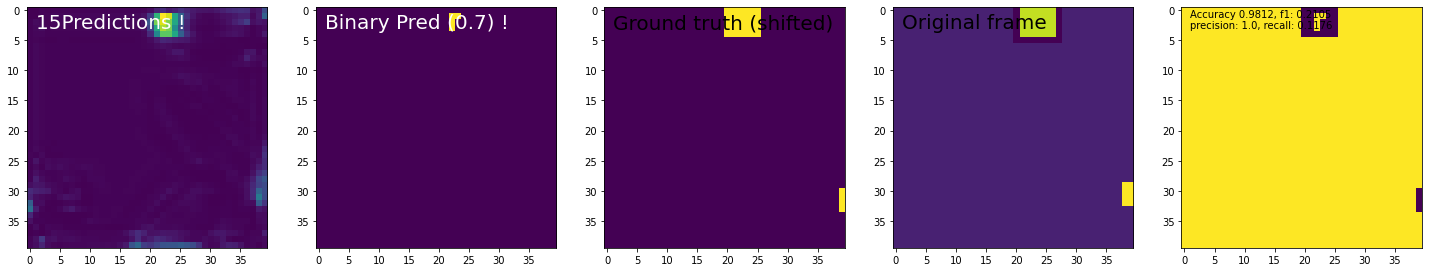

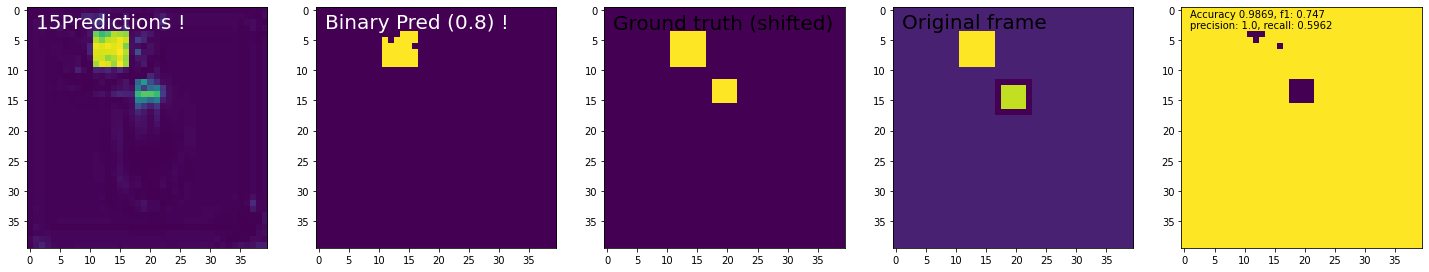

n_frames  bin_threshold        f1
0           1            0.1  0.042325
1           1            0.2       NaN
2           1            0.3       NaN
3           1            0.4       NaN
4           1            0.5       NaN
..        ...            ...       ...
115        15            0.4  0.780060
116        15            0.5  0.622320
117        15            0.6  0.505920
118        15            0.7  0.532350
119        15            0.8  0.646340

[120 rows x 3 columns]

In [ ]:
dfList = []

plot_idx = np.random.randint(5)

for len_movie in range(1, 16):
  for bin_thr in np.arange(0.1, 0.9, 0.1):
    for execIdx in range(5):
      try:
        # print(len_movie, bin_thr, execIdx)
        noisy, shifted = generate_movies(n_samples=1, n_frames=len_movie)
        pred = seq.predict(noisy)
        df = performance_evaluation(noisy[0,-1:], shifted[0,-1:], pred[0,-1:], plot=plot_idx==execIdx, title=str(len_movie), binarize_threshold=bin_thr)
        plt.show()
        df.loc[:, 'n_frames'] = len_movie
        df.loc[:, 'idx'] = execIdx
        df.loc[:, 'bin_threshold'] = bin_thr
        dfList.append(df)
      except Exception as e:
        print(f'Error with len {len_movie}, bin_thr {bin_thr}, execIdx {execIdx}')
        print(f'shape noisy {noisy.shape}, shape shifted {shifted.shape} and shape pred {pred.shape}')

perfDF = pd.concat(dfList)
perfDF.groupby(['n_frames', 'bin_threshold'])['f1'].mean().reset_index()

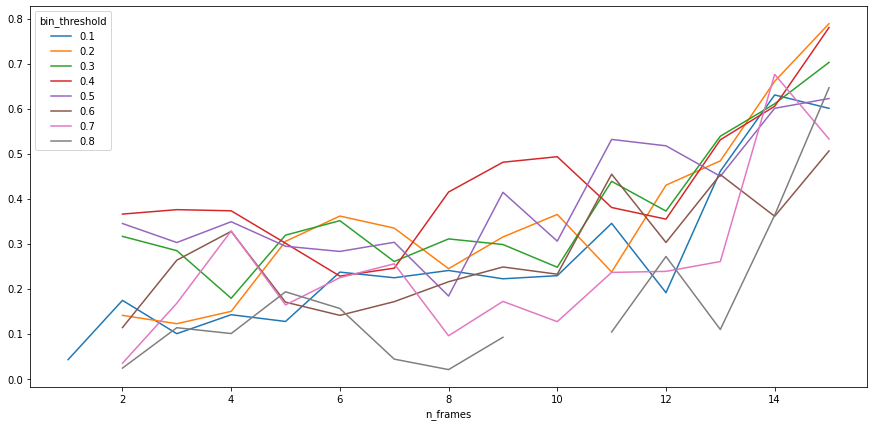

In [ ]:
df = pd.concat(dfList).groupby(['n_frames', 'bin_threshold'])['f1'].mean().reset_index()
piv = pd.pivot_table(df, columns='bin_threshold', index='n_frames', values='f1')
piv.rename(columns={k: str(round(k,1)) for k in piv.columns}).plot(figsize=(15,7))
plt.show()